<a href="https://colab.research.google.com/github/NeemiasEmanuel/-predict-nps-customers-python/blob/main/CNHGrupo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.inspection import partial_dependence, PartialDependenceDisplay


In [ ]:
uploaded = files.upload()

Saving Lista NPS Positivo_V4 (1).xlsx to Lista NPS Positivo_V4 (1).xlsx


#Funções


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def gerar_curva_roc(y_test, y_proba, model_name):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve ({model_name}, AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

def gerarPDP(modelo, X_train, features, top_n=5):
    """
    Gera gráficos PDP (Partial Dependence Plots) para as variáveis mais importantes.

    Args:
        modelo: Modelo treinado (como RandomForestClassifier).
        X_train: Conjunto de dados de treinamento (DataFrame ou matriz).
        features: Lista de variáveis de entrada (colunas do DataFrame de entrada).
        top_n: Número de variáveis mais importantes para exibir (default: 5).

    Returns:
        None. Apenas exibe os gráficos PDP.
    """

    importances = modelo.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = [features[i] for i in indices]

    print(f"\nTop {top_n} variáveis mais importantes para PDP:")
    for i, feature in enumerate(top_features):
        print(f"{i+1}. {feature} - Importância: {importances[indices[i]]:.4f}")

    # Gerar gráficos PDP para cada variável
    for feature in top_features:
        plt.figure(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(modelo, X_train, [feature], grid_resolution=50)
        plt.title(f"PDP para {feature}")
        plt.show()

def criarSafra(regiao_df):
    return {

    2022: regiao_df[regiao_df['data_resposta'].dt.year == 2022],
    2023: regiao_df[regiao_df['data_resposta'].dt.year == 2023],
    2024: regiao_df[regiao_df['data_resposta'].dt.year == 2024]
}

def mostrarSafra(safra):


  print("\n### SAFRA 2022 ###\n")

  print(safra[2022][['data_resposta', 'nota', 'categoria']])

  print("\n### SAFRA 2023 ###\n")

  print(safra[2023][['data_resposta', 'nota', 'categoria']])

  print("\n### SAFRA 2024 ###\n")

  print(safra[2024][['data_resposta', 'nota', 'categoria']])


def criarModelo(df_modelo):

  numeric_filtered_df = df_modelo.select_dtypes(include=['number'])

  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)

  features_df = numeric_filtered_df.drop(columns=['nota'], errors='ignore')
  feature_names = features_df.columns


  target_detractor = df_modelo['target_detractor'].values


  target_neutral = df_modelo['target_neutral'].values


  X_train_detractor, X_test_detractor, y_train_detractor, y_test_detractor = train_test_split(features_df, target_detractor, test_size=0.3, random_state=42)


  model_detractor = RandomForestClassifier(random_state=42)
  model_detractor.fit(X_train_detractor, y_train_detractor)


  y_pred_detractor = model_detractor.predict(X_test_detractor)
  accuracy_detractor = accuracy_score(y_test_detractor, y_pred_detractor)
  y_detractor_proba = model_detractor.predict_proba(X_test_detractor)



  X_train_neutral, X_test_neutral, y_train_neutral, y_test_neutral = train_test_split(features_df, target_neutral, test_size=0.3, random_state=42)

  model_neutral = RandomForestClassifier(random_state=42)
  model_neutral.fit(X_train_neutral, y_train_neutral)
  y_neutral_proba = model_neutral.predict_proba(X_test_neutral)

  y_pred_neutral = model_neutral.predict(X_test_neutral)
  accuracy_neutral = accuracy_score(y_test_neutral, y_pred_neutral)


  print("\nAcurácia do modelo de detratores: {:.2f}".format(accuracy_detractor))
  print("\nProbabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):")
  for i, probs in enumerate(y_detractor_proba[:5]):
    print(f"P {i+1}: Classe 0 (Não Detrator): {probs[0]:.2f}, Classe 1 (Detrator): {probs[1]:.2f}")


  print("\nAcurácia do modelo de neutros: {:.2f}".format(accuracy_neutral))
  print("\nProbabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):")
  for i, probs in enumerate(y_neutral_proba[:5]):
    print(f"Probalidade {i+1}: Classe 0 (Não Neutro): {probs[0]:.2f}, Classe 1 (Neutro): {probs[1]:.2f}")


  cm = confusion_matrix(y_test_detractor, y_pred_detractor)

  TN, FP, FN, TP = cm.ravel()

  plt.figure(figsize=(8, 6))
  ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

  plt.text(1.25, 1.25, f'TP={TP}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')
  plt.text(0.25, 0.25, f'TN={TN}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='white', weight='bold')
  plt.text(0.25, 1.25, f'FP={FP}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')
  plt.text(1.25, 0.25, f'FN={FN}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')

  plt.xlabel('Previsto')
  plt.ylabel('Verdadeiro')
  plt.title('Matriz de Confusão Detractor')
  plt.show()

  accuracyDetractor = accuracy_score(y_test_detractor, y_pred_detractor)
  print(f"Accuracy Detractor: {accuracyDetractor:.4f}")

  precisionDetractor = precision_score(y_test_detractor, y_pred_detractor)
  print(f"Precision Detractor: {precisionDetractor:.4f}")

  recallDetractor = recall_score(y_test_detractor, y_pred_detractor)
  print(f"Recall Detractor: {recallDetractor:.4f}")

  f1Detractor = f1_score(y_test_detractor, y_pred_detractor)
  print(f"F1-Score Detractor: {f1Detractor:.4f}")


  gerar_curva_roc(y_test_detractor, y_detractor_proba[:, 1], "Detratores")
  print("\n\n\n")

  cmNeutral = confusion_matrix(y_test_neutral, y_pred_neutral)

  TN, FP, FN, TP = cmNeutral.ravel()

  plt.figure(figsize=(8, 6))
  ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

  plt.text(1.25, 1.25, f'TP={TP}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')
  plt.text(0.25, 0.25, f'TN={TN}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='white', weight='bold')
  plt.text(0.25, 1.25, f'FP={FP}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')
  plt.text(1.25, 0.25, f'FN={FN}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', weight='bold')

  plt.xlabel('Previsto')
  plt.ylabel('Verdadeiro')
  plt.title('Matriz de Confusão Neutral')
  plt.show()

  accuracyNeutral = accuracy_score(y_test_neutral, y_pred_neutral)
  print(f"Accuracy Neutral: {accuracyNeutral:.4f}")

  precisionNeutral = precision_score(y_test_neutral, y_pred_neutral)
  print(f"Precision Neutral: {precisionNeutral:.4f}")

  recallNeutral = recall_score(y_test_neutral, y_pred_neutral)
  print(f"Recall Neutral: {recallNeutral:.4f}")

  f1Neutral = f1_score(y_test_neutral, y_pred_neutral)
  print(f"F1-Score Neutral: {f1Neutral:.4f}")


  gerar_curva_roc(y_test_neutral, y_neutral_proba[:, 1], "Neutros")
  print("\n\n\n")

  importances_detractor = model_detractor.feature_importances_
  indices_detractor = np.argsort(importances_detractor)[::-1][:10]
  top_10_features_detractor = features_df.columns[indices_detractor]
  print("\nTop 10 variáveis mais importantes para o modelo de detratores:")
  for i, feature in enumerate(top_10_features_detractor):
    print(f"{i + 1}. {feature} - Importância: {importances_detractor[indices_detractor[i]]:.2f}")

  print("\nGráficos PDP para o modelo de detratores:")
  gerarPDP(model_detractor, X_train_detractor, feature_names)
  print("\n\n\n")


  importances_Neutral = model_neutral.feature_importances_
  indices_Neutral = np.argsort(importances_Neutral)[::-1][:10]
  top_10_features_Neutral = features_df.columns[indices_Neutral]
  print("\nTop 10 variáveis mais importantes para o modelo de neutros:")
  for i, feature in enumerate(top_10_features_Neutral):
    print(f"{i + 1}. {feature} - Importância: {importances_Neutral[indices_Neutral[i]]:.2f}")

  print("\nGráficos PDP para o modelo de neutros:")
  gerarPDP(model_neutral, X_train_neutral, feature_names)


def calcular_volumetria_safrada(safra):
    resultados = []

    for ano, dados in safra.items():
        total = len(dados)
        promotores = len(dados[dados['categoria'] == "Promotor"])
        neutros = len(dados[dados['categoria'] == "Neutro"])
        detratores = len(dados[dados['categoria'] == "Detrator"])

        resultados.append({
            'Safra': ano,
            'Total': total,
            'Promotores': promotores,
            'Neutros': neutros,
            'Detratores': detratores,
            '%Promotores': round((promotores / total) * 100, 1) if total > 0 else 0,
            '%Neutros': round((neutros / total) * 100, 1) if total > 0 else 0,
            '%Detratores': round((detratores / total) * 100, 1) if total > 0 else 0
        })

    # Soma de todas as safras
    total_geral = {
        'Safra': 'Total',
        'Total': sum(r['Total'] for r in resultados),
        'Promotores': sum(r['Promotores'] for r in resultados),
        'Neutros': sum(r['Neutros'] for r in resultados),
        'Detratores': sum(r['Detratores'] for r in resultados),
        '%Promotores': round((sum(r['Promotores'] for r in resultados) / sum(r['Total'] for r in resultados)) * 100, 1) if sum(r['Total'] for r in resultados) > 0 else 0,
        '%Neutros': round((sum(r['Neutros'] for r in resultados) / sum(r['Total'] for r in resultados)) * 100, 1) if sum(r['Total'] for r in resultados) > 0 else 0,
        '%Detratores': round((sum(r['Detratores'] for r in resultados) / sum(r['Total'] for r in resultados)) * 100, 1) if sum(r['Total'] for r in resultados) > 0 else 0
    }
    resultados.append(total_geral)

    return pd.DataFrame(resultados)



def calcular_volumetria_periodos(periodos_pesquisa):
    resultados = {}
    for periodo, dados in periodos_pesquisa.items():

        safra_periodo = criarSafra(dados)


        tabela_volumetria_periodo = calcular_volumetria_safrada(safra_periodo)


        resultados[periodo] = tabela_volumetria_periodo

    return resultados



def exibir_tabela_volumetria(tabela_volumetria, titulo="Volumetria Safrada"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(
        cellText=tabela_volumetria.values,
        colLabels=tabela_volumetria.columns,
        cellLoc="center",
        loc="center",
        colLoc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(tabela_volumetria.columns))))
    plt.title(titulo, fontsize=12, pad=10)
    plt.show()




def exibir_tabelas_volumetria_periodos(volumetrias_por_periodo):
    for periodo, tabela in volumetrias_por_periodo.items():
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis("tight")
        ax.axis("off")
        table = ax.table(
            cellText=tabela.values,
            colLabels=tabela.columns,
            cellLoc="center",
            loc="center",
            colLoc="center",
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(tabela.columns))))
        plt.title(f"Volumetria - Período: {periodo}", fontsize=12, pad=10)
        plt.show()

def correlacao_spearman(df_modelo, nome_df):

    def highlight_correlations(val):
        if 0.8 <= val <= 1.0:
            return 'background-color: red'
        elif 0.4 <= val < 0.8:
            return 'background-color: lightblue'
        elif val < 0.4:
            return 'background-color: lightgreen'
        return ''


    filtered_df = df_modelo


    numeric_filtered_df = filtered_df.select_dtypes(include=['number'])

    numeric_filtered_df = numeric_filtered_df.drop(columns=['target_neutral', 'target_detractor'], errors='ignore')

    spearman_corr_nota = numeric_filtered_df.corrwith(numeric_filtered_df['nota'], method='spearman')


    spearman_corr_nota_df = pd.DataFrame(spearman_corr_nota, columns=['Spearman Correlation with "nota"']).drop(index='nota')


    spearman_corr_nota_df_sorted = spearman_corr_nota_df.sort_values(by='Spearman Correlation with "nota"', ascending=False)


    spearman_corr_nota_df_sorted_clean = spearman_corr_nota_df_sorted.dropna()


    styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


    filename = f'correlacao_spearman_com_nota_{nome_df}.xlsx'
    styled_corr_df_clean.to_excel(filename)


    print("\n### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###\n")
    print(spearman_corr_nota_df_sorted_clean)


    return spearman_corr_nota_df_sorted_clean




def criarSafraCorrelacao(regiao_df, nome_df):

    def highlight_correlations(val):
        if 0.8 <= val <= 1.0:
            return 'background-color: red'
        elif 0.4 <= val < 0.8:
            return 'background-color: lightblue'
        elif val < 0.4:
            return 'background-color: lightgreen'
        return ''


    def calcular_correlacao_safra(df, ano):

        numeric_filtered_df = df.select_dtypes(include=['number'])


        numeric_filtered_df = numeric_filtered_df.drop(columns=['target_neutral', 'target_detrator'], errors='ignore')


        spearman_corr_nota = numeric_filtered_df.corrwith(numeric_filtered_df['nota'], method='spearman')


        spearman_corr_nota_df = pd.DataFrame(spearman_corr_nota, columns=['Spearman Correlation with "nota"']).drop(index='nota')


        spearman_corr_nota_df_sorted = spearman_corr_nota_df.sort_values(by='Spearman Correlation with "nota"', ascending=False)


        spearman_corr_nota_df_sorted_clean = spearman_corr_nota_df_sorted.dropna()


        styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


        filename = f'correlacao_spearman_com_nota_{nome_df}_safra_{ano}.xlsx'
        styled_corr_df_clean.to_excel(filename)


        print(f"\n### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA {ano} ###\n")
        print(spearman_corr_nota_df_sorted_clean)


        return spearman_corr_nota_df_sorted_clean


    safras = {
        2022: calcular_correlacao_safra(regiao_df[regiao_df['data_resposta'].dt.year == 2022], 2022),
        2023: calcular_correlacao_safra(regiao_df[regiao_df['data_resposta'].dt.year == 2023], 2023),
        2024: calcular_correlacao_safra(regiao_df[regiao_df['data_resposta'].dt.year == 2024], 2024),
    }


    return safras



# Etapa 1/Etapa 2/ Etapa 3

# Filtrando a tabela do excel, e atribuindo valores a cada avaliação de acordo com a nota(Promotor, Detrator e Neutro)

In [ ]:

df = pd.read_excel('Lista NPS Positivo_V4 (1).xlsx')


df_grupo1 = df[(df['Grupo de Produto'] == 'Grupo 1') & (df['mercado'] == 'BRASIL')]

df_grupo1['data_resposta'] = pd.to_datetime(df_grupo1['data_resposta'], format='%d/%m/%Y %H:%M:%S', errors = 'coerce')


def categorizar_nota(nota):
    if nota >= 9:
        return "Promotor"
    elif nota >= 7:
        return "Neutro"
    else:
        return "Detrator"


df_grupo1['categoria'] = df_grupo1['nota'].apply(categorizar_nota)


print(df_grupo1[['nota', 'categoria']])


       nota categoria
5        10  Promotor
13        9  Promotor
17       10  Promotor
20        6  Detrator
21        8    Neutro
...     ...       ...
25059    10  Promotor
25067    10  Promotor
25077    10  Promotor
25080     9  Promotor
25156    10  Promotor

[4490 rows x 2 columns]


<ipython-input-7-30a35b5399af>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo1['data_resposta'] = pd.to_datetime(df_grupo1['data_resposta'], format='%d/%m/%Y %H:%M:%S', errors = 'coerce')
<ipython-input-7-30a35b5399af>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo1['categoria'] = df_grupo1['nota'].apply(categorizar_nota)


# Etapa 4

# Calculando volumetria do target da base geral, incluindo a contagem e porcentagem de Detratores, Neutros e Promotores

In [ ]:

contagem_categorias = df_grupo1.groupby('categoria').size()


porcentagem_categorias = df_grupo1.groupby('categoria').size() / len(df_grupo1) * 100


resultado_categorias = pd.DataFrame({
    'Contagem': contagem_categorias,
    'Porcentagem (%)': porcentagem_categorias.round(2)
}).reset_index()


print(resultado_categorias)

  categoria  Contagem  Porcentagem (%)
0  Detrator       259             5.77
1    Neutro       741            16.50
2  Promotor      3490            77.73


# Etapa 5 - Região SUL

In [ ]:
sul = df_grupo1[(df_grupo1['estado'] == 'PR') |
                (df_grupo1['estado'] == 'SC') |
                (df_grupo1['estado'] == 'RS')]



sul[['nota', 'categoria']]


nota categoria
13        9  Promotor
20        6  Detrator
21        8    Neutro
22       10  Promotor
23       10  Promotor
...     ...       ...
25001    10  Promotor
25014    10  Promotor
25018    10  Promotor
25033     6  Detrator
25059    10  Promotor

[1332 rows x 2 columns]

In [ ]:
safra_sul = criarSafra(sul)

mostrarSafra(safra_sul)


### SAFRA 2022 ###

            data_resposta  nota categoria
173   2022-04-01 14:16:12    10  Promotor
225   2022-05-01 17:30:18     8    Neutro
226   2022-05-01 17:32:12    10  Promotor
249   2022-06-01 08:01:55     9  Promotor
494   2022-09-01 10:59:33    10  Promotor
...                   ...   ...       ...
24524 2022-09-30 08:39:58    10  Promotor
24548 2022-09-30 16:03:19    10  Promotor
24920 2022-07-31 17:32:05     1  Detrator
25014 2022-08-31 06:14:57    10  Promotor
25018 2022-08-31 08:56:10    10  Promotor

[526 rows x 3 columns]

### SAFRA 2023 ###

            data_resposta  nota categoria
13    2023-02-01 09:06:09     9  Promotor
20    2023-02-01 11:01:32     6  Detrator
21    2023-02-01 11:19:49     8    Neutro
22    2023-02-01 11:20:28    10  Promotor
23    2023-02-01 11:24:39    10  Promotor
...                   ...   ...       ...
24921 2023-07-31 06:38:22    10  Promotor
24925 2023-07-31 08:22:02    10  Promotor
24960 2023-07-31 09:13:09     9  Promotor
25033 2023

# Etapa 5 - Região NORTE

In [ ]:

norte = df_grupo1[(df_grupo1['estado'] == 'RO') |
                  (df_grupo1['estado'] == 'AC') |
                  (df_grupo1['estado'] == 'AM') |
                  (df_grupo1['estado'] == 'RR') |
                  (df_grupo1['estado'] == 'PA') |
                  (df_grupo1['estado'] == 'TO') |
                  (df_grupo1['estado'] == 'AP')]


norte_selecionado = norte[['nota', 'categoria']]


print(norte_selecionado)


       nota categoria
38       10  Promotor
106      10  Promotor
229       8    Neutro
400       7    Neutro
447       9  Promotor
...     ...       ...
24429     9  Promotor
24554    10  Promotor
24929    10  Promotor
25020    10  Promotor
25023     8    Neutro

[166 rows x 2 columns]


In [ ]:
safra_norte = criarSafra(norte)

mostrarSafra(safra_norte)


### SAFRA 2022 ###

           data_resposta  nota categoria
336  2022-02-20 21:58:30     9  Promotor
449  2022-02-25 14:41:18     8    Neutro
493  2022-03-02 14:31:15    10  Promotor
588  2022-03-08 12:54:47     3  Detrator
643  2022-03-10 06:56:06     8    Neutro
...                  ...   ...       ...
7946 2022-12-19 09:09:36     8    Neutro
8239 2022-12-26 10:12:03     9  Promotor
8302 2022-12-27 15:22:41     9  Promotor
8303 2022-12-27 16:01:58     5  Detrator
8347 2022-12-28 15:39:27    10  Promotor

[78 rows x 3 columns]

### SAFRA 2023 ###

            data_resposta  nota categoria
8378  2023-01-02 11:31:02    10  Promotor
8608  2023-01-10 15:54:58     8    Neutro
8610  2023-01-10 16:03:43     9  Promotor
8651  2023-01-12 08:29:23     8    Neutro
8816  2023-01-18 13:59:33    10  Promotor
8844  2023-01-19 08:36:02     9  Promotor
8989  2023-01-23 23:32:57     9  Promotor
9054  2023-01-26 11:20:10    10  Promotor
9290  2023-02-01 14:19:27    10  Promotor
9443  2023-02-07 15:31:

# Etapa 5 - Região SUDESTE

In [ ]:

sudeste = df_grupo1[(df_grupo1['estado'] == 'SP') |
                    (df_grupo1['estado'] == 'RJ') |
                    (df_grupo1['estado'] == 'MG') |
                    (df_grupo1['estado'] == 'ES')]


sudeste_selecionado = sudeste[['nota', 'categoria']]


print(sudeste_selecionado)


       nota categoria
0        10  Promotor
14       10  Promotor
17       10  Promotor
20       10  Promotor
32       10  Promotor
...     ...       ...
24846    10  Promotor
24916    10  Promotor
24937    10  Promotor
24974     5  Detrator
25051     6  Detrator

[1387 rows x 2 columns]


In [ ]:
safra_sudeste = criarSafra(sudeste)

mostrarSafra(safra_sudeste)


### SAFRA 2022 ###

           data_resposta  nota categoria
0    2022-02-14 11:02:36    10  Promotor
14   2022-02-14 11:19:42    10  Promotor
17   2022-02-14 11:20:59    10  Promotor
20   2022-02-14 11:22:52    10  Promotor
32   2022-02-14 11:28:01    10  Promotor
...                  ...   ...       ...
8201 2022-12-23 10:59:56    10  Promotor
8244 2022-12-26 11:19:53     8    Neutro
8283 2022-12-27 11:18:27    10  Promotor
8291 2022-12-27 13:15:32    10  Promotor
8346 2022-12-28 15:36:21    10  Promotor

[562 rows x 3 columns]

### SAFRA 2023 ###

            data_resposta  nota categoria
8383  2023-01-02 13:20:08    10  Promotor
8386  2023-01-02 13:49:28     9  Promotor
8393  2023-01-02 14:40:53     9  Promotor
8400  2023-01-03 08:19:12    10  Promotor
8419  2023-01-03 14:32:47     9  Promotor
...                   ...   ...       ...
18272 2023-12-23 10:38:14     7    Neutro
18284 2023-12-24 18:17:23     9  Promotor
18314 2023-12-26 08:32:25     9  Promotor
18324 2023-12-26 09:14

# Etapa 5 - Região NORDESTE

In [ ]:

nordeste = df_grupo1[(df_grupo1['estado'] == 'BA') |
                     (df_grupo1['estado'] == 'SE') |
                     (df_grupo1['estado'] == 'AL') |
                     (df_grupo1['estado'] == 'PE') |
                     (df_grupo1['estado'] == 'PB') |
                     (df_grupo1['estado'] == 'RN') |
                     (df_grupo1['estado'] == 'CE') |
                     (df_grupo1['estado'] == 'PI') |
                     (df_grupo1['estado'] == 'MA')]


nordeste_selecionado = nordeste[['nota', 'categoria']]


print(nordeste_selecionado)


       nota categoria
87       10  Promotor
162      10  Promotor
211       9  Promotor
287       7    Neutro
291      10  Promotor
...     ...       ...
23594    10  Promotor
23698    10  Promotor
23735    10  Promotor
24979    10  Promotor
24996    10  Promotor

[140 rows x 2 columns]


In [ ]:
safra_nordeste = criarSafra(nordeste)

mostrarSafra(safra_nordeste)


### SAFRA 2022 ###

           data_resposta  nota categoria
87   2022-02-14 12:48:40    10  Promotor
162  2022-02-15 08:04:34    10  Promotor
211  2022-02-16 14:23:00     9  Promotor
287  2022-02-18 13:03:02     7    Neutro
291  2022-02-18 14:11:46    10  Promotor
324  2022-02-19 21:46:41     4  Detrator
391  2022-02-24 14:21:42    10  Promotor
484  2022-03-01 16:21:39     9  Promotor
573  2022-03-07 15:59:43    10  Promotor
654  2022-03-11 08:43:11    10  Promotor
690  2022-03-16 14:04:27    10  Promotor
717  2022-03-17 14:59:32    10  Promotor
1334 2022-05-04 13:55:26     8    Neutro
1523 2022-05-12 08:33:22    10  Promotor
1944 2022-05-20 16:01:27    10  Promotor
2198 2022-06-01 07:20:08     9  Promotor
3023 2022-07-04 12:17:16    10  Promotor
3549 2022-08-01 09:04:03     8    Neutro
3596 2022-08-03 10:58:22     9  Promotor
3722 2022-08-05 16:00:18    10  Promotor
3752 2022-08-08 13:08:47     8    Neutro
3772 2022-08-09 10:53:26     8    Neutro
3781 2022-08-09 14:31:59     8    Ne

# Etapa 5 - Região CENTRO-OESTE

In [ ]:

centro_oeste = df_grupo1[(df_grupo1['estado'] == 'MT')  |
                          (df_grupo1['estado'] == 'MS') |
                          (df_grupo1['estado'] == 'GO') |
                          (df_grupo1['estado'] == 'DF')]


centro_oeste_selecionado = centro_oeste[['nota', 'categoria']]


print(centro_oeste_selecionado)


       nota categoria
24       10  Promotor
31        8    Neutro
33        9  Promotor
40        7    Neutro
98        9  Promotor
...     ...       ...
25010     9  Promotor
25046    10  Promotor
25067    10  Promotor
25080     9  Promotor
25156    10  Promotor

[1019 rows x 2 columns]


In [ ]:
safra_centro_oeste = criarSafra(centro_oeste)

mostrarSafra(safra_centro_oeste)


### SAFRA 2022 ###

            data_resposta  nota categoria
511   2022-09-01 15:15:34    10  Promotor
562   2022-10-01 10:16:34    10  Promotor
566   2022-10-01 14:36:22    10  Promotor
594   2022-11-01 09:27:17    10  Promotor
597   2022-11-01 09:46:15    10  Promotor
...                   ...   ...       ...
24116 2022-04-30 12:30:14     8    Neutro
24241 2022-06-30 08:27:27     8    Neutro
24298 2022-07-30 10:51:56    10  Promotor
25067 2022-10-31 10:54:26    10  Promotor
25080 2022-10-31 15:16:04     9  Promotor

[413 rows x 3 columns]

### SAFRA 2023 ###

            data_resposta  nota categoria
24    2023-02-01 11:25:58    10  Promotor
31    2023-02-01 13:18:41     8    Neutro
33    2023-02-01 13:28:04     9  Promotor
40    2023-02-01 15:03:04     7    Neutro
98    2023-03-01 11:33:58     9  Promotor
...                   ...   ...       ...
24832 2023-03-31 08:46:59    10  Promotor
24939 2023-07-31 08:34:56    10  Promotor
24963 2023-07-31 09:29:25     9  Promotor
25046 2023

# Períodos de Pesquisa

# Criando variaveis de período de pesquisa

In [ ]:
periodos_pesquisa = {
    '3a6': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '3 a 6 M'],
    '6a12': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '6 a 12 M'],
    '12a18': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '12 a 18 M'],
    '18a30': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '18 a 30 M']
}


periodos_pesquisa['3a6'][['Periodo de Pesquisa', 'categoria', 'nota']]
periodos_pesquisa['6a12'][['Periodo de Pesquisa', 'categoria', 'nota']]
periodos_pesquisa['12a18'][['Periodo de Pesquisa', 'categoria', 'nota']]
periodos_pesquisa['18a30'][['Periodo de Pesquisa', 'categoria', 'nota']]

Periodo de Pesquisa categoria  nota
13              18 a 30 M  Promotor     9
17              18 a 30 M  Promotor    10
20              18 a 30 M  Detrator     6
21              18 a 30 M    Neutro     8
22              18 a 30 M  Promotor    10
...                   ...       ...   ...
25033           18 a 30 M  Detrator     6
25043           18 a 30 M  Promotor    10
25058           18 a 30 M  Promotor     9
25067           18 a 30 M  Promotor    10
25077           18 a 30 M  Promotor    10

[1166 rows x 3 columns]

In [ ]:
periodos_pesquisa['12a18'][['Periodo de Pesquisa', 'categoria', 'nota']]

Periodo de Pesquisa categoria  nota
17              12 a 18 M  Promotor    10
30              12 a 18 M  Promotor    10
41              12 a 18 M  Promotor     9
68              12 a 18 M  Promotor    10
80              12 a 18 M    Neutro     7
...                   ...       ...   ...
24661           12 a 18 M  Promotor    10
24928           12 a 18 M    Neutro     8
24935           12 a 18 M  Promotor     9
24988           12 a 18 M  Promotor    10
24995           12 a 18 M  Promotor    10

[1154 rows x 3 columns]

In [ ]:
periodos_pesquisa['6a12'][['Periodo de Pesquisa', 'categoria', 'nota']]

Periodo de Pesquisa categoria  nota
12               6 a 12 M  Promotor     9
13               6 a 12 M  Detrator     0
29               6 a 12 M  Promotor    10
34               6 a 12 M  Promotor    10
39               6 a 12 M  Promotor    10
...                   ...       ...   ...
25042            6 a 12 M    Neutro     7
25051            6 a 12 M  Detrator     6
25063            6 a 12 M  Promotor     9
25064            6 a 12 M  Promotor     9
25074            6 a 12 M  Promotor    10

[930 rows x 3 columns]

In [ ]:
periodos_pesquisa['3a6'][['Periodo de Pesquisa', 'categoria', 'nota']]

Periodo de Pesquisa categoria  nota
0                 3 a 6 M  Promotor    10
1                 3 a 6 M  Promotor    10
3                 3 a 6 M    Neutro     8
5                 3 a 6 M    Neutro     8
14                3 a 6 M  Promotor    10
...                   ...       ...   ...
24723             3 a 6 M  Promotor    10
24846             3 a 6 M  Promotor    10
24974             3 a 6 M  Detrator     5
24993             3 a 6 M  Promotor    10
24996             3 a 6 M  Promotor    10

[1054 rows x 3 columns]

# Etapa 6 - Criando Safra total

# Chamando a função criar safra, enviando todo o dataframe e retornando todas as safras da base(2022, 2023 e 2024)

# As safras por região estão na etapa 5 acima

In [ ]:
safraTotal = criarSafra(df_grupo1)

mostrarSafra(safraTotal)


### SAFRA 2022 ###

            data_resposta  nota categoria
72    2022-03-01 16:21:39     9  Promotor
173   2022-04-01 14:16:12    10  Promotor
174   2022-04-01 15:40:01     7    Neutro
219   2022-05-01 07:25:33     8    Neutro
220   2022-05-01 07:27:00     9  Promotor
...                   ...   ...       ...
25020 2022-08-31 09:42:35    10  Promotor
25023 2022-08-31 13:33:08     8    Neutro
25067 2022-10-31 10:54:26    10  Promotor
25077 2022-10-31 13:52:36    10  Promotor
25080 2022-10-31 15:16:04     9  Promotor

[1820 rows x 3 columns]

### SAFRA 2023 ###

            data_resposta  nota categoria
5     2023-02-01 08:08:47    10  Promotor
13    2023-02-01 09:06:09     9  Promotor
17    2023-02-01 09:48:51    10  Promotor
20    2023-02-01 11:01:32     6  Detrator
21    2023-02-01 11:19:49     8    Neutro
...                   ...   ...       ...
25043 2023-08-31 10:50:46    10  Promotor
25046 2023-08-31 11:32:56    10  Promotor
25058 2023-08-31 22:04:57     9  Promotor
25059 202

# Etapa 7 - Cálculos da volumetria safrada/por região


In [ ]:

tabela_volumetria = calcular_volumetria_safrada(safraTotal)


print(tabela_volumetria)
print(df_grupo1.groupby('categoria').size())

   Safra  Total  Promotores  Neutros  Detratores  %Promotores  %Neutros  \
0   2022   1820        1402      308         110         77.0      16.9   
1   2023   1702        1323      284          95         77.7      16.7   
2   2024    968         765      149          54         79.0      15.4   
3  Total   4490        3490      741         259         77.7      16.5   

   %Detratores  
0          6.0  
1          5.6  
2          5.6  
3          5.8  
categoria
Detrator     259
Neutro       741
Promotor    3490
dtype: int64


In [ ]:
tabela_volumetria_sul = calcular_volumetria_safrada(safra_sul)


print(tabela_volumetria_sul)


   Safra  Total  Promotores  Neutros  Detratores  %Promotores  %Neutros  \
0   2022    526         419       83          24         79.7      15.8   
1   2023    560         431      101          28         77.0      18.0   
2   2024    246         195       35          16         79.3      14.2   
3  Total   1332        1045      219          68         78.5      16.4   

   %Detratores  
0          4.6  
1          5.0  
2          6.5  
3          5.1  


In [ ]:

tabela_volumetria_norte = calcular_volumetria_safrada(safra_norte)
print(tabela_volumetria_norte)

   Safra  Total  Promotores  Neutros  Detratores  %Promotores  %Neutros  \
0   2022     78          57       16           5         73.1      20.5   
1   2023     56          45        7           4         80.4      12.5   
2   2024     32          28        3           1         87.5       9.4   
3  Total    166         130       26          10         78.3      15.7   

   %Detratores  
0          6.4  
1          7.1  
2          3.1  
3          6.0  


# Etapa 7 - Cálculos da volumetria por períodos

In [ ]:

periodos_pesquisa = {
    '3a6': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '3 a 6 M'],
    '6a12': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '6 a 12 M'],
    '12a18': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '12 a 18 M'],
    '18a30': df_grupo1[df_grupo1['Periodo de Pesquisa'] == '18 a 30 M']
}


volumetrias_por_periodo = calcular_volumetria_periodos(periodos_pesquisa)
print(volumetrias_por_periodo)

{'3a6':    Safra  Total  Promotores  Neutros  Detratores  %Promotores  %Neutros  \
0   2022    491         390       75          26         79.4      15.3   
1   2023    340         280       43          17         82.4      12.6   
2   2024    223         186       26          11         83.4      11.7   
3  Total   1054         856      144          54         81.2      13.7   

   %Detratores  
0          5.3  
1          5.0  
2          4.9  
3          5.1  , '6a12':    Safra  Total  Promotores  Neutros  Detratores  %Promotores  %Neutros  \
0   2022    407         317       63          27         77.9      15.5   
1   2023    290         217       52          21         74.8      17.9   
2   2024    233         187       31          15         80.3      13.3   
3  Total    930         721      146          63         77.5      15.7   

   %Detratores  
0          6.6  
1          7.2  
2          6.4  
3          6.8  , '12a18':    Safra  Total  Promotores  Neutros  Detratores  %

# Etapa 7 - Exibir tabelas de volumetria

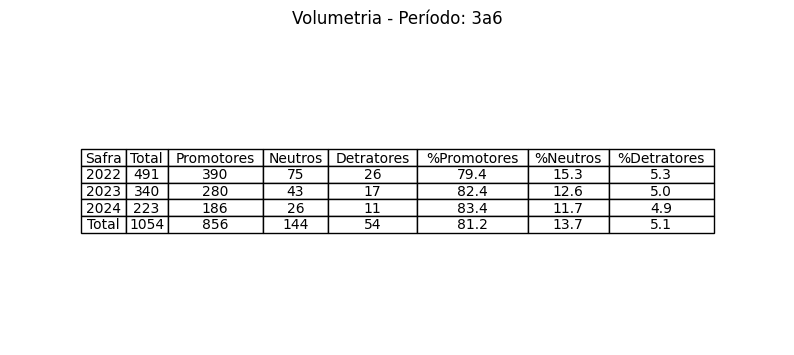

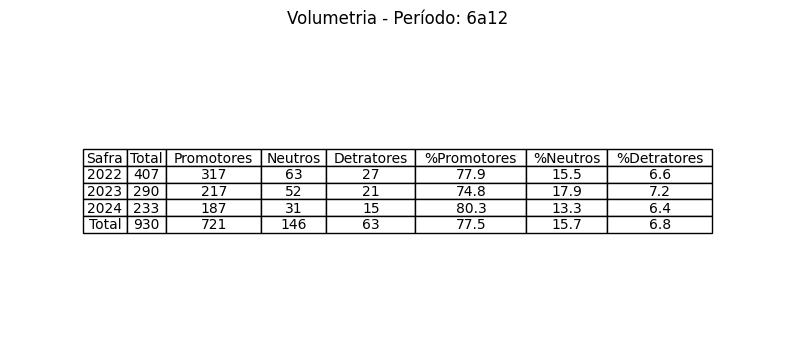

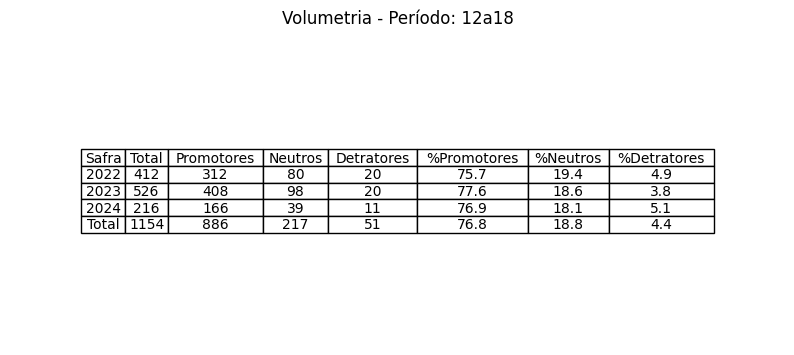

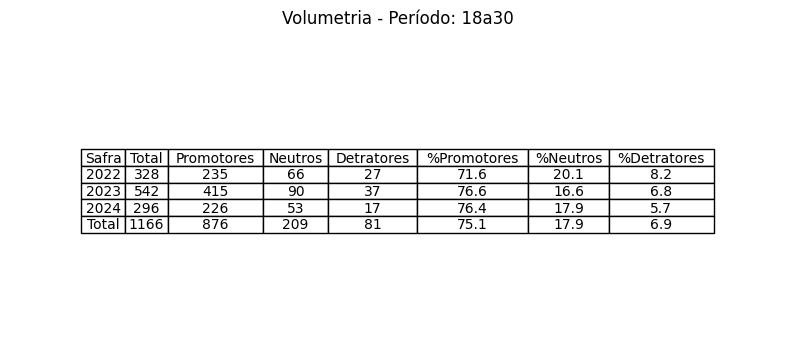

In [ ]:

exibir_tabelas_volumetria_periodos(volumetrias_por_periodo)

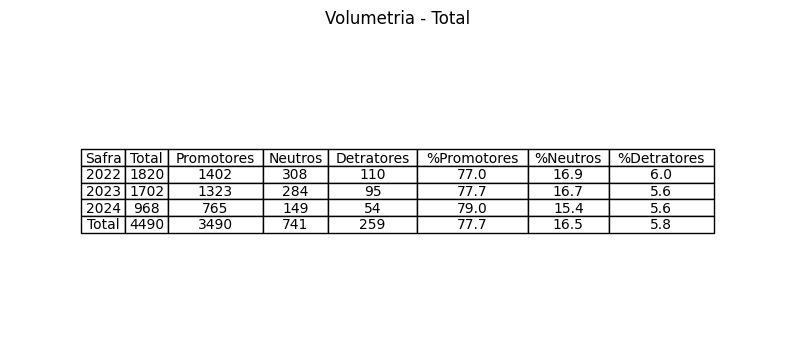

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safraTotal)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Total")

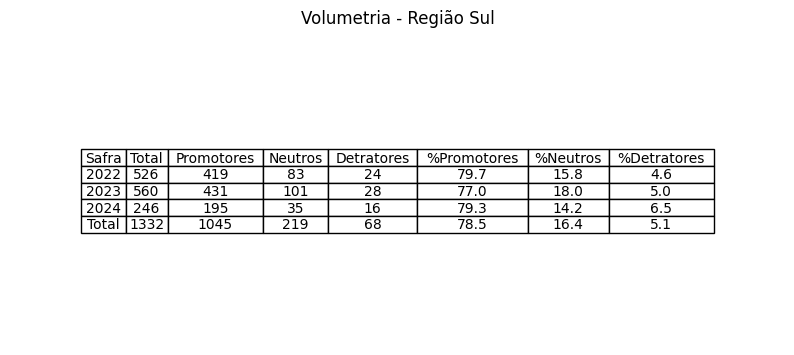

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safra_sul)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Região Sul")


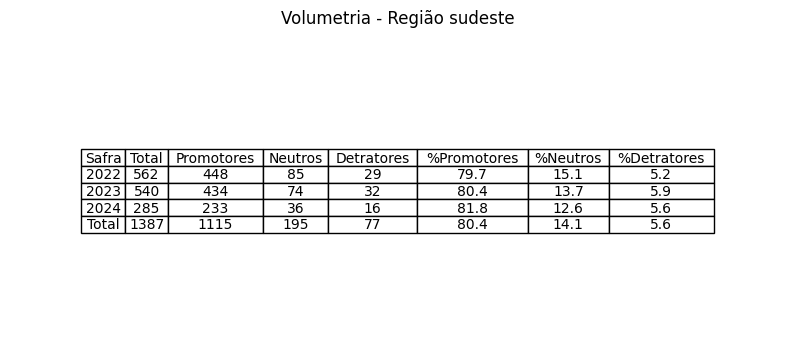

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safra_sudeste)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Região sudeste")


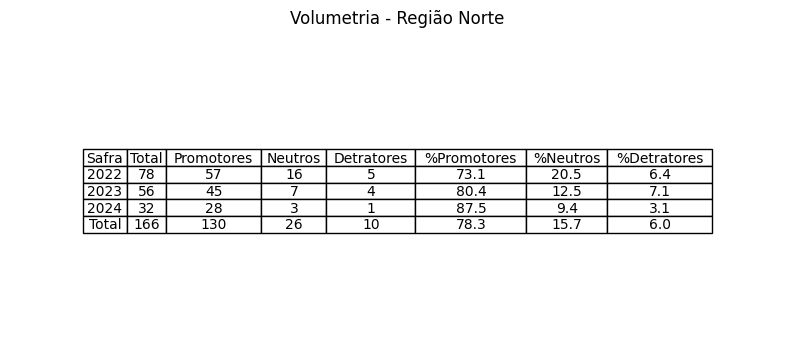

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safra_norte)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Região Norte")


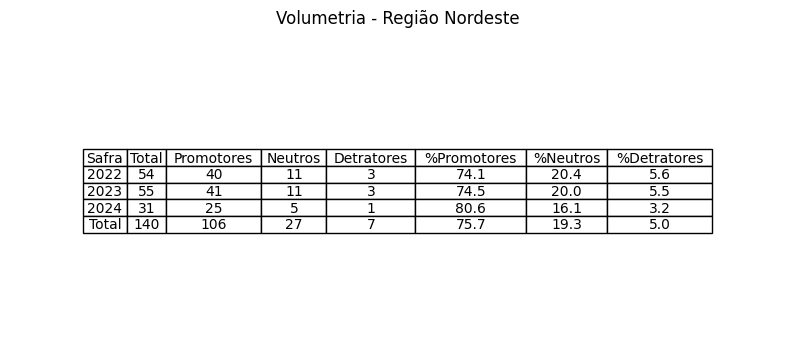

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safra_nordeste)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Região Nordeste")


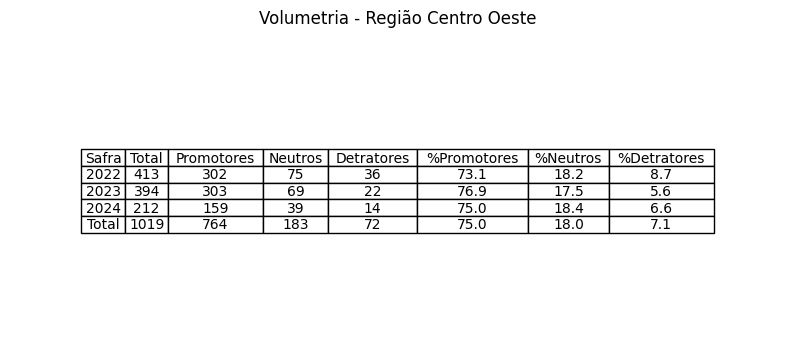

In [ ]:

tabela_volumetria_safra = calcular_volumetria_safrada(safra_centro_oeste)


exibir_tabela_volumetria(tabela_volumetria_safra, titulo="Volumetria - Região Centro Oeste")


# Etapa 9

In [ ]:
correlacao_spearman(df_grupo1, "safraTotal")
criarSafraCorrelacao(df_grupo1, "safraTotal")

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
conforto (csat)                                                             1.000000
facilidad para realizar el mantenimiento (csat)                             1.000000
disponibilidade mecânica (csat)                                             1.000000
ergonomia (csat)                                                            1.000000
confiabilidade mecânica (csat)                                              1.000000
facilidad de operación (csat)                                               0.989071
adaptabilidad a las más diversas condiciones de...                          0.956522
disponibilidad mecánica y fiabilidad (csat)                                 0.836163
idoneidad para diferentes operaciones e impleme...                          0.836163
costo de mantenimiento (csat)                                               0.802955
generación y

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 adequação as diversas operações e implementos (...                          0.665951
 disponibilidade e confiabilidade mecânica  (csat)                           0.664674
 capacidade operacional (hectares por hora) (csat)                           0.662023
 adaptabilidade as mais diversas condições de tr...                          0.647496
 facilidade de operação (csat)                                               0.634536
 facilidade para realização de manutenções (csat)                            0.614760
 geração e transmissão de dados para gestão agrí...                          0.605879
 geração e transmissão de dados para gestão da f...                          0.601796
 conforto e ergonomia (csat)                                                 0.572119
 facilidade de uso do piloto automático (csat)                               0.525596
 consumo de combustível (litros por hectares) (c

In [ ]:
correlacao_spearman(sul, "sul")
criarSafraCorrelacao(sul, "sul")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
¿está satisfecho con la calidad del producto? (...                          0.770953
como você avalia a qualidade e a confiabilidade...                          0.658166
adequação as diversas operações e implementos (...                          0.618972
disponibilidade e confiabilidade mecânica  (csat)                           0.617556
capacidade operacional (hectares por hora) (csat)                           0.608347
facilidade de operação (csat)                                               0.597067
facilidade para realização de manutenções (csat)                            0.592464
adaptabilidade as mais diversas condições de tr...                          0.582069
agora, considere características específicas do...                          0.567948
geração e transmissão de dados para gestão da f...                          0.540500
geração e tr

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 disponibilidade e confiabilidade mecânica  (csat)                           0.655179
 capacidade operacional (hectares por hora) (csat)                           0.646708
 adequação as diversas operações e implementos (...                          0.632376
 facilidade de operação (csat)                                               0.610294
 adaptabilidade as mais diversas condições de tr...                          0.610172
 facilidade para realização de manutenções (csat)                            0.604610
 geração e transmissão de dados para gestão agrí...                          0.522376
 geração e transmissão de dados para gestão da f...                          0.521465
 conforto e ergonomia (csat)                                                 0.517285
 facilidade de uso do piloto automático (csat)                               0.468722
 custo de manutenção (csat)                     

In [ ]:
correlacao_spearman(norte, "norte")
criarSafraCorrelacao(norte, "norte")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
¿está satisfecho con la calidad del producto? (...                          1.000000
capacidade operacional (hectares por hora) (csat)                           0.642847
adequação as diversas operações e implementos (...                          0.637569
disponibilidade e confiabilidade mecânica  (csat)                           0.636273
agora, considere características específicas do...                          0.570691
facilidade para realização de manutenções (csat)                            0.565876
facilidade de operação (csat)                                               0.563595
adaptabilidade as mais diversas condições de tr...                          0.558190
geração e transmissão de dados para gestão da f...                          0.544582
como você avalia o conforto e a ergonomia do se...                          0.513013
geração e tr

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 adequação as diversas operações e implementos (...                          0.680558
 disponibilidade e confiabilidade mecânica  (csat)                           0.638769
 facilidade para realização de manutenções (csat)                            0.611755
 capacidade operacional (hectares por hora) (csat)                           0.603364
 facilidade de operação (csat)                                               0.568587
 geração e transmissão de dados para gestão da f...                          0.554001
 facilidade de uso do piloto automático (csat)                               0.547683
 adaptabilidade as mais diversas condições de tr...                          0.543725
 conforto e ergonomia (csat)                                                 0.460724
 geração e transmissão de dados para gestão agrí...                          0.460544
 consumo de combustível (litros por hectares) (c

In [ ]:
correlacao_spearman(nordeste, "nordeste")
criarSafraCorrelacao(nordeste, "nordeste")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
como você avalia a qualidade e a confiabilidade...                          0.807881
geração e transmissão de dados para gestão agrí...                          0.718079
agora, considere características específicas do...                          0.703353
geração e transmissão de dados para gestão da f...                          0.650315
disponibilidade e confiabilidade mecânica  (csat)                           0.645244
facilidade de uso do piloto automático (csat)                               0.614949
adequação as diversas operações e implementos (...                          0.610789
facilidade de operação (csat)                                               0.591459
facilidade para realização de manutenções (csat)                            0.579224
capacidade operacional (hectares por hora) (csat)                           0.534674
consumo de c

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2022 ###

                                                    Spearman Correlation with "nota"
geração e transmissão de dados para gestão agrí...                          0.776991
adequação as diversas operações e implementos (...                          0.734061
geração e transmissão de dados para gestão da f...                          0.683368
facilidade de uso do piloto automático (csat)                               0.681959
capacidade operacional (hectares por hora) (csat)                           0.622626
disponibilidade e confiabilidade mecânica  (csat)                           0.596558
facilidade de operação (csat)                                               0.577596
facilidade para realização de manutenções (csat)                            0.560130
conforto e ergonomia (csat)                                                 0.506591
consumo de combustível (litros por hectares) (c...                          0.494169

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


                                                    Spearman Correlation with "nota"
agora, considere características específicas do...                          1.000000
disponibilidade e confiabilidade mecânica  (csat)                           0.692435
geração e transmissão de dados para gestão agrí...                          0.663365
geração e transmissão de dados para gestão da f...                          0.637283
facilidade para realização de manutenções (csat)                            0.612046
facilidade de operação (csat)                                               0.604954
consumo de combustível (litros por hectares) (c...                          0.565390
facilidade de uso do piloto automático (csat)                               0.532273
conforto e ergonomia (ao operar o equipamento n...                          0.489687
custo de manutenção (csat)                                                  0.485552
adaptabilidade as mais diversas condições de tr...               

{2022:                                                     Spearman Correlation with "nota"
 geração e transmissão de dados para gestão agrí...                          0.776991
 adequação as diversas operações e implementos (...                          0.734061
 geração e transmissão de dados para gestão da f...                          0.683368
 facilidade de uso do piloto automático (csat)                               0.681959
 capacidade operacional (hectares por hora) (csat)                           0.622626
 disponibilidade e confiabilidade mecânica  (csat)                           0.596558
 facilidade de operação (csat)                                               0.577596
 facilidade para realização de manutenções (csat)                            0.560130
 conforto e ergonomia (csat)                                                 0.506591
 consumo de combustível (litros por hectares) (c...                          0.494169
 custo de manutenção (csat)                     

In [ ]:
correlacao_spearman(sudeste, "sudeste")
criarSafraCorrelacao(sudeste, "sudeste")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
idoneidad para diferentes operaciones e impleme...                          1.000000
capacidad operativa (hectáreas por hora) (csat)                             1.000000
generación y transmisión de datos para la gesti...                          1.000000
facilidad de uso del piloto automático (csat)                               1.000000
adaptabilidad a las más diversas condiciones de...                          1.000000
disponibilidad mecánica y fiabilidad (csat)                                 1.000000
facilidad de operación (csat)                                               1.000000
generación y transmisión de datos para la gesti...                          1.000000
costo de mantenimiento (csat)                                               1.000000
facilidad para realizar el mantenimiento. (csat)                            1.000000
consumo de c

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2023 ###

                                                    Spearman Correlation with "nota"
idoneidad para diferentes operaciones e impleme...                          1.000000
capacidad operativa (hectáreas por hora) (csat)                             1.000000
generación y transmisión de datos para la gesti...                          1.000000
facilidad de uso del piloto automático (csat)                               1.000000
adaptabilidad a las más diversas condiciones de...                          1.000000
disponibilidad mecánica y fiabilidad (csat)                                 1.000000
facilidad de operación (csat)                                               1.000000
generación y transmisión de datos para la gesti...                          1.000000
costo de mantenimiento (csat)                                               1.000000
facilidad para realizar el mantenimiento. (csat)                            1.000000

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 adaptabilidade as mais diversas condições de tr...                          0.690608
 capacidade operacional (hectares por hora) (csat)                           0.663616
 adequação as diversas operações e implementos (...                          0.649888
 disponibilidade e confiabilidade mecânica  (csat)                           0.638701
 facilidade de operação (csat)                                               0.636045
 facilidade para realização de manutenções (csat)                            0.627519
 geração e transmissão de dados para gestão da f...                          0.619308
 geração e transmissão de dados para gestão agrí...                          0.616246
 conforto e ergonomia (csat)                                                 0.565508
 consumo de combustível (litros por hectares) (c...                          0.527630
 custo de manutenção (csat)                     

In [ ]:
correlacao_spearman(centro_oeste, "centro_oeste")
criarSafraCorrelacao(centro_oeste, "centro_oeste")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
capacidade operacional (hectares por hora) (csat)                           0.670822
adequação as diversas operações e implementos (...                          0.657439
como você avalia a qualidade e a confiabilidade...                          0.655217
disponibilidade e confiabilidade mecânica  (csat)                           0.650433
adaptabilidade as mais diversas condições de tr...                          0.647638
geração e transmissão de dados para gestão agrí...                          0.620258
facilidade de operação (csat)                                               0.618766
¿está satisfecho con la calidad del producto? (...                          0.614115
geração e transmissão de dados para gestão da f...                          0.604323
agora, considere características específicas do...                          0.600879
facilidade p

{2022:                                                     Spearman Correlation with "nota"
 adequação as diversas operações e implementos (...                          0.687806
 disponibilidade e confiabilidade mecânica  (csat)                           0.673695
 facilidade de operação (csat)                                               0.670561
 capacidade operacional (hectares por hora) (csat)                           0.670002
 adaptabilidade as mais diversas condições de tr...                          0.652950
 geração e transmissão de dados para gestão agrí...                          0.641857
 geração e transmissão de dados para gestão da f...                          0.615217
 conforto e ergonomia (csat)                                                 0.595663
 facilidade para realização de manutenções (csat)                            0.589676
 custo de manutenção (csat)                                                  0.536729
 consumo de combustível (litros por hectares) (c

In [ ]:
correlacao_spearman(periodos_pesquisa['3a6'], "3a6")
criarSafraCorrelacao(periodos_pesquisa['3a6'], "3a6")

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_c


### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
capacidade operacional (hectares por hora) (csat)                           0.648378
adaptabilidade as mais diversas condições de tr...                          0.645629
como você avalia a qualidade e a confiabilidade...                          0.642354
facilidade de operação (csat)                                               0.640201
adequação as diversas operações e implementos (...                          0.627241
disponibilidade e confiabilidade mecânica  (csat)                           0.610967
geração e transmissão de dados para gestão da f...                          0.609492
agora, considere características específicas do...                          0.601892
geração e transmissão de dados para gestão agrí...                          0.593297
facilidade para realização de manutenções (csat)                            0.589033
conforto e e

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 capacidade operacional (hectares por hora) (csat)                           0.684671
 facilidade de operação (csat)                                               0.671849
 adaptabilidade as mais diversas condições de tr...                          0.668478
 disponibilidade e confiabilidade mecânica  (csat)                           0.667400
 adequação as diversas operações e implementos (...                          0.648731
 facilidade para realização de manutenções (csat)                            0.631271
 conforto e ergonomia (csat)                                                 0.626555
 geração e transmissão de dados para gestão da f...                          0.619442
 geração e transmissão de dados para gestão agrí...                          0.595151
 custo de manutenção (csat)                                                  0.511657
 consumo de combustível (litros por hectares) (c

In [ ]:
correlacao_spearman(periodos_pesquisa['6a12'], "6a12")
criarSafraCorrelacao(periodos_pesquisa['6a12'], "6a12")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)
<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
adaptabilidad a las más diversas condiciones de...                          1.000000
consumo de combustible (litros por hectárea) (c...                          1.000000
facilidad de operación (csat)                                               1.000000
facilidad para realizar el mantenimiento (csat)                             1.000000
costo de mantenimiento (csat)                                               1.000000
capacidad operativa (hectáreas por hora) (csat)                             0.866025
idoneidad para diferentes operaciones e impleme...                          0.866025
disponibilidad mecánica y fiabilidad (csat)                                 0.866025
como você avalia a qualidade e a confiabilidade...                          0.722941
agora, considere características específicas do...                          0.668612
disponibilid

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2023 ###

                                                    Spearman Correlation with "nota"
adaptabilidad a las más diversas condiciones de...                          1.000000
consumo de combustible (litros por hectárea) (c...                          1.000000
facilidad de operación (csat)                                               1.000000
facilidad para realizar el mantenimiento (csat)                             1.000000
costo de mantenimiento (csat)                                               1.000000
capacidad operativa (hectáreas por hora) (csat)                             0.866025
idoneidad para diferentes operaciones e impleme...                          0.866025
disponibilidad mecánica y fiabilidad (csat)                                 0.866025
capacidade operacional (hectares por hora) (csat)                           0.655569
disponibilidade e confiabilidade mecânica  (csat)                           0.644535

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 disponibilidade e confiabilidade mecânica  (csat)                           0.670813
 geração e transmissão de dados para gestão agrí...                          0.645450
 geração e transmissão de dados para gestão da f...                          0.643178
 adequação as diversas operações e implementos (...                          0.632142
 adaptabilidade as mais diversas condições de tr...                          0.631664
 facilidade de operação (csat)                                               0.619085
 facilidade para realização de manutenções (csat)                            0.612044
 capacidade operacional (hectares por hora) (csat)                           0.610454
 conforto e ergonomia (csat)                                                 0.545205
 facilidade de uso do piloto automático (csat)                               0.527413
 custo de manutenção (csat)                     

In [ ]:
correlacao_spearman(periodos_pesquisa['12a18'], "12a18")
criarSafraCorrelacao(periodos_pesquisa['12a18'], "12a18")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
¿está satisfecho con la calidad del producto? (...                          0.679290
capacidade operacional (hectares por hora) (csat)                           0.662726
como você avalia a qualidade e a confiabilidade...                          0.653004
disponibilidade e confiabilidade mecânica  (csat)                           0.649393
adequação as diversas operações e implementos (...                          0.643764
adaptabilidade as mais diversas condições de tr...                          0.638962
agora, considere características específicas do...                          0.612161
conforto e ergonomia (csat)                                                 0.589574
facilidade de operação (csat)                                               0.588018
facilidade para realização de manutenções (csat)                            0.584248
geração e tr

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2022 ###

                                                    Spearman Correlation with "nota"
adequação as diversas operações e implementos (...                          0.704647
capacidade operacional (hectares por hora) (csat)                           0.695028
disponibilidade e confiabilidade mecânica  (csat)                           0.676057
adaptabilidade as mais diversas condições de tr...                          0.671427
facilidade para realização de manutenções (csat)                            0.626470
geração e transmissão de dados para gestão agrí...                          0.606502
facilidade de operação (csat)                                               0.604126
geração e transmissão de dados para gestão da f...                          0.597672
conforto e ergonomia (csat)                                                 0.575467
facilidade de uso do piloto automático (csat)                               0.532544

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2023 ###

                                                    Spearman Correlation with "nota"
capacidade operacional (hectares por hora) (csat)                           0.635579
disponibilidade e confiabilidade mecânica  (csat)                           0.627112
conforto e ergonomia (csat)                                                 0.618820
adaptabilidade as mais diversas condições de tr...                          0.609997
¿está satisfecho con la calidad del producto? (...                          0.600340
adequação as diversas operações e implementos (...                          0.594465
facilidade de operação (csat)                                               0.574363
geração e transmissão de dados para gestão da f...                          0.549646
facilidade para realização de manutenções (csat)                            0.548493
geração e transmissão de dados para gestão agrí...                          0.546889

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 adequação as diversas operações e implementos (...                          0.704647
 capacidade operacional (hectares por hora) (csat)                           0.695028
 disponibilidade e confiabilidade mecânica  (csat)                           0.676057
 adaptabilidade as mais diversas condições de tr...                          0.671427
 facilidade para realização de manutenções (csat)                            0.626470
 geração e transmissão de dados para gestão agrí...                          0.606502
 facilidade de operação (csat)                                               0.604126
 geração e transmissão de dados para gestão da f...                          0.597672
 conforto e ergonomia (csat)                                                 0.575467
 facilidade de uso do piloto automático (csat)                               0.532544
 consumo de combustível (litros por hectares) (c

In [ ]:
correlacao_spearman(periodos_pesquisa['18a30'], "18a30")
criarSafraCorrelacao(periodos_pesquisa['18a30'], "18a30")

<ipython-input-5-16174dc9529c>:338: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' ###

                                                    Spearman Correlation with "nota"
como você avalia a qualidade e a confiabilidade...                          0.672479
adequação as diversas operações e implementos (...                          0.671164
disponibilidade e confiabilidade mecânica  (csat)                           0.632141
capacidade operacional (hectares por hora) (csat)                           0.631250
facilidade de operação (csat)                                               0.608974
adaptabilidade as mais diversas condições de tr...                          0.607637
facilidade para realização de manutenções (csat)                            0.601006
agora, considere características específicas do...                          0.573805
geração e transmissão de dados para gestão agrí...                          0.566562
geração e transmissão de dados para gestão da f...                          0.565512
conforto e e

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2022 ###

                                                    Spearman Correlation with "nota"
adequação as diversas operações e implementos (...                          0.716624
facilidade de operação (csat)                                               0.679639
capacidade operacional (hectares por hora) (csat)                           0.661066
disponibilidade e confiabilidade mecânica  (csat)                           0.654554
adaptabilidade as mais diversas condições de tr...                          0.646082
facilidade para realização de manutenções (csat)                            0.581751
conforto e ergonomia (csat)                                                 0.573893
geração e transmissão de dados para gestão agrí...                          0.549078
geração e transmissão de dados para gestão da f...                          0.537242
facilidade de uso do piloto automático (csat)                               0.530715

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)



### CORRELAÇÃO DE SPEARMAN COM A COLUNA 'NOTA' - SAFRA 2023 ###

                                                    Spearman Correlation with "nota"
como você avalia a qualidade e a confiabilidade...                          0.702018
adequação as diversas operações e implementos (...                          0.642544
agora, considere características específicas do...                          0.640731
disponibilidade e confiabilidade mecânica  (csat)                           0.617463
facilidade para realização de manutenções (csat)                            0.613847
capacidade operacional (hectares por hora) (csat)                           0.609308
geração e transmissão de dados para gestão da f...                          0.588543
geração e transmissão de dados para gestão agrí...                          0.585654
adaptabilidade as mais diversas condições de tr...                          0.582750
como você avalia o conforto e a ergonomia do se...                          0.572284

<ipython-input-5-16174dc9529c>:387: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_df_clean = spearman_corr_nota_df_sorted_clean.style.applymap(highlight_correlations)


{2022:                                                     Spearman Correlation with "nota"
 adequação as diversas operações e implementos (...                          0.716624
 facilidade de operação (csat)                                               0.679639
 capacidade operacional (hectares por hora) (csat)                           0.661066
 disponibilidade e confiabilidade mecânica  (csat)                           0.654554
 adaptabilidade as mais diversas condições de tr...                          0.646082
 facilidade para realização de manutenções (csat)                            0.581751
 conforto e ergonomia (csat)                                                 0.573893
 geração e transmissão de dados para gestão agrí...                          0.549078
 geração e transmissão de dados para gestão da f...                          0.537242
 facilidade de uso do piloto automático (csat)                               0.530715
 consumo de combustível (litros por hectares) (c

# Etapa 10 - Criando modelos de classificação

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.97

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 0.87, Classe 1 (Detrator): 0.13
P 2: Classe 0 (Não Detrator): 0.98, Classe 1 (Detrator): 0.02
P 3: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.85

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.41, Classe 1 (Neutro): 0.59
Probalidade 2: Classe 0 (Não Neutro): 0.55, Classe 1 (Neutro): 0.45
Probalidade 3: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 4: Classe 0 (Não Neutro): 0.95, Classe 1 (Neutro): 0.05
Probalidade 5: Classe 0 (Não Neutro): 0.61, Classe 1 (Neutro): 0.39


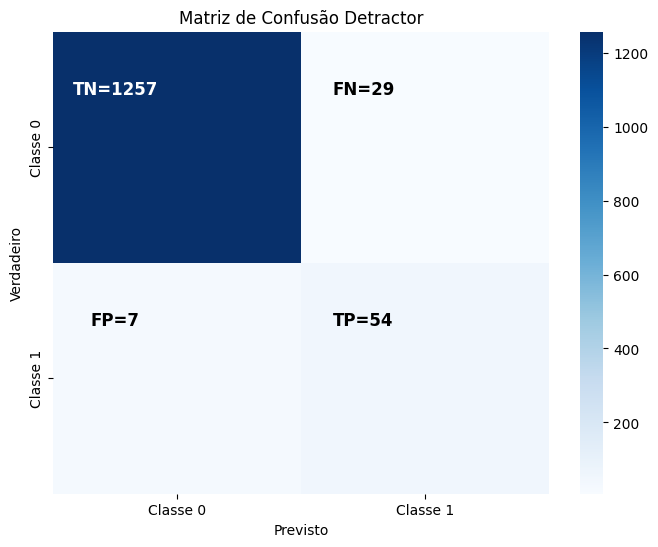

Accuracy Detractor: 0.9733
Precision Detractor: 0.8852
Recall Detractor: 0.6506
F1-Score Detractor: 0.7500


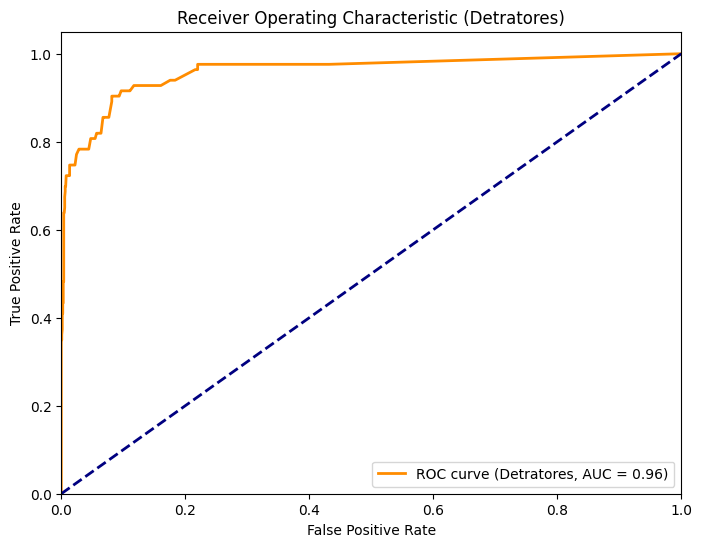

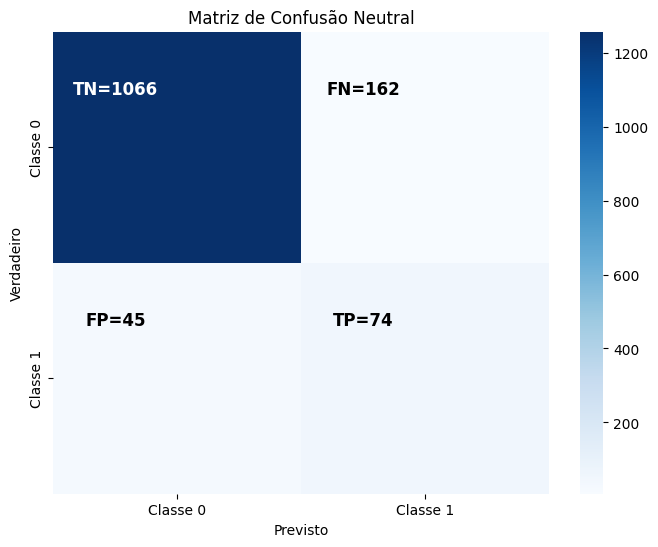

Accuracy Neutral: 0.8463
Precision Neutral: 0.6218
Recall Neutral: 0.3136
F1-Score Neutral: 0.4169


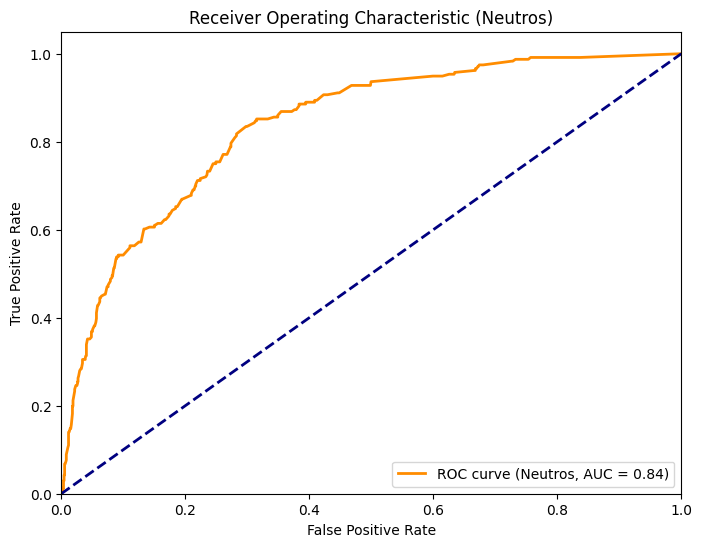






Top 10 variáveis mais importantes para o modelo de detratores:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.12
2. adequação as diversas operações e implementos (csat) - Importância: 0.11
3. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.10
4. capacidade operacional (hectares por hora) (csat) - Importância: 0.09
5. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
6. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.07
7. facilidade para realização de manutenções (csat) - Importância: 0.06
8. facilidade de operação (csat) - Importância: 0.06
9. custo de manutenção (csat) - Importância: 0.05
10. consumo de combustível (litros por hectares) (csat) - Importância: 0.05

Gráficos PDP para o modelo de

<Figure size 800x600 with 0 Axes>

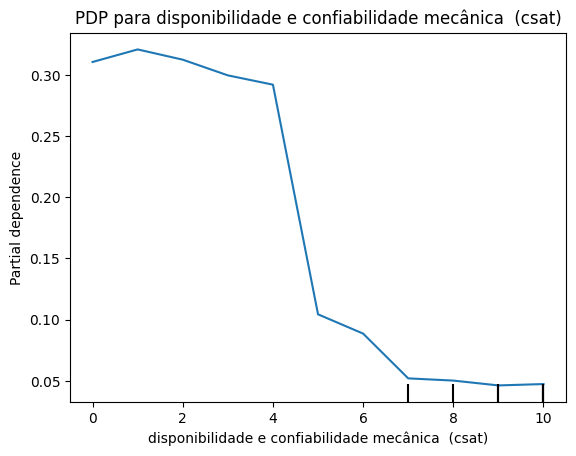

<Figure size 800x600 with 0 Axes>

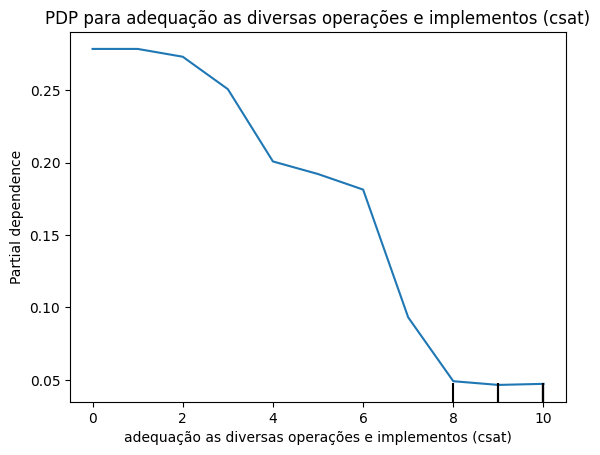

<Figure size 800x600 with 0 Axes>

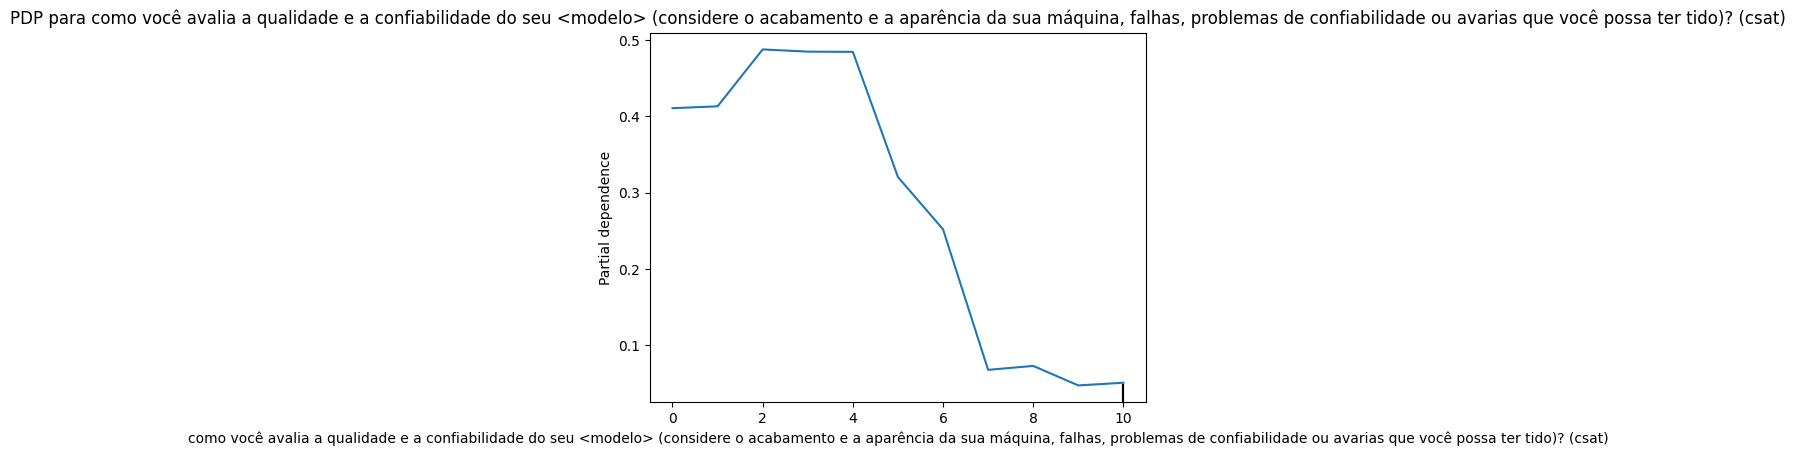

<Figure size 800x600 with 0 Axes>

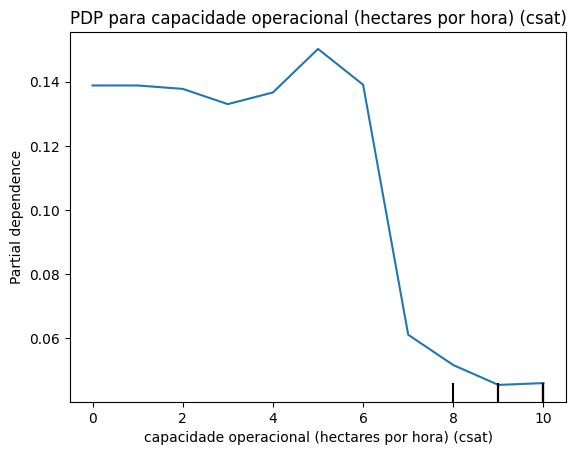

<Figure size 800x600 with 0 Axes>

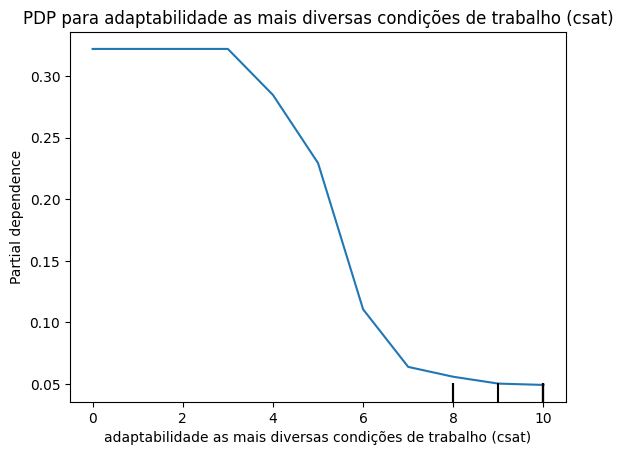






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.10
2. capacidade operacional (hectares por hora) (csat) - Importância: 0.09
3. custo de manutenção (csat) - Importância: 0.08
4. facilidade para realização de manutenções (csat) - Importância: 0.08
5. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
6. consumo de combustível (litros por hectares) (csat) - Importância: 0.07
7. adequação as diversas operações e implementos (csat) - Importância: 0.07
8. facilidade de uso do piloto automático (csat) - Importância: 0.07
9. facilidade de operação (csat) - Importância: 0.06
10. conforto e ergonomia (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.1036
2. capacidade operacional (hectares por hora) (csat) - Importância: 0.0878
3. custo de manutenção (

<Figure size 800x600 with 0 Axes>

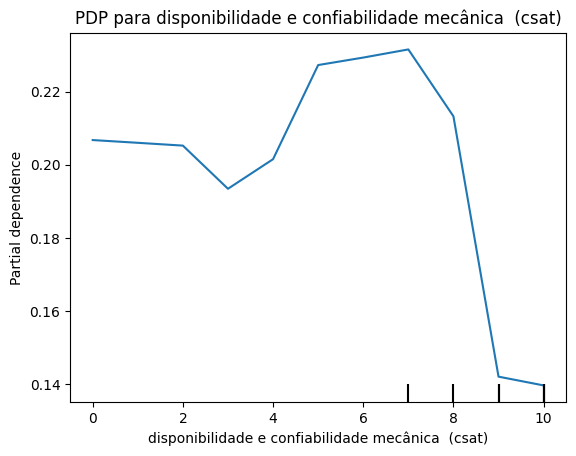

<Figure size 800x600 with 0 Axes>

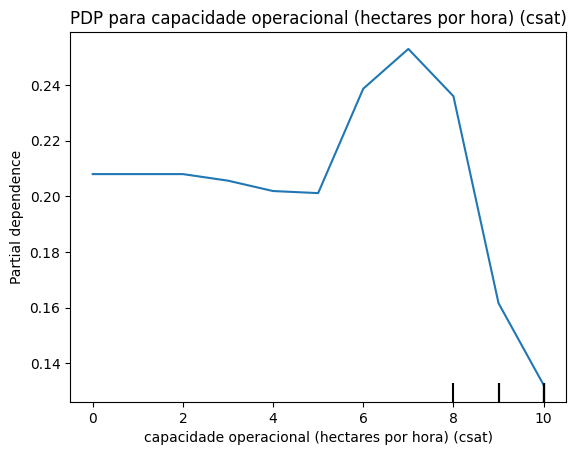

<Figure size 800x600 with 0 Axes>

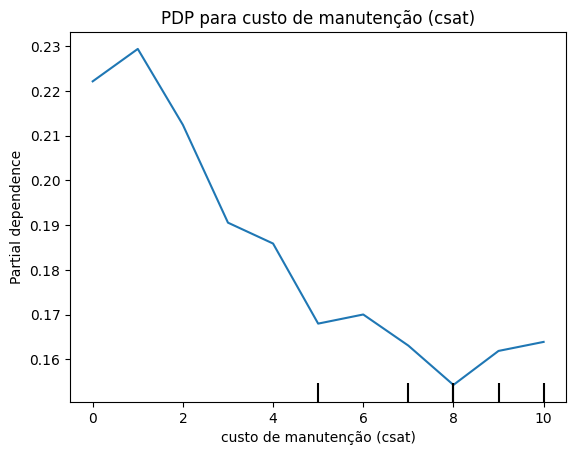

<Figure size 800x600 with 0 Axes>

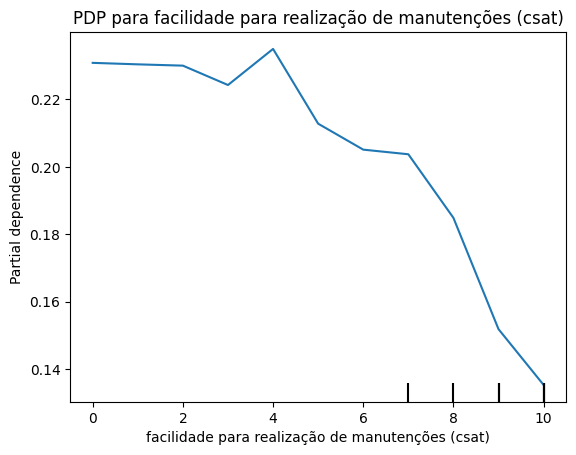

<Figure size 800x600 with 0 Axes>

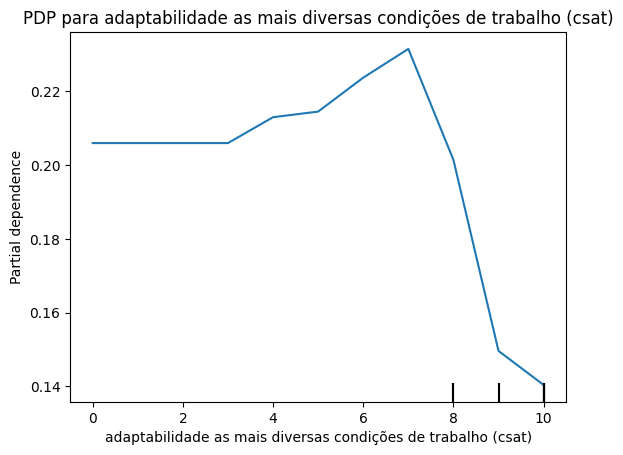

In [ ]:
criarModelo(df_grupo1)

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.97

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 4: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 5: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01

Acurácia do modelo de neutros: 0.86

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.95, Classe 1 (Neutro): 0.05
Probalidade 2: Classe 0 (Não Neutro): 0.64, Classe 1 (Neutro): 0.36
Probalidade 3: Classe 0 (Não Neutro): 0.95, Classe 1 (Neutro): 0.05
Probalidade 4: Classe 0 (Não Neutro): 0.88, Classe 1 (Neutro): 0.12
Probalidade 5: Classe 0 (Não Neutro): 0.35, Classe 1 (Neutro): 0.65


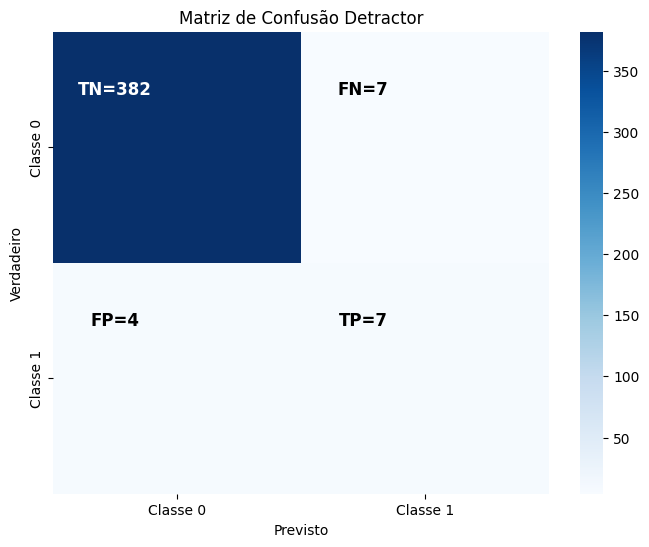

Accuracy Detractor: 0.9725
Precision Detractor: 0.6364
Recall Detractor: 0.5000
F1-Score Detractor: 0.5600


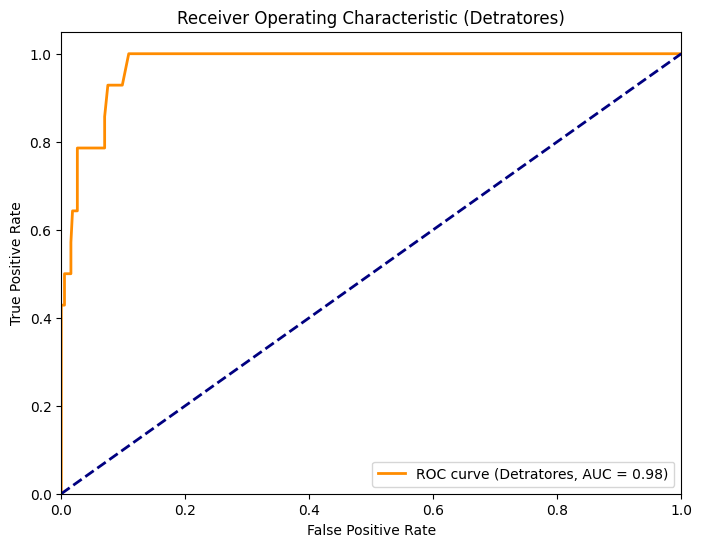

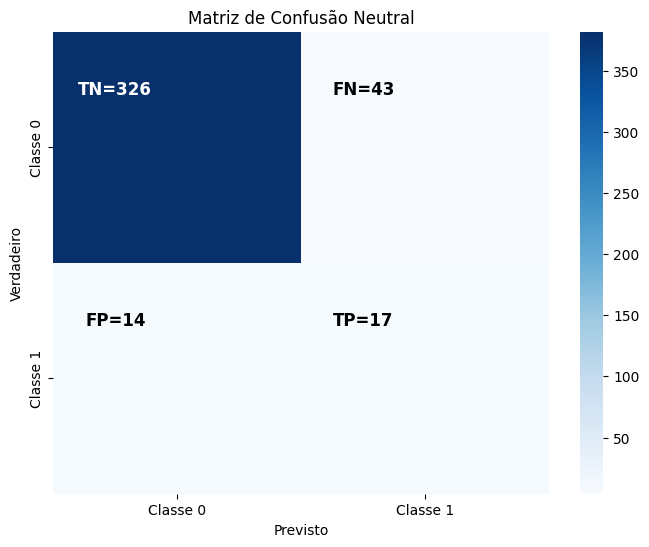

Accuracy Neutral: 0.8575
Precision Neutral: 0.5484
Recall Neutral: 0.2833
F1-Score Neutral: 0.3736


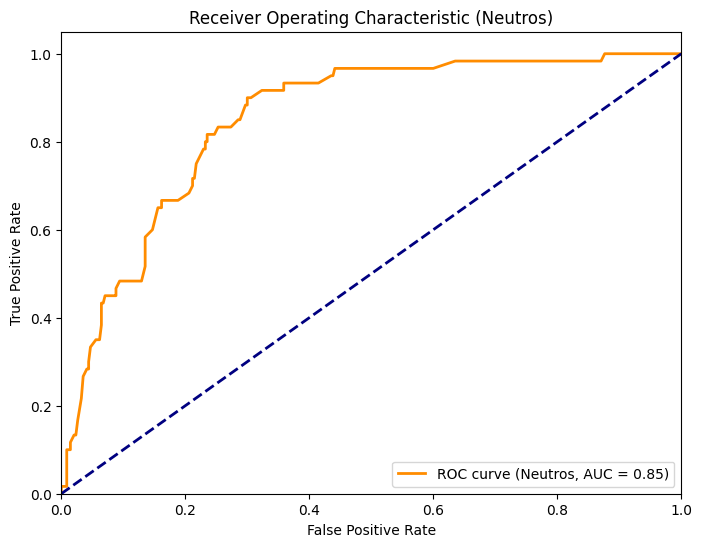






Top 10 variáveis mais importantes para o modelo de detratores:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.12
2. adequação as diversas operações e implementos (csat) - Importância: 0.11
3. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.10
4. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.09
5. capacidade operacional (hectares por hora) (csat) - Importância: 0.09
6. facilidade para realização de manutenções (csat) - Importância: 0.08
7. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
8. conforto e ergonomia (csat) - Importância: 0.05
9. custo de manutenção (csat) - Importância: 0.05
10. consumo de combustível (litros por hectares) (csat) - Importância: 0.05

Gráficos PDP para o modelo de d

<Figure size 800x600 with 0 Axes>

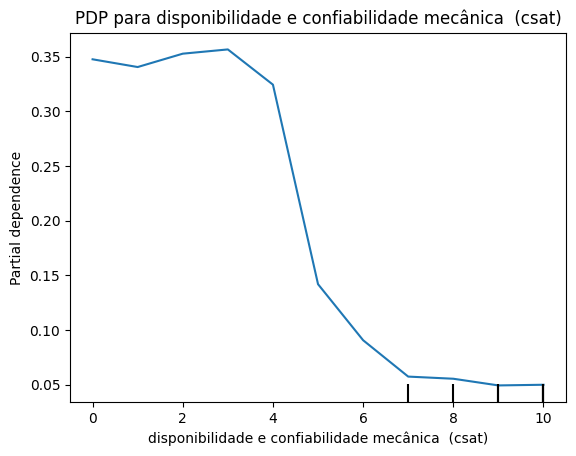

<Figure size 800x600 with 0 Axes>

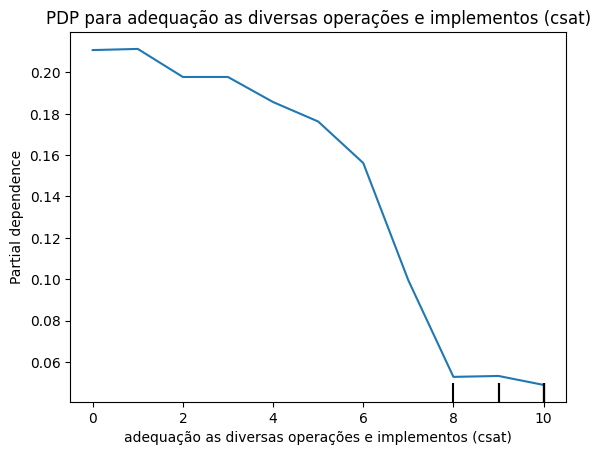

<Figure size 800x600 with 0 Axes>

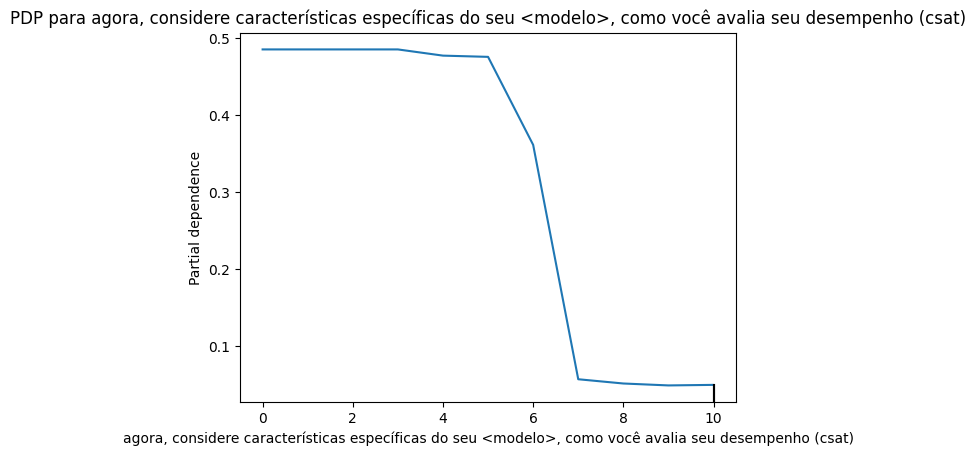

<Figure size 800x600 with 0 Axes>

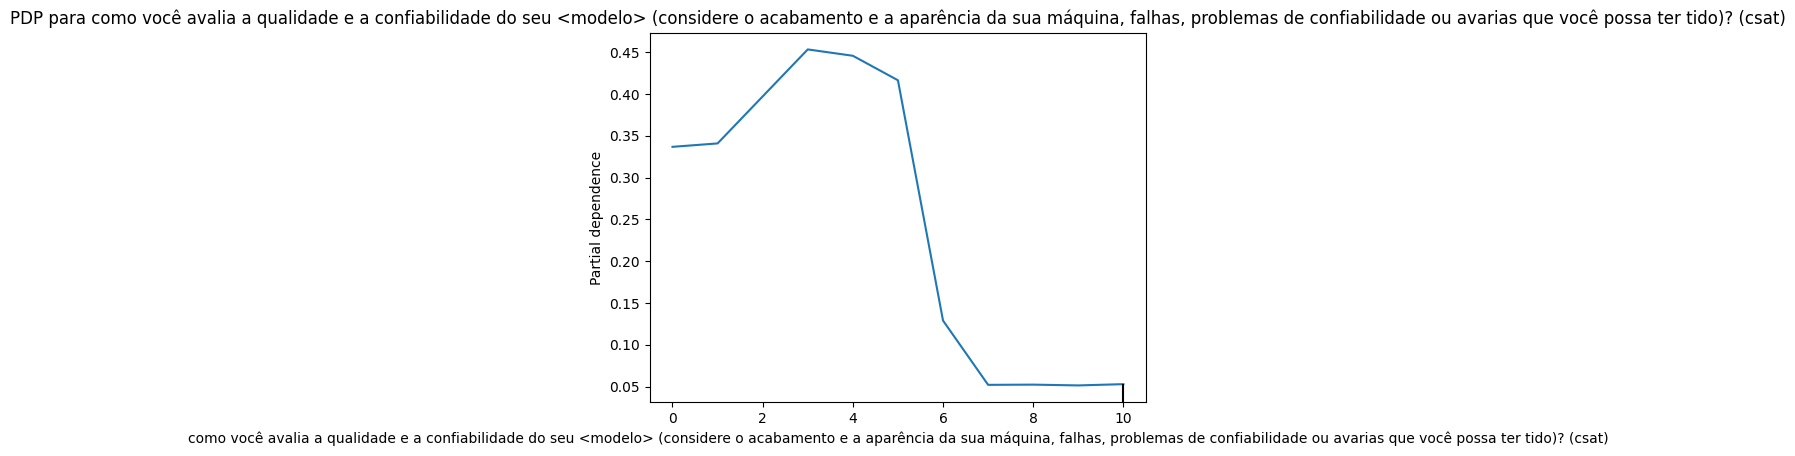

<Figure size 800x600 with 0 Axes>

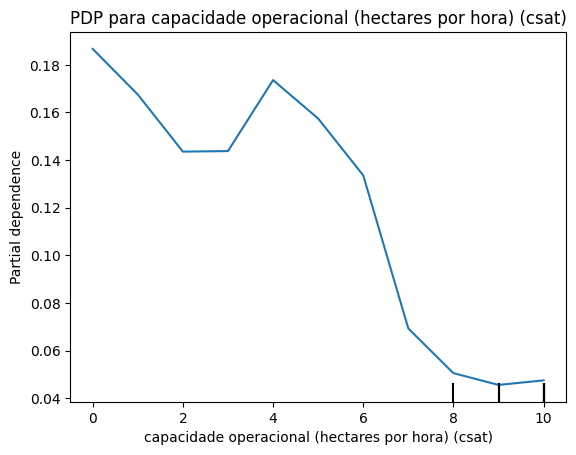






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.09
2. facilidade para realização de manutenções (csat) - Importância: 0.09
3. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
4. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
5. consumo de combustível (litros por hectares) (csat) - Importância: 0.08
6. custo de manutenção (csat) - Importância: 0.08
7. adequação as diversas operações e implementos (csat) - Importância: 0.07
8. facilidade de operação (csat) - Importância: 0.07
9. facilidade de uso do piloto automático (csat) - Importância: 0.06
10. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. d

<Figure size 800x600 with 0 Axes>

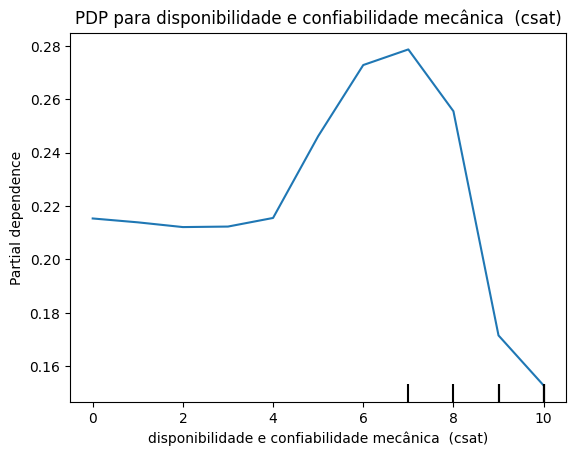

<Figure size 800x600 with 0 Axes>

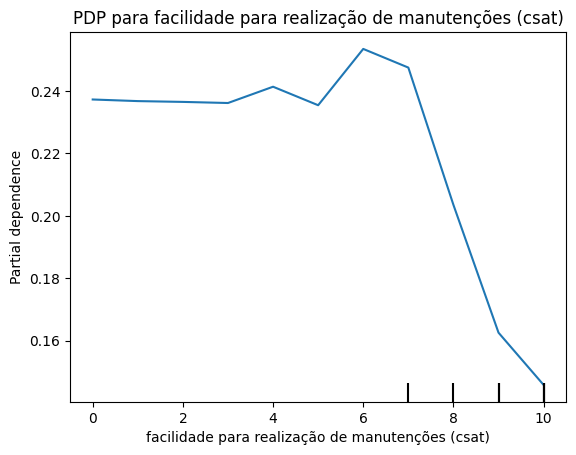

<Figure size 800x600 with 0 Axes>

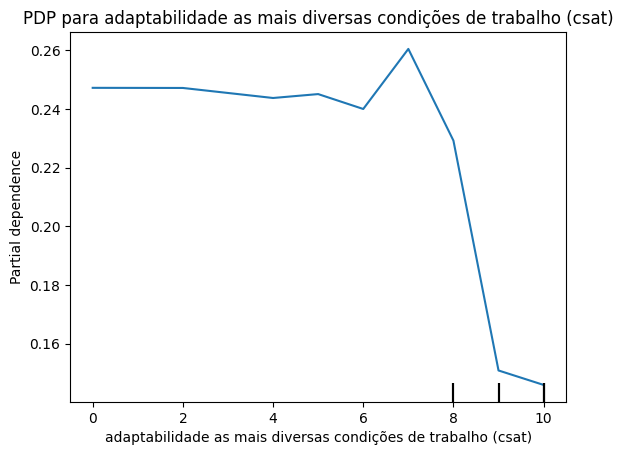

<Figure size 800x600 with 0 Axes>

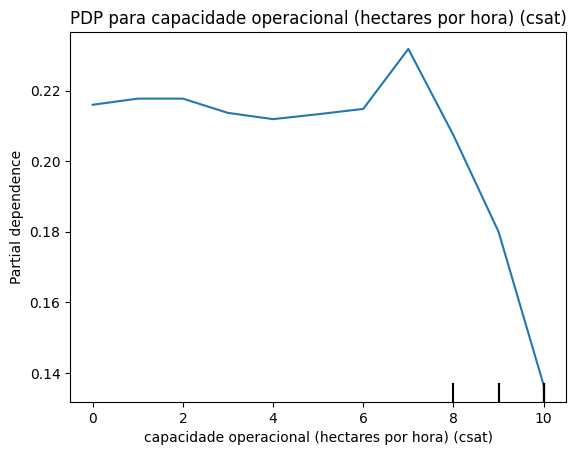

<Figure size 800x600 with 0 Axes>

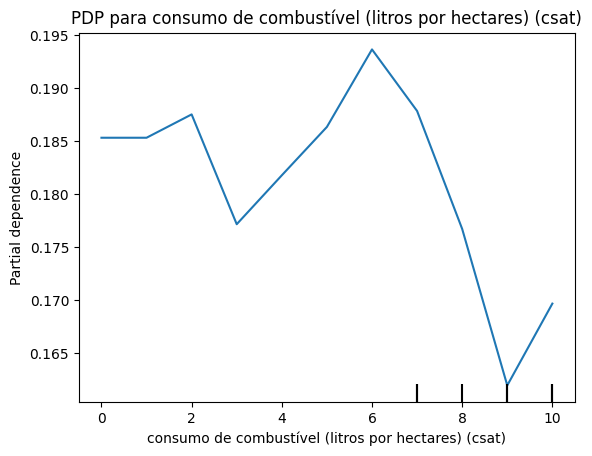

In [ ]:
criarModelo(sul)

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.92

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 0.93, Classe 1 (Detrator): 0.07
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.86

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.69, Classe 1 (Neutro): 0.31
Probalidade 2: Classe 0 (Não Neutro): 0.58, Classe 1 (Neutro): 0.41
Probalidade 3: Classe 0 (Não Neutro): 0.89, Classe 1 (Neutro): 0.11
Probalidade 4: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 5: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00


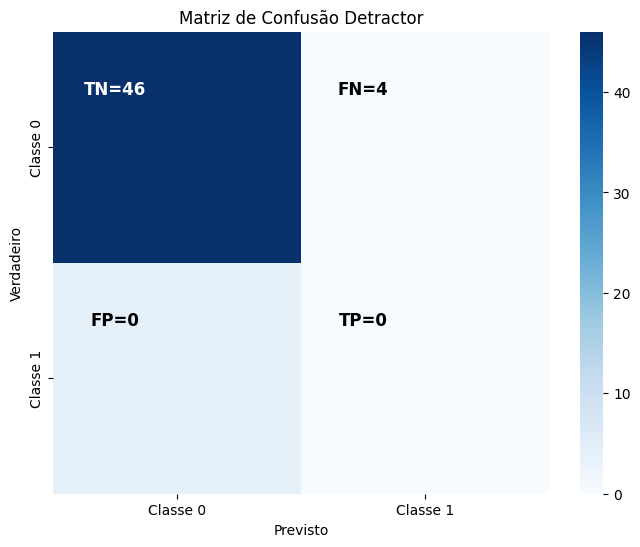

Accuracy Detractor: 0.9200
Precision Detractor: 0.0000
Recall Detractor: 0.0000
F1-Score Detractor: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


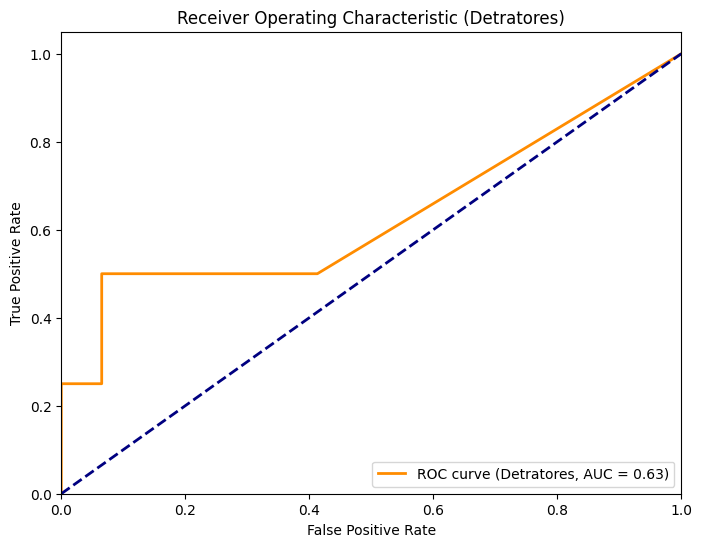

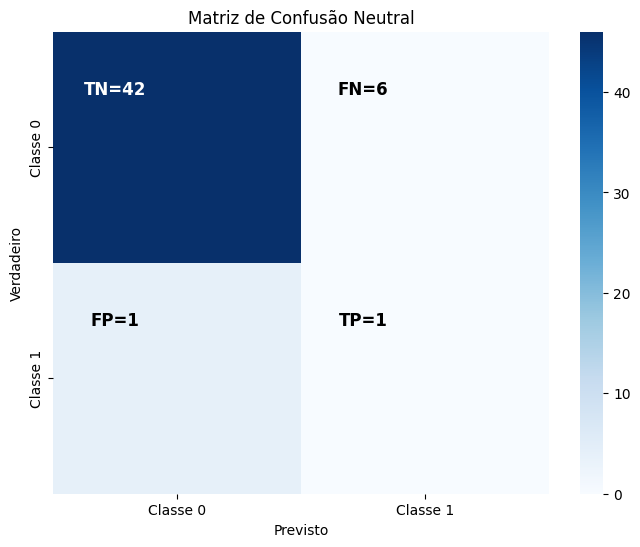

Accuracy Neutral: 0.8600
Precision Neutral: 0.5000
Recall Neutral: 0.1429
F1-Score Neutral: 0.2222


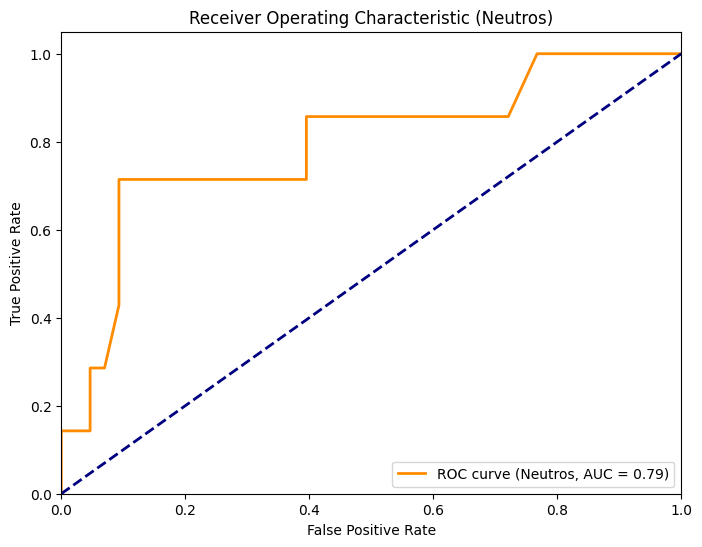






Top 10 variáveis mais importantes para o modelo de detratores:
1. facilidade de uso do piloto automático (csat) - Importância: 0.15
2. adequação as diversas operações e implementos (csat) - Importância: 0.14
3. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.12
4. capacidade operacional (hectares por hora) (csat) - Importância: 0.10
5. consumo de combustível (litros por hectares) (csat) - Importância: 0.09
6. facilidade de operação (csat) - Importância: 0.07
7. conforto e ergonomia (csat) - Importância: 0.07
8. custo de manutenção (csat) - Importância: 0.06
9. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.06
10. geração e transmissão de dados para gestão da frota (csat) - Importância: 0.05

Gráficos PDP para o modelo de detratores:

Top 5 variáveis mais importantes para PDP:
1. facilidade de uso do piloto automático (csat) - Importância: 0.1463
2. adequação as diversas operações e implementos (csat) - Importância: 0.1360
3. dispon

<Figure size 800x600 with 0 Axes>

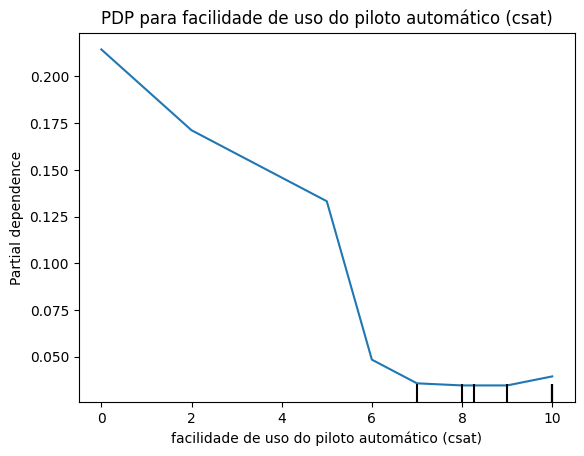

<Figure size 800x600 with 0 Axes>

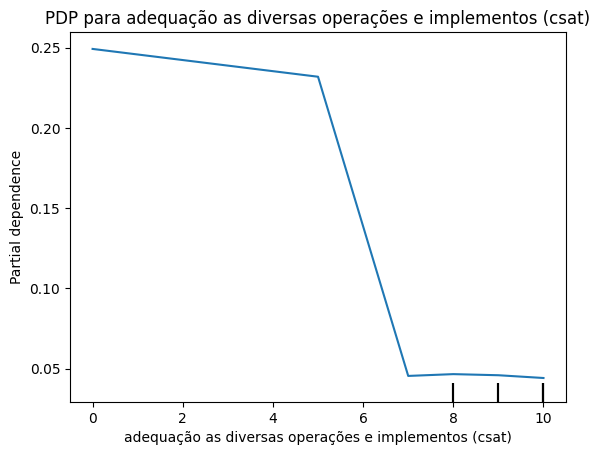

<Figure size 800x600 with 0 Axes>

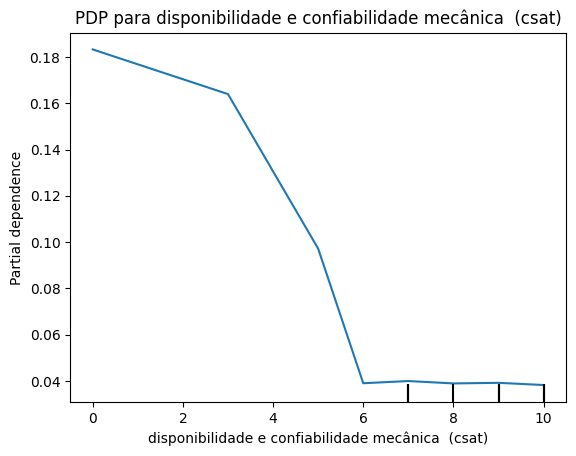

<Figure size 800x600 with 0 Axes>

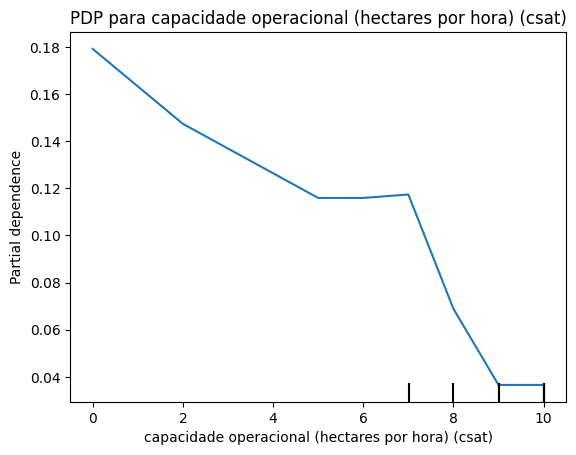

<Figure size 800x600 with 0 Axes>

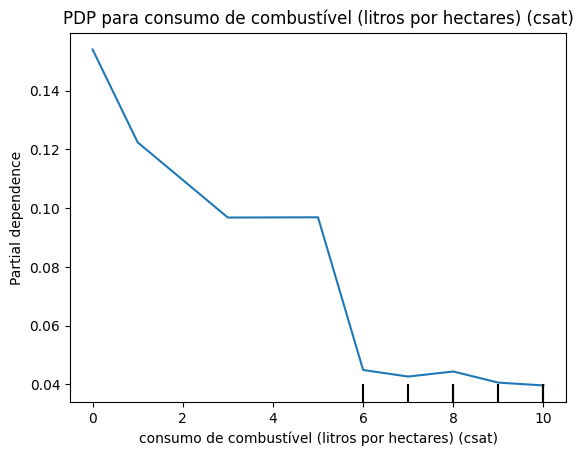






Top 10 variáveis mais importantes para o modelo de neutros:
1. consumo de combustível (litros por hectares) (csat) - Importância: 0.11
2. facilidade de uso do piloto automático (csat) - Importância: 0.10
3. custo de manutenção (csat) - Importância: 0.09
4. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
5. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.08
6. facilidade para realização de manutenções (csat) - Importância: 0.07
7. capacidade operacional (hectares por hora) (csat) - Importância: 0.07
8. adequação as diversas operações e implementos (csat) - Importância: 0.06
9. conforto e ergonomia (csat) - Importância: 0.06
10. geração e transmissão de dados para gestão agrícola (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. consumo de combustível (litros por hectares) (csat) - Importância: 0.1064
2. facilidade de uso do piloto automático (csat) - Importância: 0.09

<Figure size 800x600 with 0 Axes>

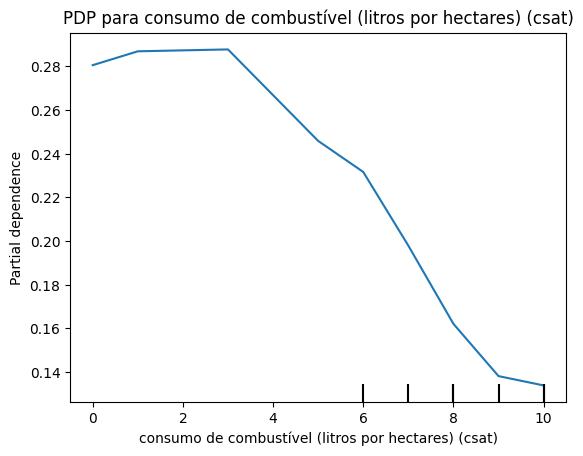

<Figure size 800x600 with 0 Axes>

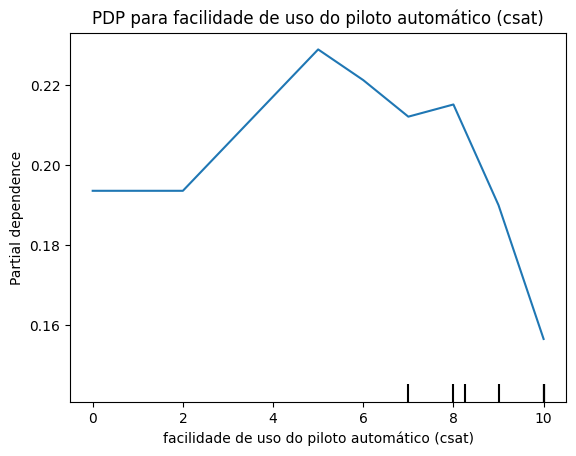

<Figure size 800x600 with 0 Axes>

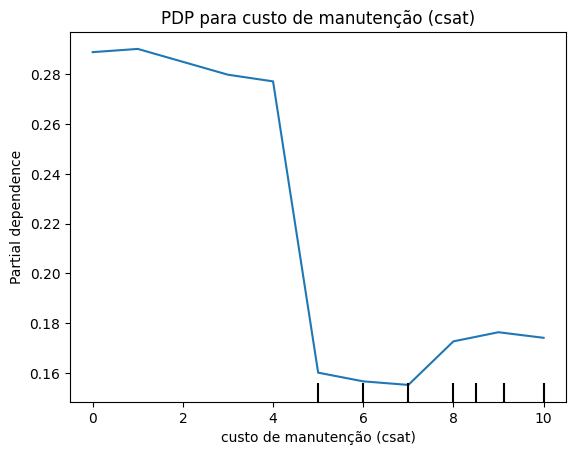

<Figure size 800x600 with 0 Axes>

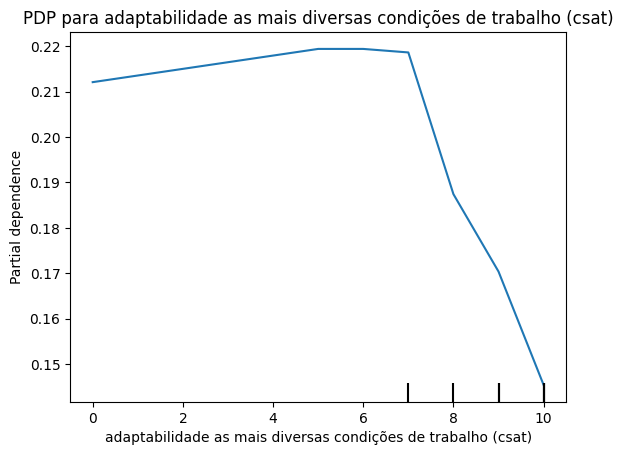

<Figure size 800x600 with 0 Axes>

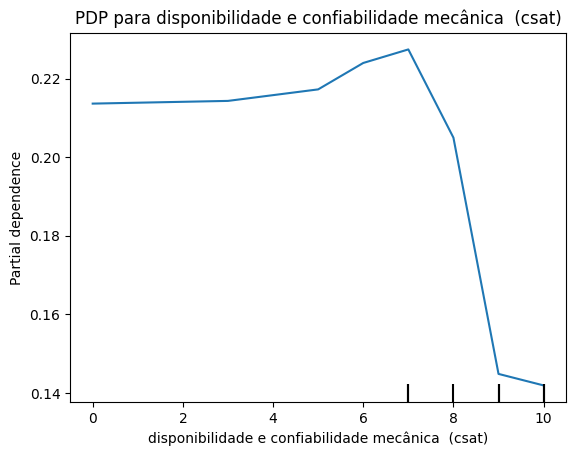

In [ ]:
criarModelo(norte)



<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.96

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.85

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.98, Classe 1 (Neutro): 0.02
Probalidade 2: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 3: Classe 0 (Não Neutro): 0.95, Classe 1 (Neutro): 0.05
Probalidade 4: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 5: Classe 0 (Não Neutro): 0.40, Classe 1 (Neutro): 0.60


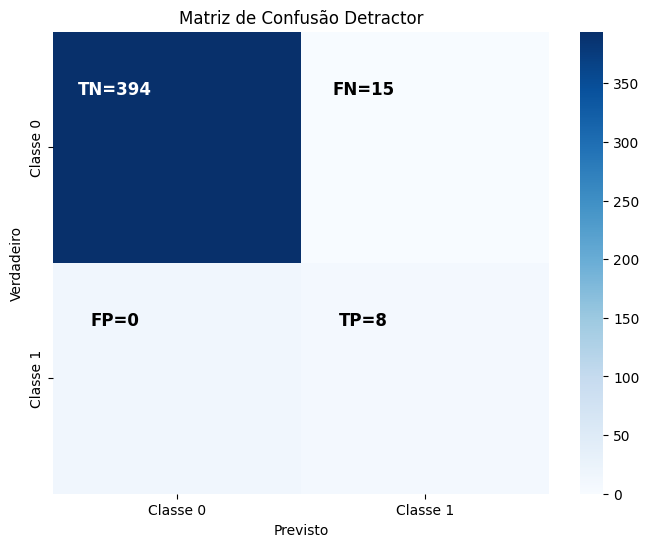

Accuracy Detractor: 0.9640
Precision Detractor: 1.0000
Recall Detractor: 0.3478
F1-Score Detractor: 0.5161


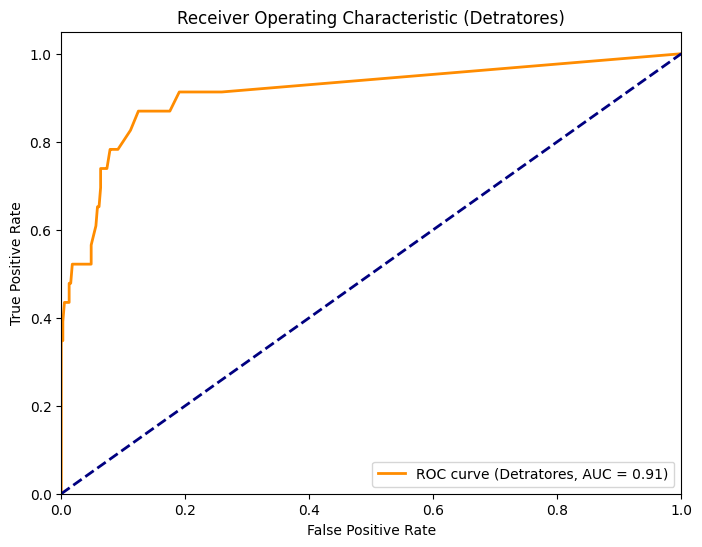

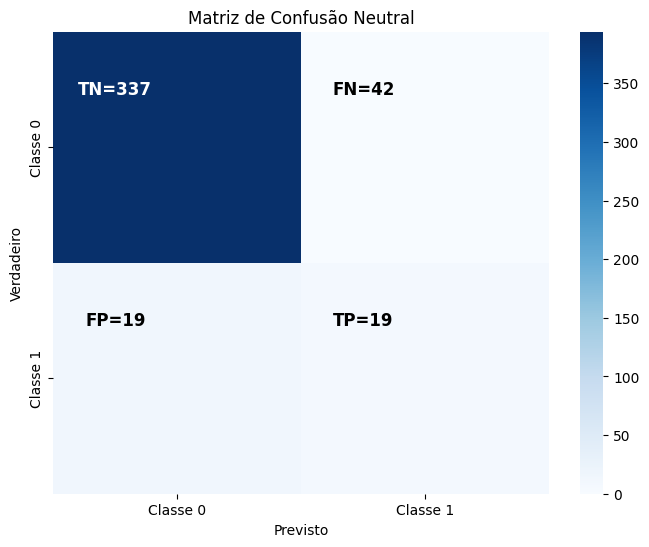

Accuracy Neutral: 0.8537
Precision Neutral: 0.5000
Recall Neutral: 0.3115
F1-Score Neutral: 0.3838


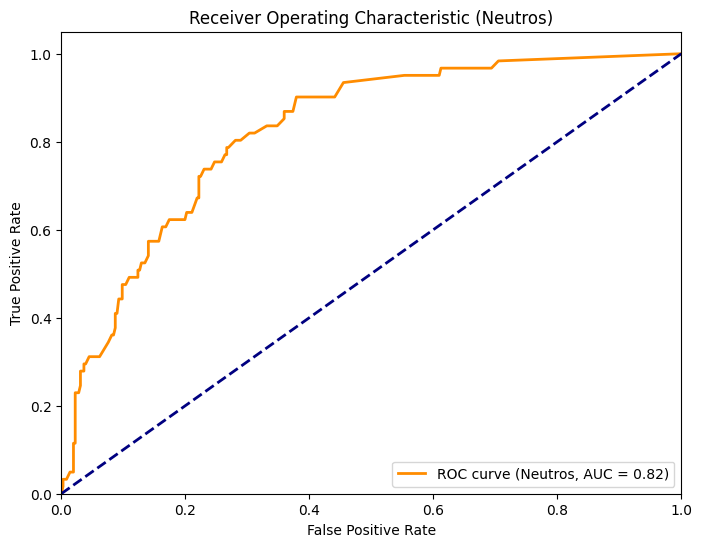






Top 10 variáveis mais importantes para o modelo de detratores:
1. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.13
2. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.10
3. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.10
4. adequação as diversas operações e implementos (csat) - Importância: 0.09
5. facilidade para realização de manutenções (csat) - Importância: 0.07
6. capacidade operacional (hectares por hora) (csat) - Importância: 0.07
7. facilidade de operação (csat) - Importância: 0.07
8. custo de manutenção (csat) - Importância: 0.06
9. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.06
10. consumo de combustível (litros por hectares) (csat) - Importância: 0.06

Gráficos PDP para o modelo de

<Figure size 800x600 with 0 Axes>

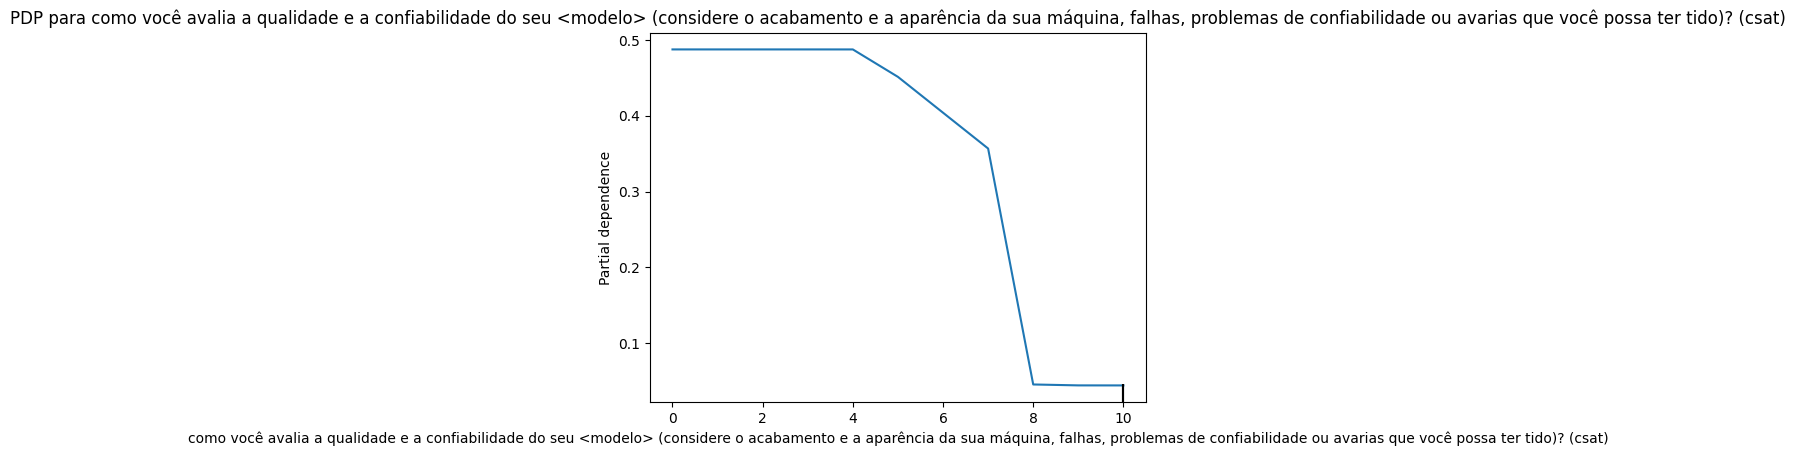

<Figure size 800x600 with 0 Axes>

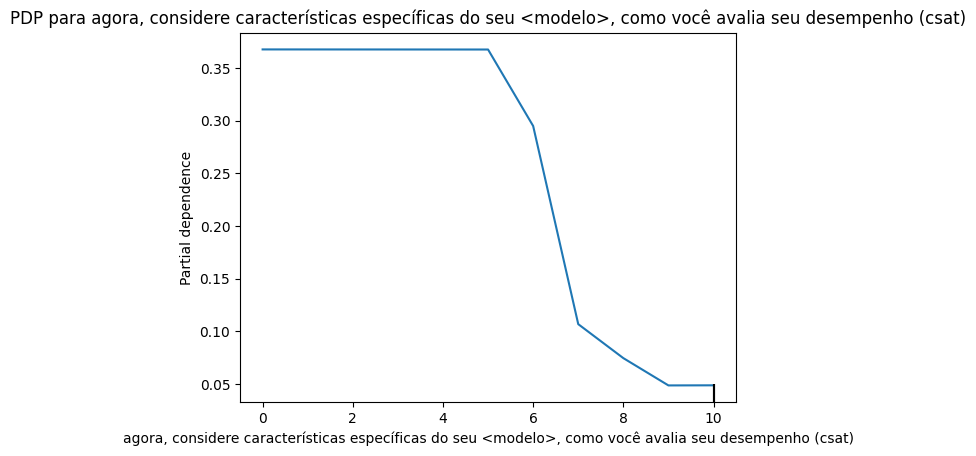

<Figure size 800x600 with 0 Axes>

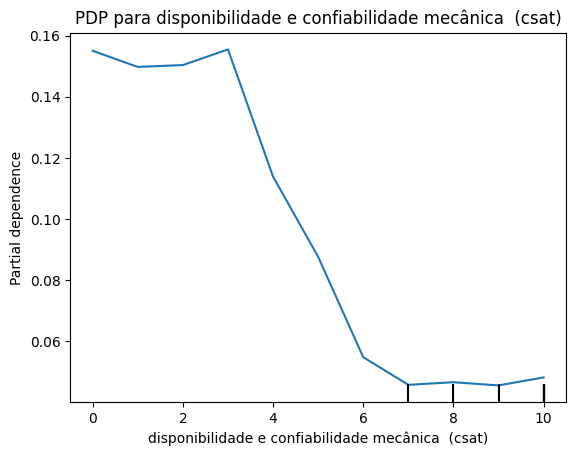

<Figure size 800x600 with 0 Axes>

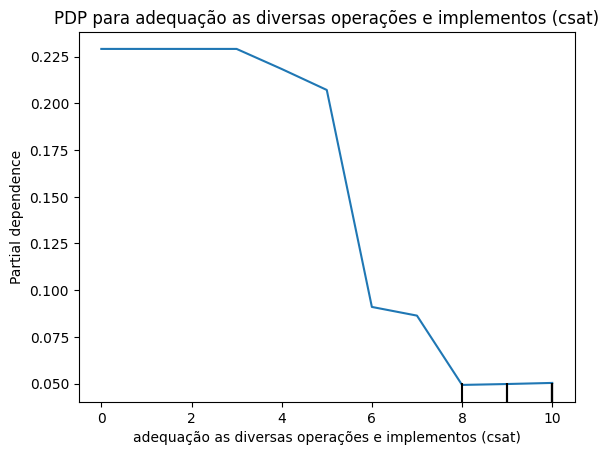

<Figure size 800x600 with 0 Axes>

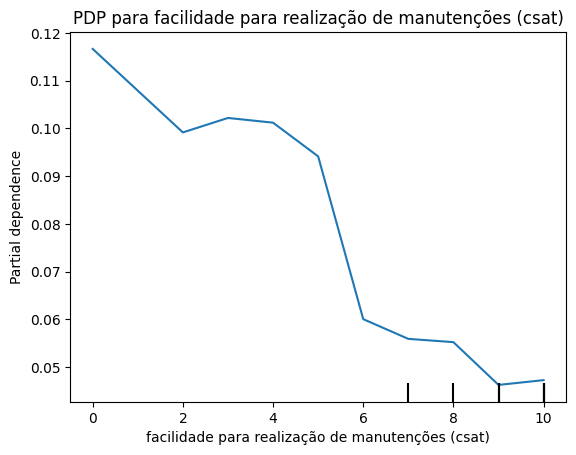






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.10
2. capacidade operacional (hectares por hora) (csat) - Importância: 0.09
3. custo de manutenção (csat) - Importância: 0.09
4. facilidade para realização de manutenções (csat) - Importância: 0.09
5. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
6. consumo de combustível (litros por hectares) (csat) - Importância: 0.08
7. facilidade de uso do piloto automático (csat) - Importância: 0.07
8. adequação as diversas operações e implementos (csat) - Importância: 0.07
9. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.06
10. conforto e ergonomia (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. dis

<Figure size 800x600 with 0 Axes>

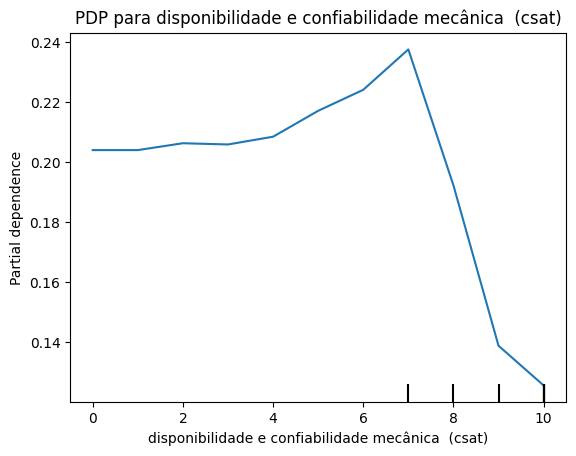

<Figure size 800x600 with 0 Axes>

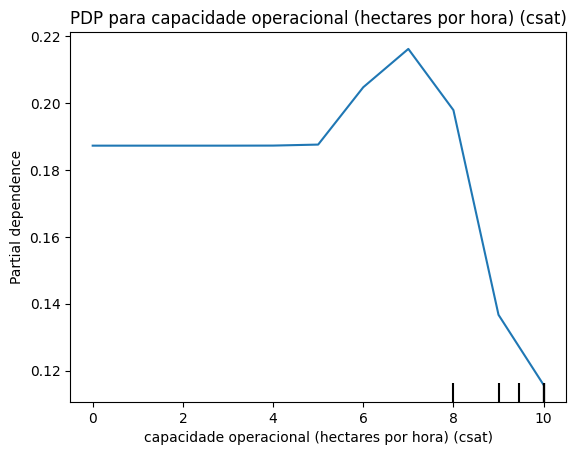

<Figure size 800x600 with 0 Axes>

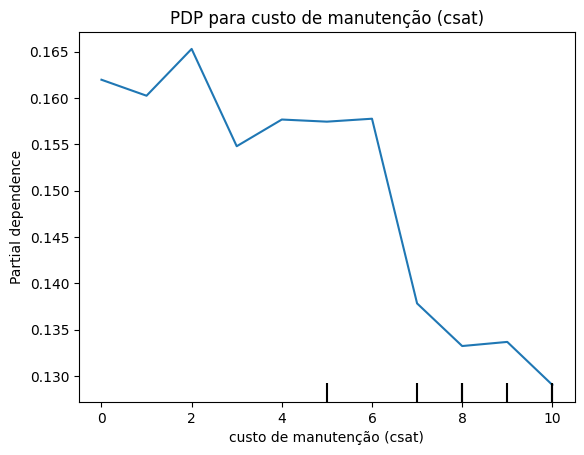

<Figure size 800x600 with 0 Axes>

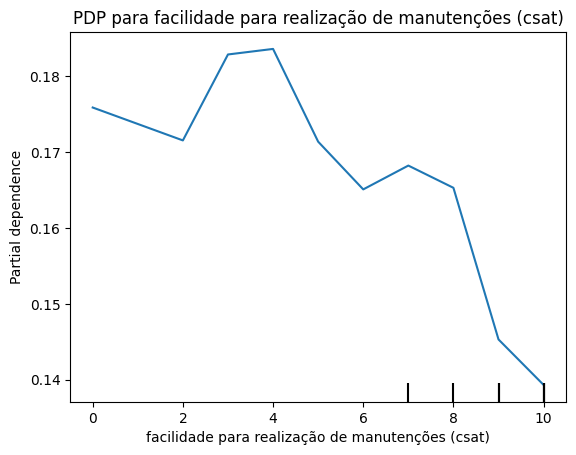

<Figure size 800x600 with 0 Axes>

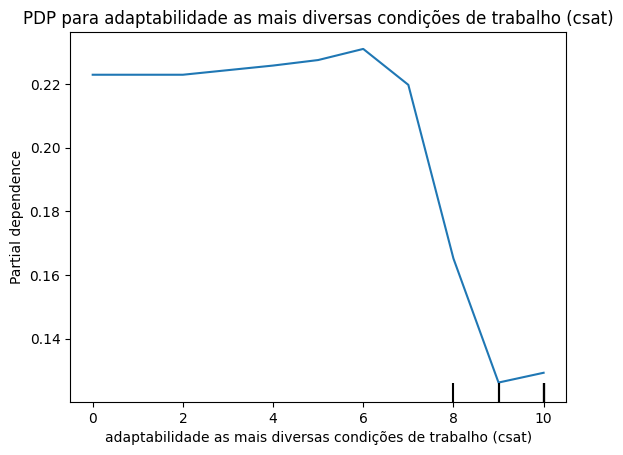

In [ ]:
criarModelo(sudeste)

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 1.00

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 0.80, Classe 1 (Detrator): 0.20
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.86

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.62, Classe 1 (Neutro): 0.38
Probalidade 2: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 3: Classe 0 (Não Neutro): 0.60, Classe 1 (Neutro): 0.40
Probalidade 4: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 5: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00


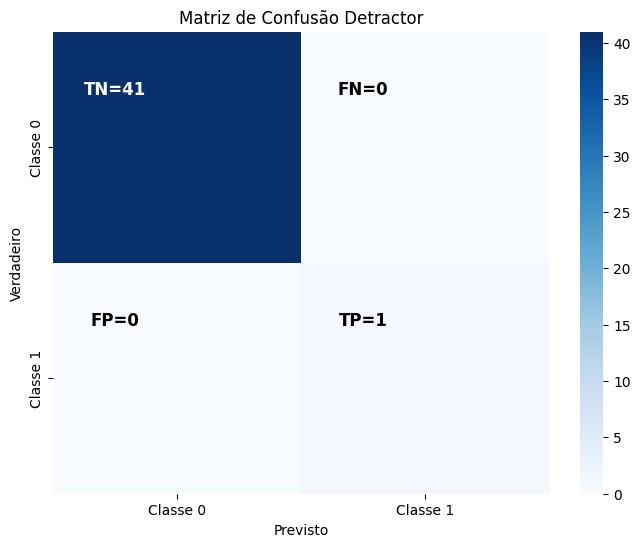

Accuracy Detractor: 1.0000
Precision Detractor: 1.0000
Recall Detractor: 1.0000
F1-Score Detractor: 1.0000


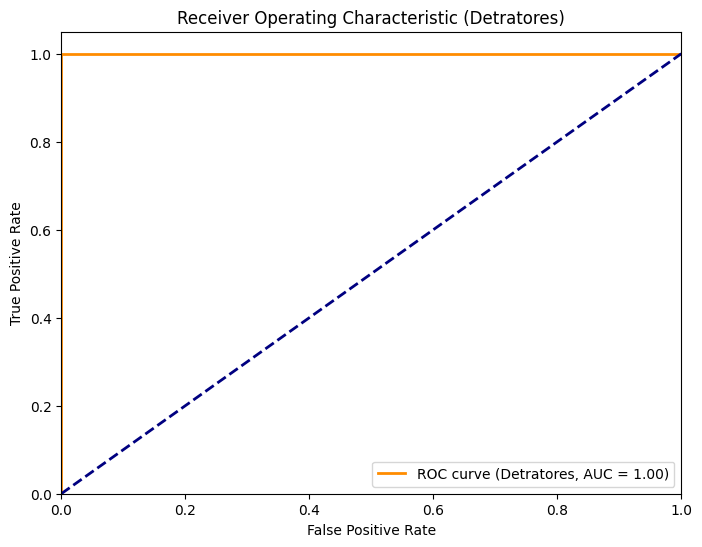

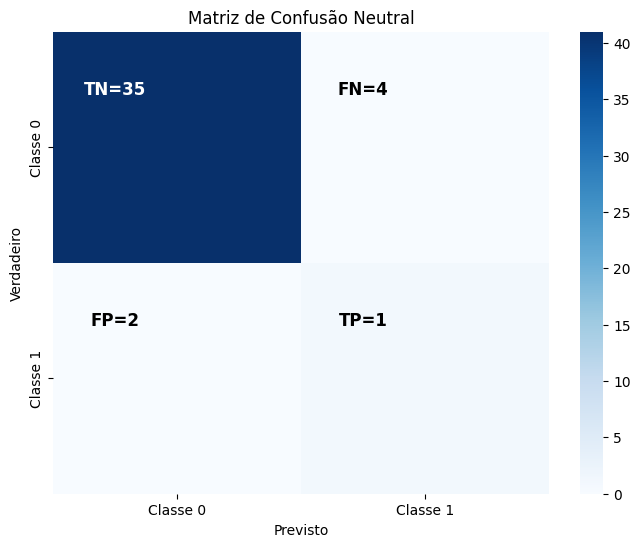

Accuracy Neutral: 0.8571
Precision Neutral: 0.3333
Recall Neutral: 0.2000
F1-Score Neutral: 0.2500


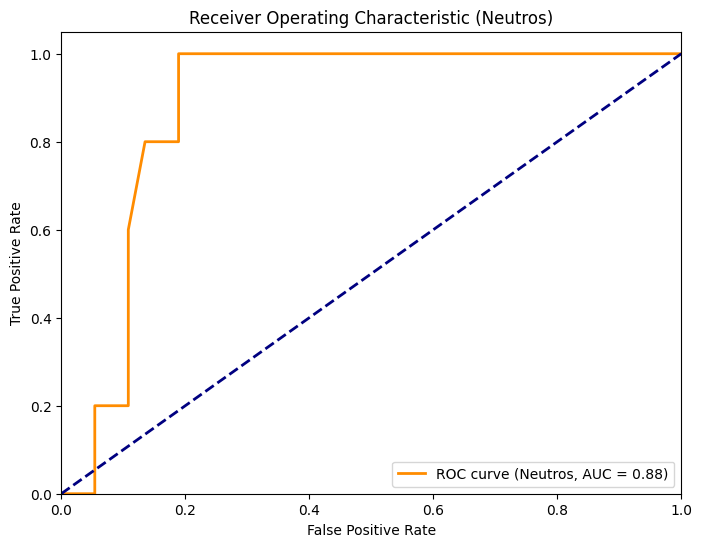






Top 10 variáveis mais importantes para o modelo de detratores:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.13
2. facilidade para realização de manutenções (csat) - Importância: 0.11
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.11
4. custo de manutenção (csat) - Importância: 0.10
5. facilidade de operação (csat) - Importância: 0.08
6. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.08
7. como você avalia o conforto e a ergonomia do seu <modelo>  (considere, por exemplo, o conforto do assento, a visibilidade da cabine, a compreensão e o layout dos controles)? (csat) - Importância: 0.08
8. adequação as diversas operações e implementos (csat) - Importância: 0.07
9. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.06
10. facilidade de uso do p

<Figure size 800x600 with 0 Axes>

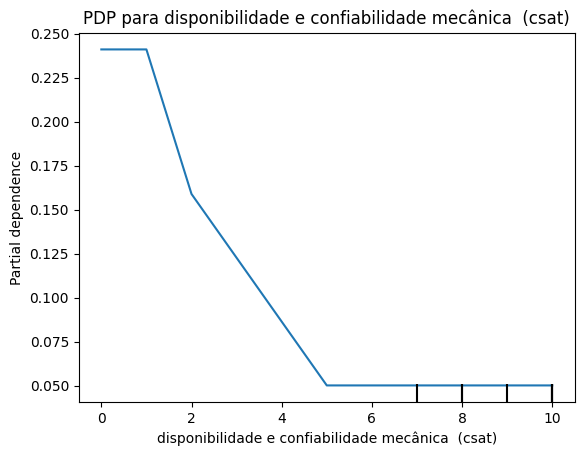

<Figure size 800x600 with 0 Axes>

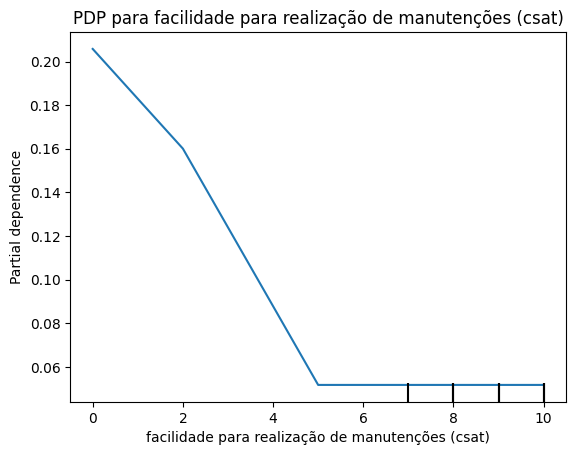

<Figure size 800x600 with 0 Axes>

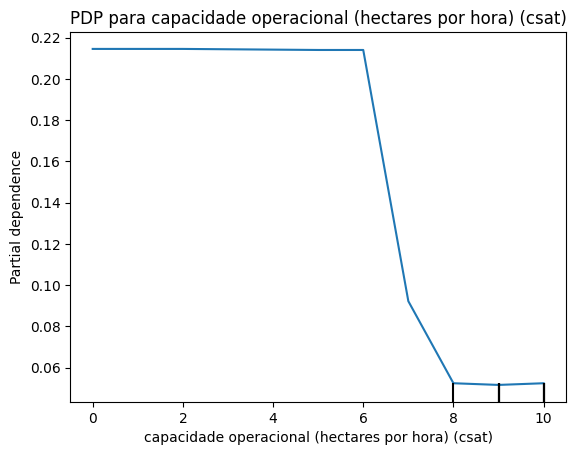

<Figure size 800x600 with 0 Axes>

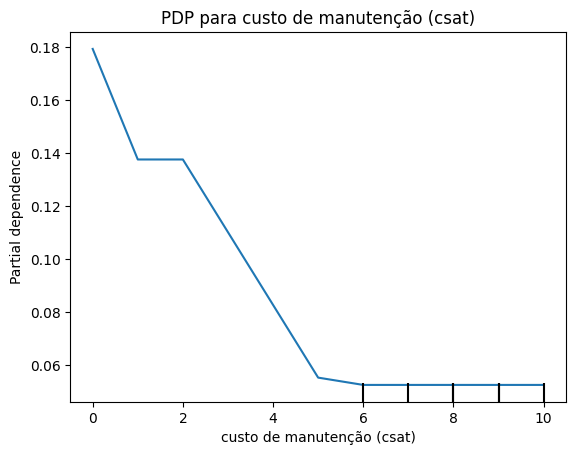

<Figure size 800x600 with 0 Axes>

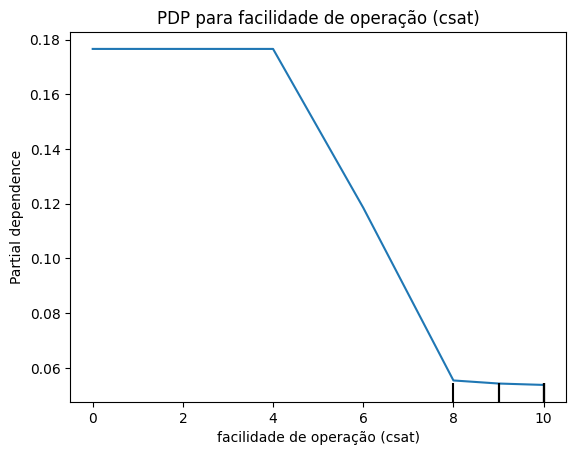






Top 10 variáveis mais importantes para o modelo de neutros:
1. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.12
2. geração e transmissão de dados para gestão da frota (csat) - Importância: 0.11
3. facilidade para realização de manutenções (csat) - Importância: 0.08
4. facilidade de uso do piloto automático (csat) - Importância: 0.08
5. capacidade operacional (hectares por hora) (csat) - Importância: 0.07
6. consumo de combustível (litros por hectares) (csat) - Importância: 0.07
7. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.06
8. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.05
9. adequação as diversas operações e implementos (csat) - Importância: 0.05
10. geração e transmissão de dados para gestão agrícola (csat) - Impor

<Figure size 800x600 with 0 Axes>

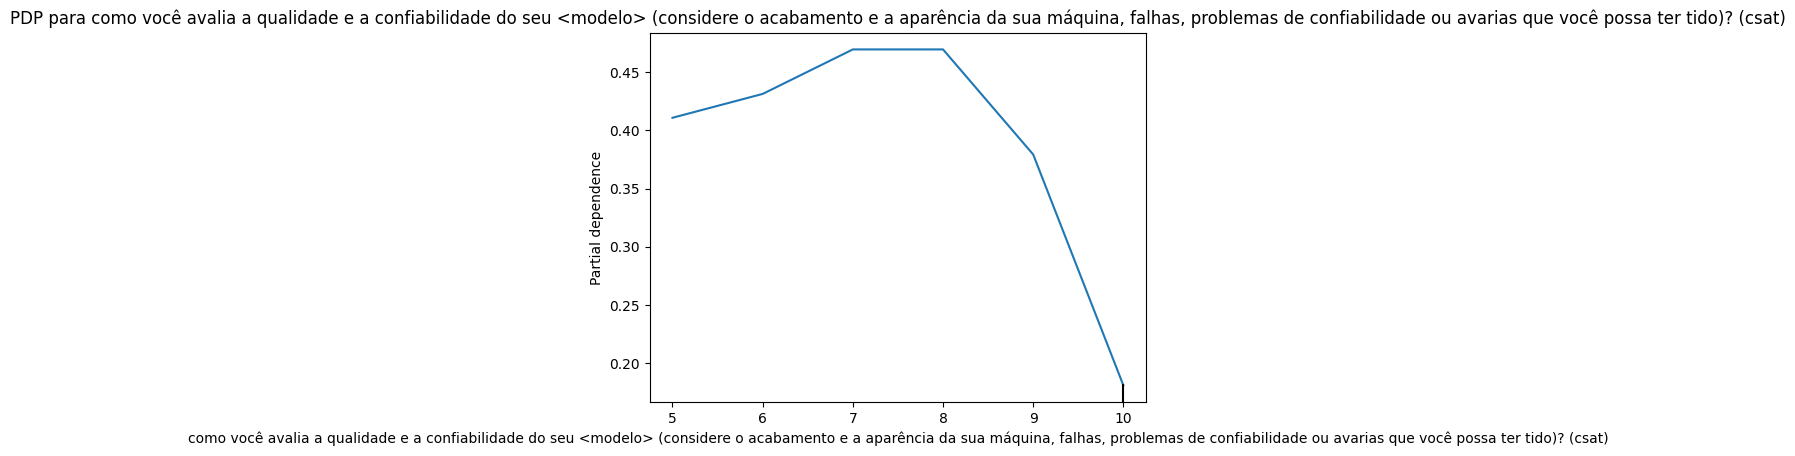

<Figure size 800x600 with 0 Axes>

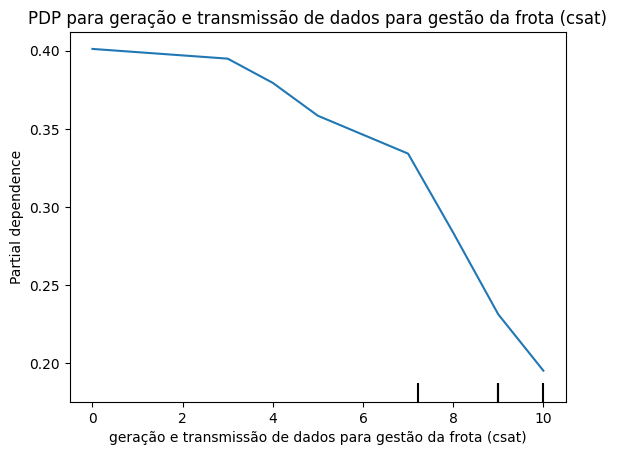

<Figure size 800x600 with 0 Axes>

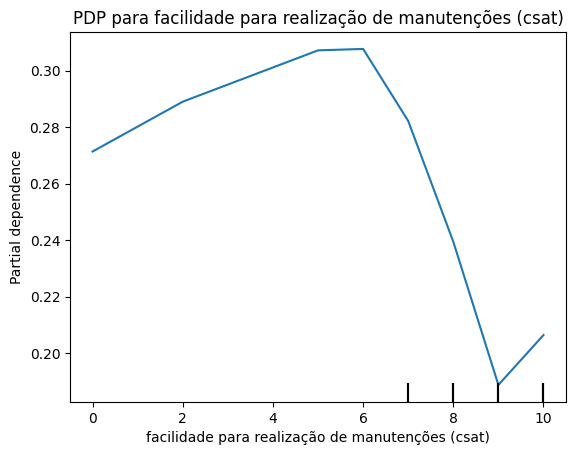

<Figure size 800x600 with 0 Axes>

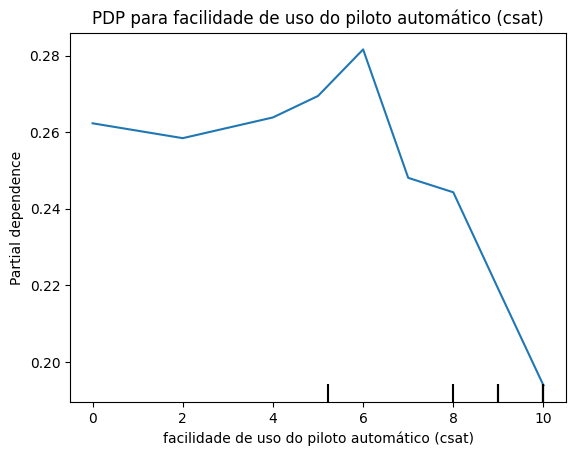

<Figure size 800x600 with 0 Axes>

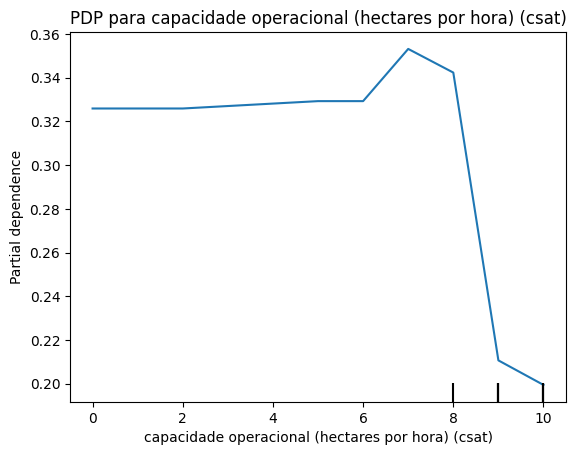

In [ ]:
criarModelo(nordeste)

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.95

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.80

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.98, Classe 1 (Neutro): 0.02
Probalidade 2: Classe 0 (Não Neutro): 0.40, Classe 1 (Neutro): 0.60
Probalidade 3: Classe 0 (Não Neutro): 0.94, Classe 1 (Neutro): 0.06
Probalidade 4: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 5: Classe 0 (Não Neutro): 0.84, Classe 1 (Neutro): 0.16


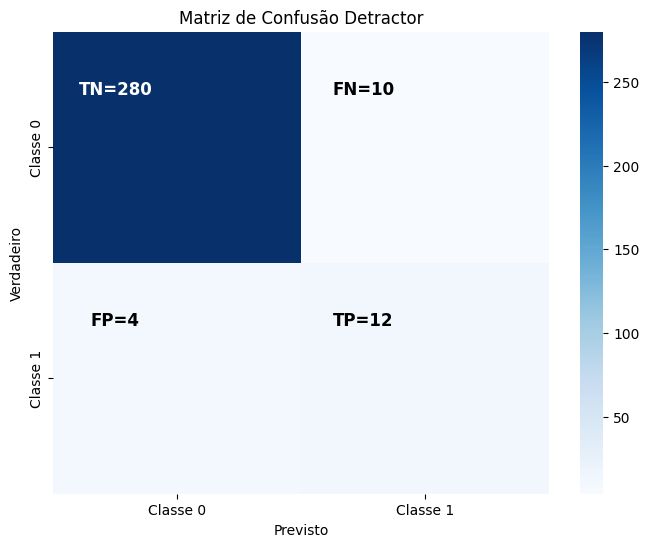

Accuracy Detractor: 0.9542
Precision Detractor: 0.7500
Recall Detractor: 0.5455
F1-Score Detractor: 0.6316


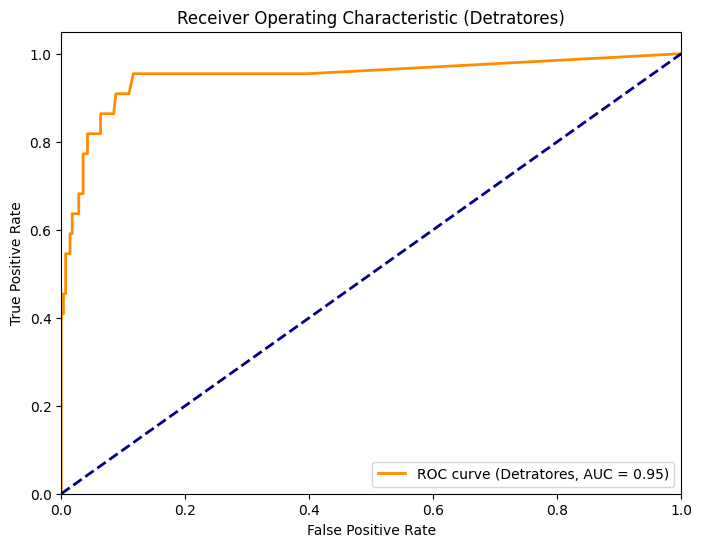

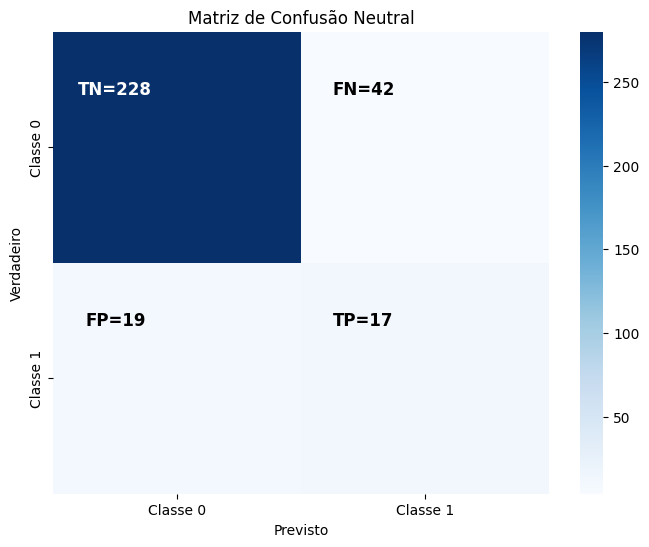

Accuracy Neutral: 0.8007
Precision Neutral: 0.4722
Recall Neutral: 0.2881
F1-Score Neutral: 0.3579


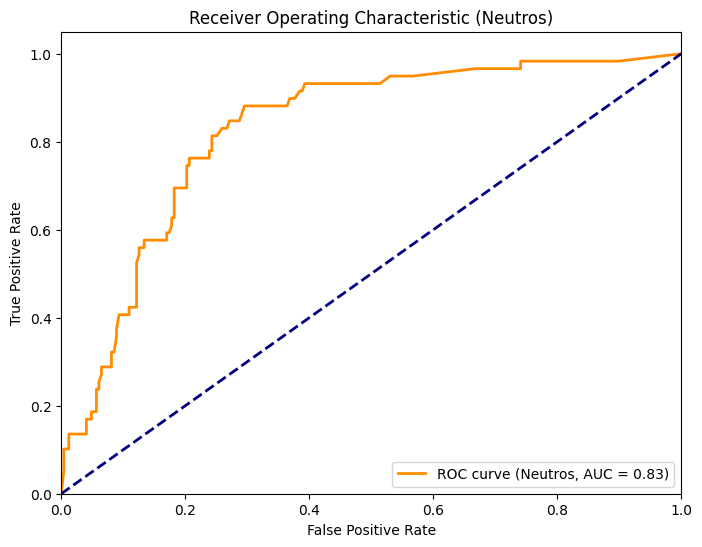






Top 10 variáveis mais importantes para o modelo de detratores:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.12
2. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.11
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.10
4. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.09
5. adequação as diversas operações e implementos (csat) - Importância: 0.08
6. facilidade para realização de manutenções (csat) - Importância: 0.07
7. facilidade de operação (csat) - Importância: 0.07
8. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.06
9. como você avalia o conforto e a ergonomia do seu <modelo>  (considere, por exemplo, o conforto do assento, a visibilidade da cabine, a compreensão e o la

<Figure size 800x600 with 0 Axes>

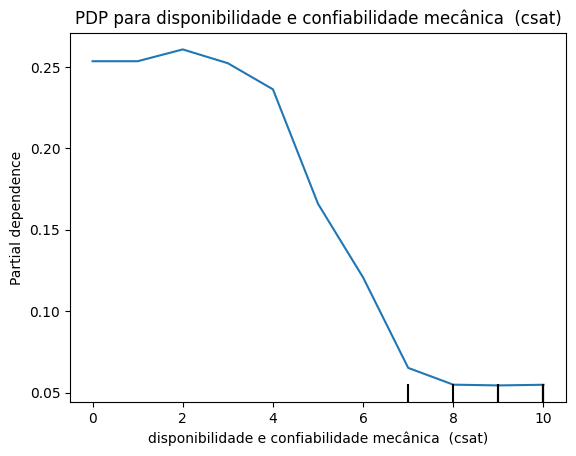

<Figure size 800x600 with 0 Axes>

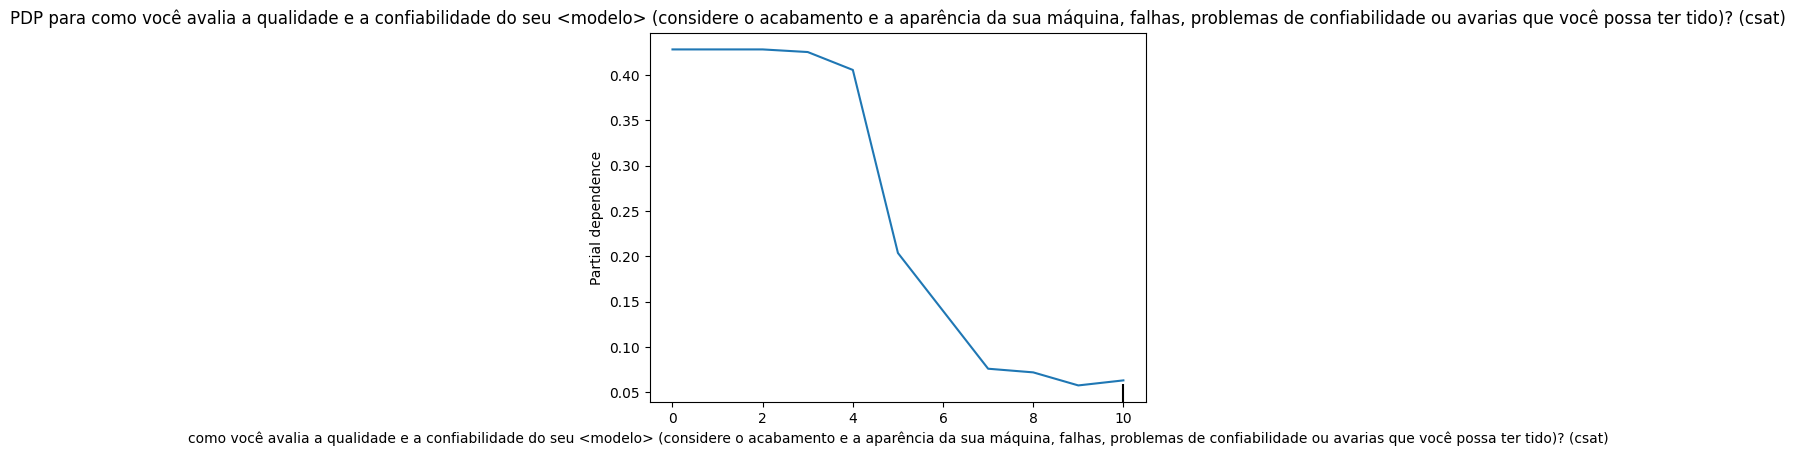

<Figure size 800x600 with 0 Axes>

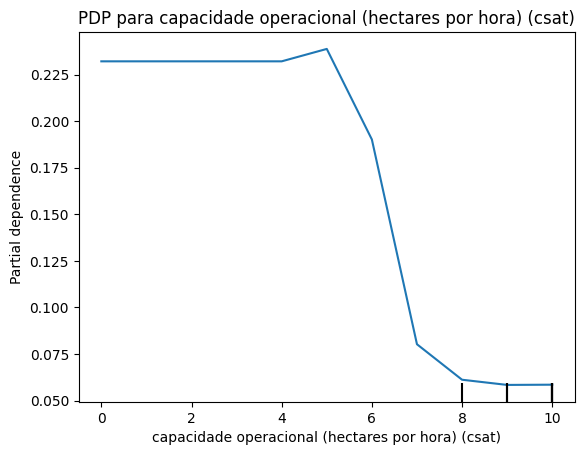

<Figure size 800x600 with 0 Axes>

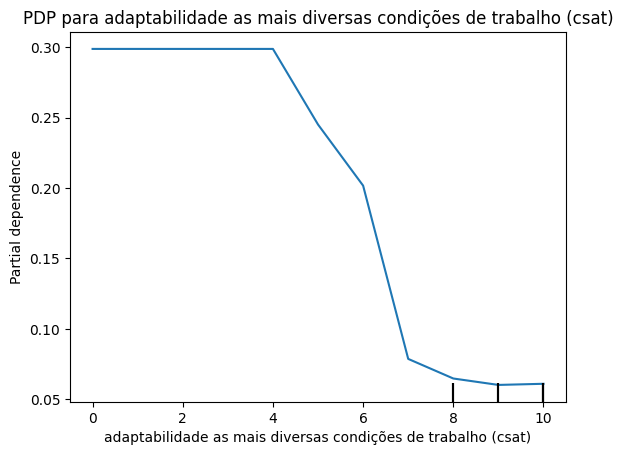

<Figure size 800x600 with 0 Axes>

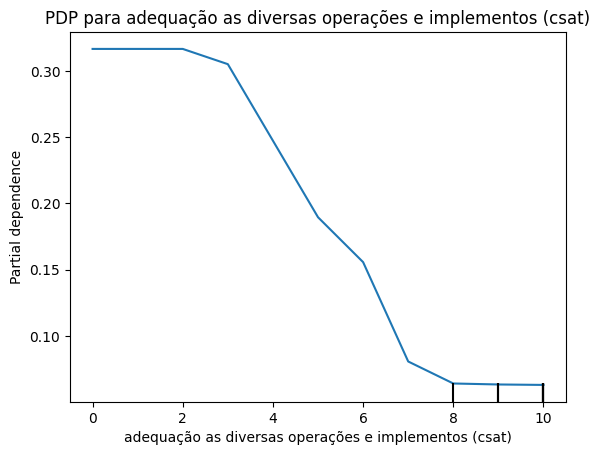






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.09
2. adequação as diversas operações e implementos (csat) - Importância: 0.08
3. custo de manutenção (csat) - Importância: 0.08
4. facilidade para realização de manutenções (csat) - Importância: 0.07
5. capacidade operacional (hectares por hora) (csat) - Importância: 0.07
6. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
7. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.07
8. consumo de combustível (litros por hectares) (csat) - Importância: 0.06
9. conforto e ergonomia (csat) - Importância: 0.06
10. facilidade de uso do piloto automático (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. dis

<Figure size 800x600 with 0 Axes>

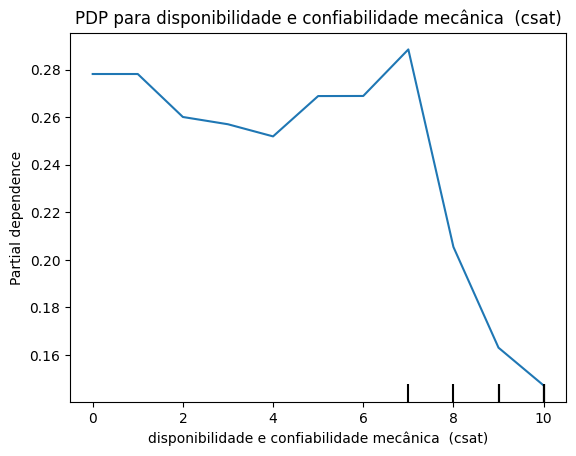

<Figure size 800x600 with 0 Axes>

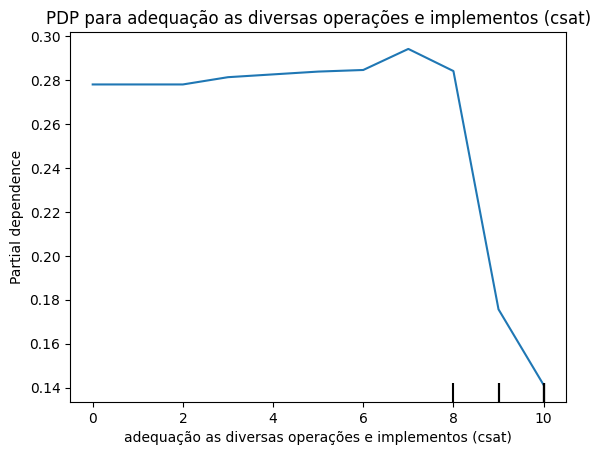

<Figure size 800x600 with 0 Axes>

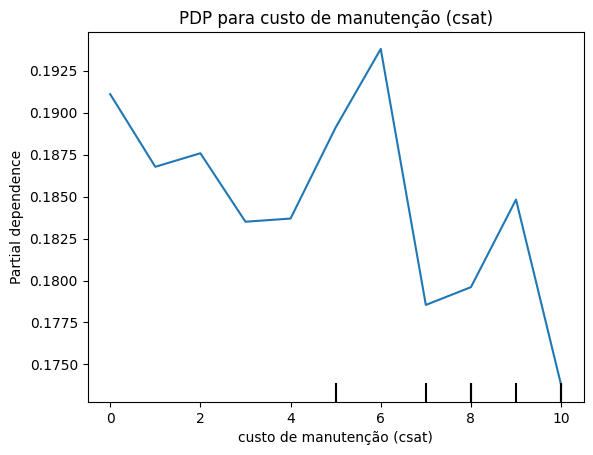

<Figure size 800x600 with 0 Axes>

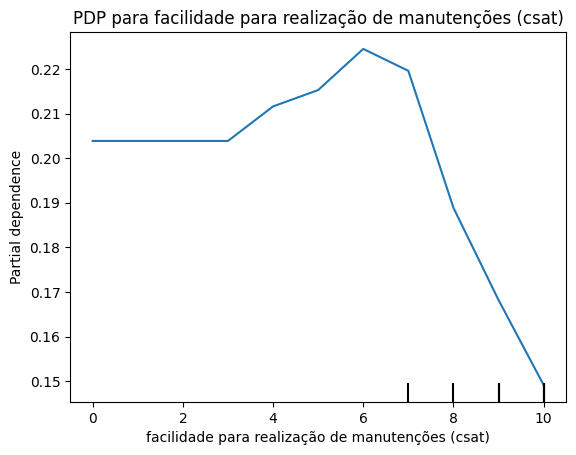

<Figure size 800x600 with 0 Axes>

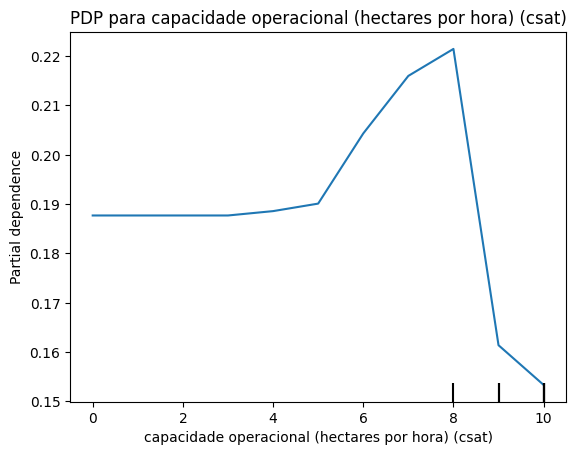

In [ ]:
criarModelo(centro_oeste)

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.97

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 0.97, Classe 1 (Detrator): 0.03
P 2: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 3: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 4: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 5: Classe 0 (Não Detrator): 0.47, Classe 1 (Detrator): 0.53

Acurácia do modelo de neutros: 0.87

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.92, Classe 1 (Neutro): 0.08
Probalidade 2: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 3: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 4: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 5: Classe 0 (Não Neutro): 0.80, Classe 1 (Neutro): 0.20


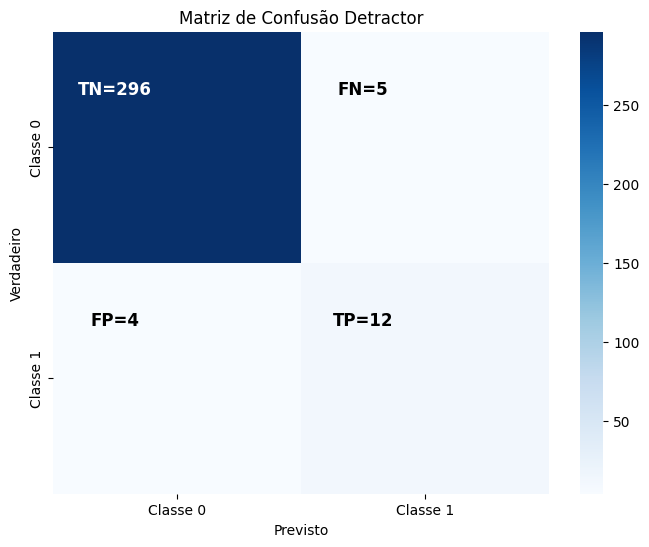

Accuracy Detractor: 0.9716
Precision Detractor: 0.7500
Recall Detractor: 0.7059
F1-Score Detractor: 0.7273


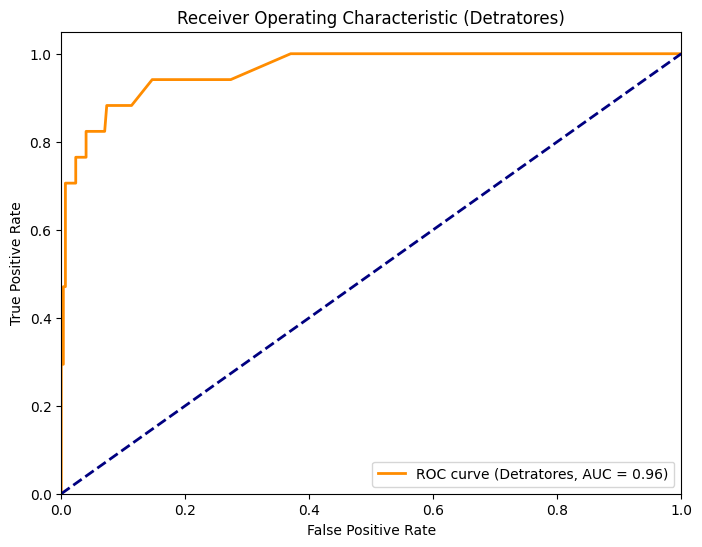

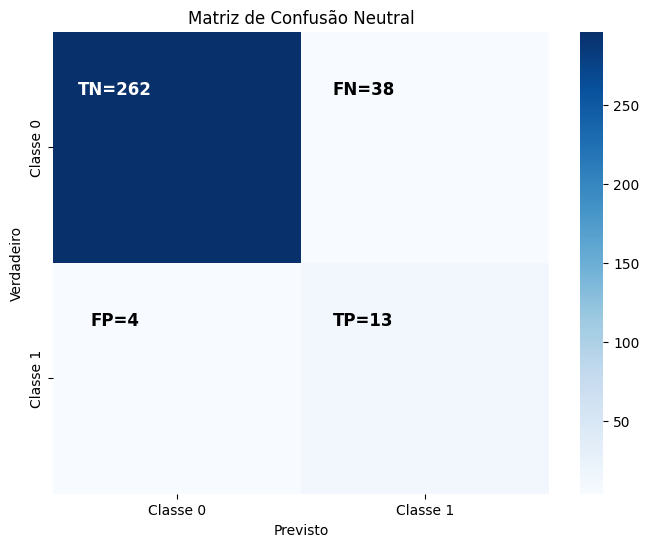

Accuracy Neutral: 0.8675
Precision Neutral: 0.7647
Recall Neutral: 0.2549
F1-Score Neutral: 0.3824


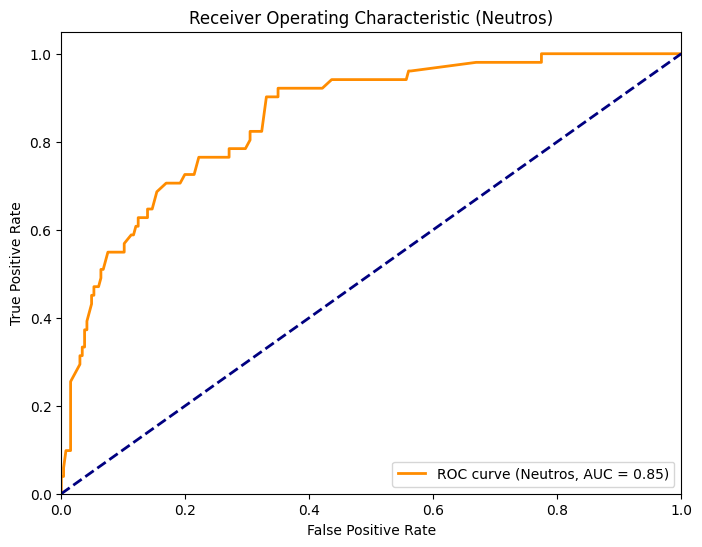






Top 10 variáveis mais importantes para o modelo de detratores:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.14
2. adequação as diversas operações e implementos (csat) - Importância: 0.12
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.10
4. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.10
5. facilidade para realização de manutenções (csat) - Importância: 0.08
6. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
7. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.06
8. facilidade de operação (csat) - Importância: 0.06
9. consumo de combustível (litros por hectares) (csat) - Importância: 0.05
10. custo de manutenção (csat) - Importância: 0.04

Gráficos PDP para o modelo de

<Figure size 800x600 with 0 Axes>

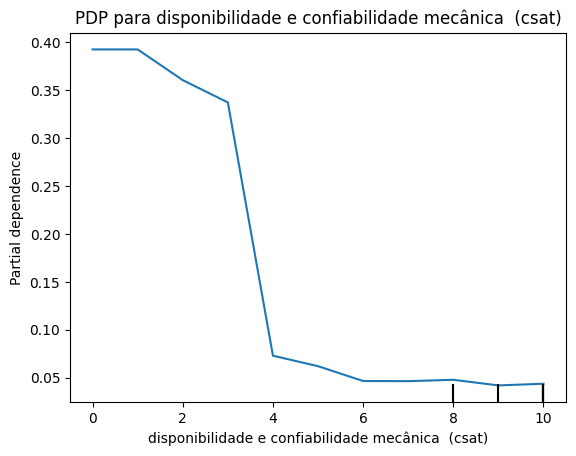

<Figure size 800x600 with 0 Axes>

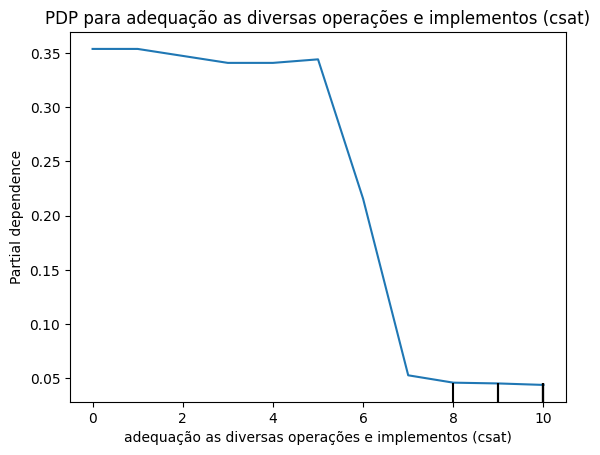

<Figure size 800x600 with 0 Axes>

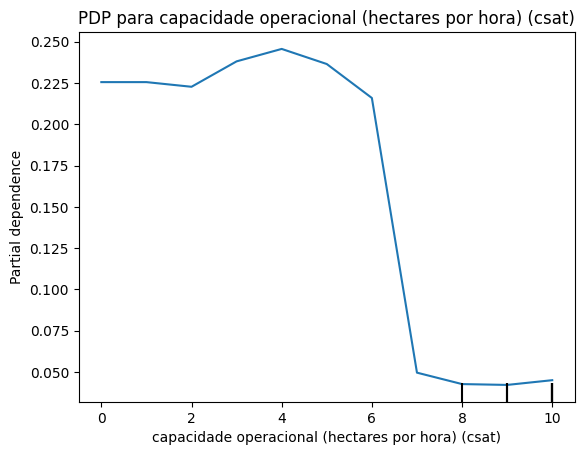

<Figure size 800x600 with 0 Axes>

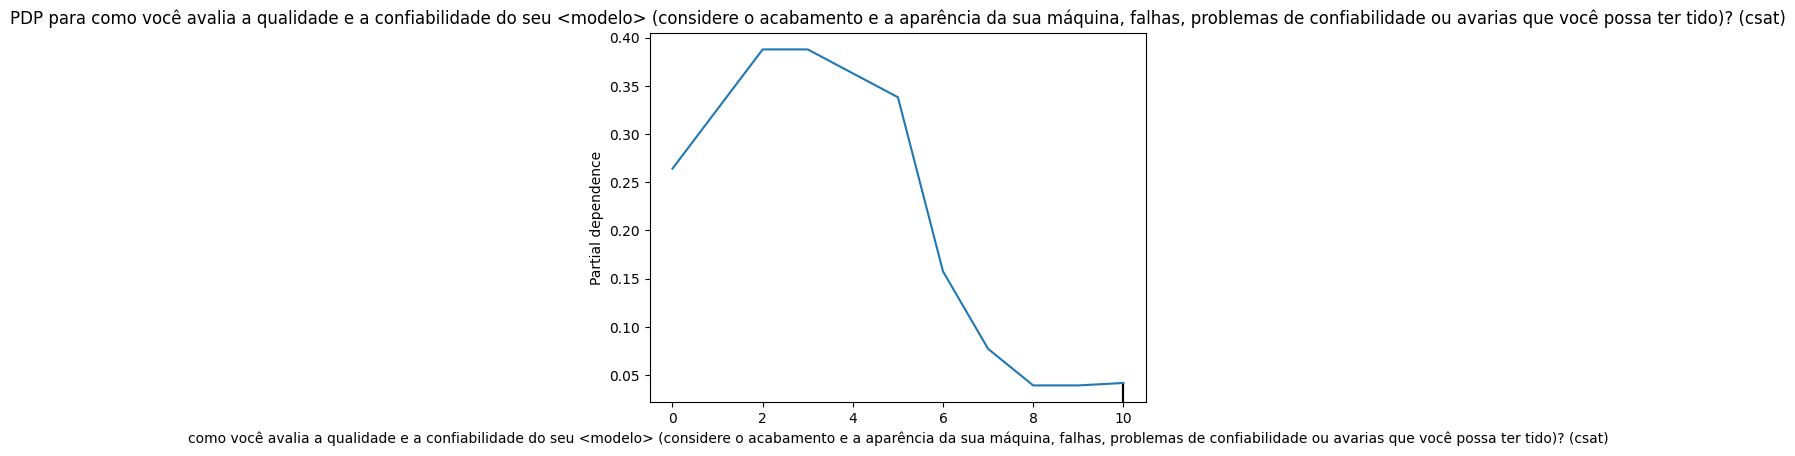

<Figure size 800x600 with 0 Axes>

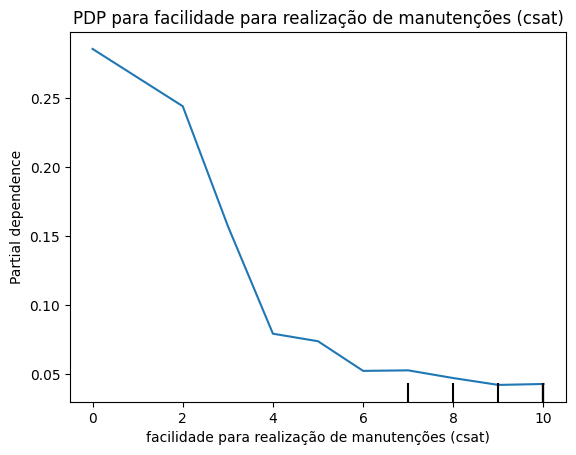






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.11
2. capacidade operacional (hectares por hora) (csat) - Importância: 0.10
3. custo de manutenção (csat) - Importância: 0.08
4. consumo de combustível (litros por hectares) (csat) - Importância: 0.08
5. adequação as diversas operações e implementos (csat) - Importância: 0.07
6. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
7. facilidade de operação (csat) - Importância: 0.07
8. facilidade para realização de manutenções (csat) - Importância: 0.06
9. conforto e ergonomia (csat) - Importância: 0.06
10. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. disponibilidade e c

<Figure size 800x600 with 0 Axes>

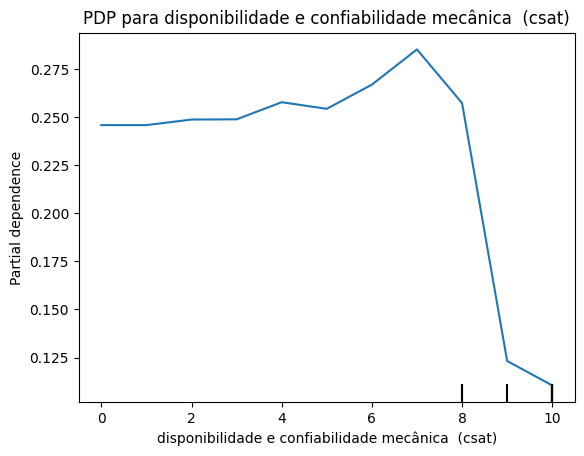

<Figure size 800x600 with 0 Axes>

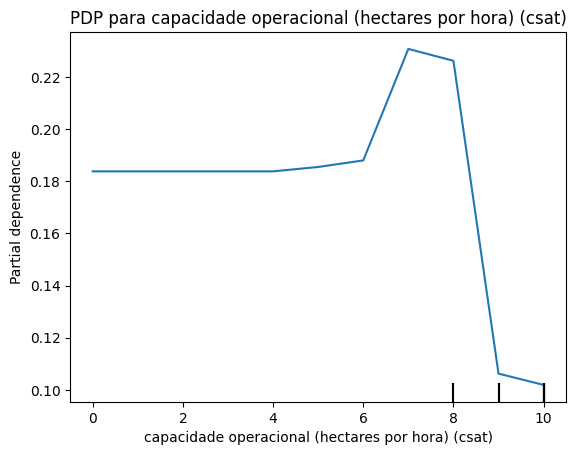

<Figure size 800x600 with 0 Axes>

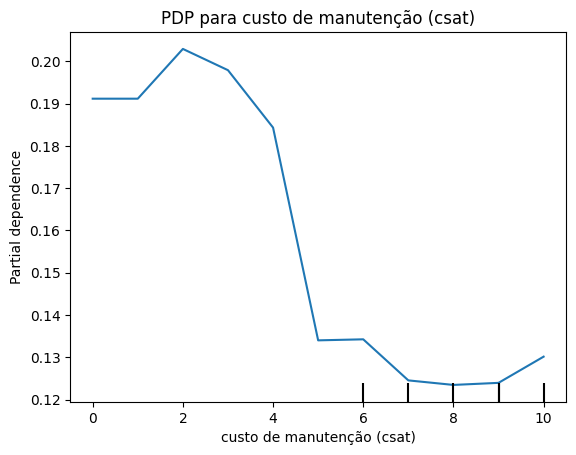

<Figure size 800x600 with 0 Axes>

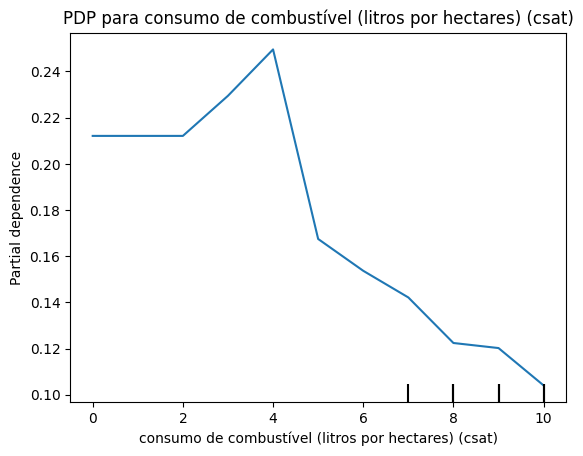

<Figure size 800x600 with 0 Axes>

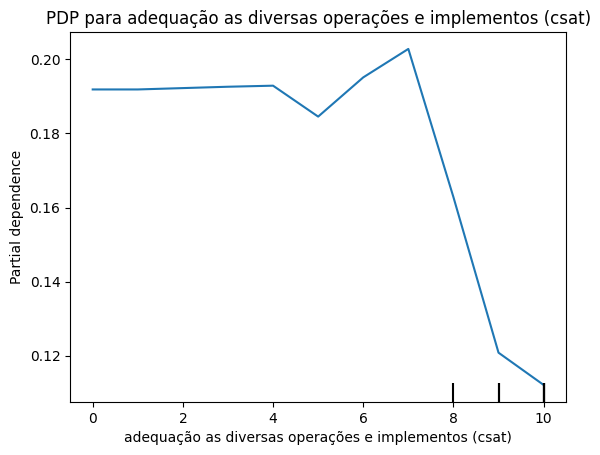

In [ ]:
criarModelo(periodos_pesquisa['3a6'])

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.96

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 0.96, Classe 1 (Detrator): 0.04
P 4: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.84

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 2: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 3: Classe 0 (Não Neutro): 0.93, Classe 1 (Neutro): 0.07
Probalidade 4: Classe 0 (Não Neutro): 0.95, Classe 1 (Neutro): 0.05
Probalidade 5: Classe 0 (Não Neutro): 0.93, Classe 1 (Neutro): 0.07


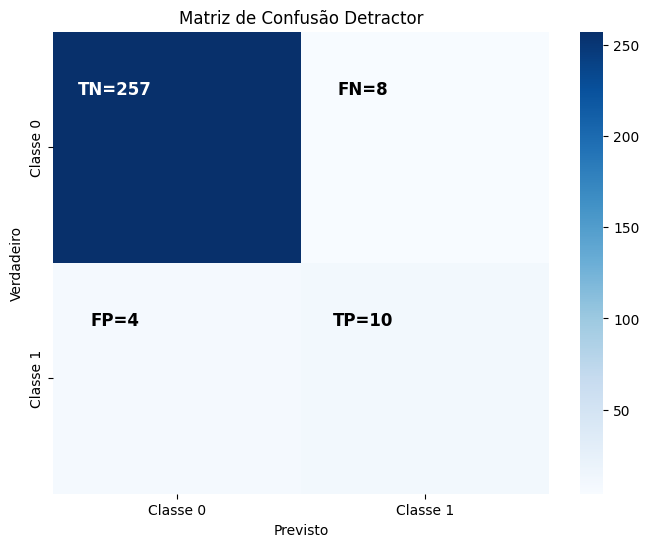

Accuracy Detractor: 0.9570
Precision Detractor: 0.7143
Recall Detractor: 0.5556
F1-Score Detractor: 0.6250


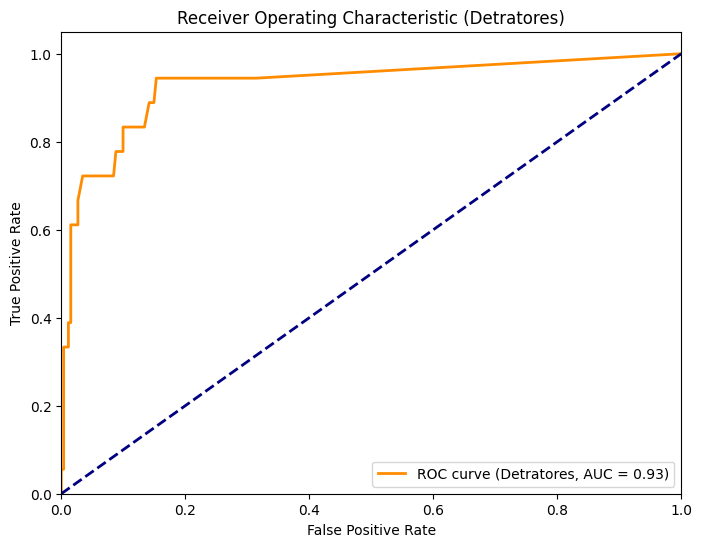

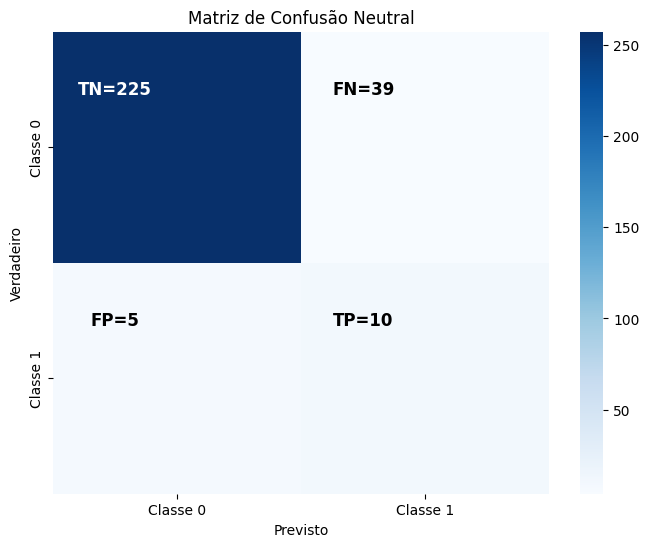

Accuracy Neutral: 0.8423
Precision Neutral: 0.6667
Recall Neutral: 0.2041
F1-Score Neutral: 0.3125


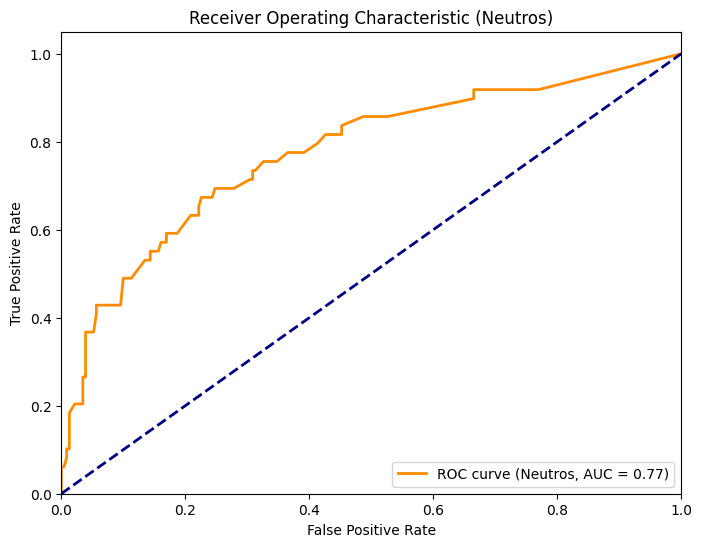






Top 10 variáveis mais importantes para o modelo de detratores:
1. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.14
2. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.11
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
4. facilidade de uso do piloto automático (csat) - Importância: 0.08
5. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
6. adequação as diversas operações e implementos (csat) - Importância: 0.07
7. como você avalia o conforto e a ergonomia do seu <modelo>  (considere, por exemplo, o conforto do assento, a visibilidade da cabine, a compreensão e o layout dos controles)? (csat) - Importância: 0.07
8. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.06
9. consu

<Figure size 800x600 with 0 Axes>

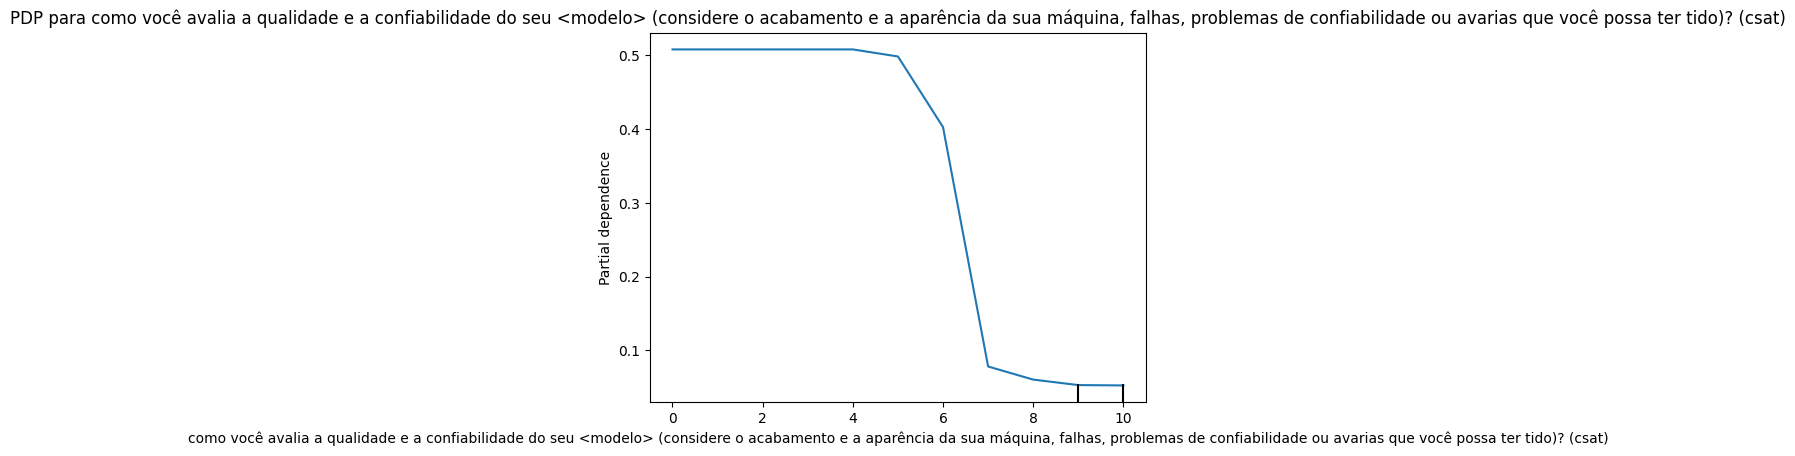

<Figure size 800x600 with 0 Axes>

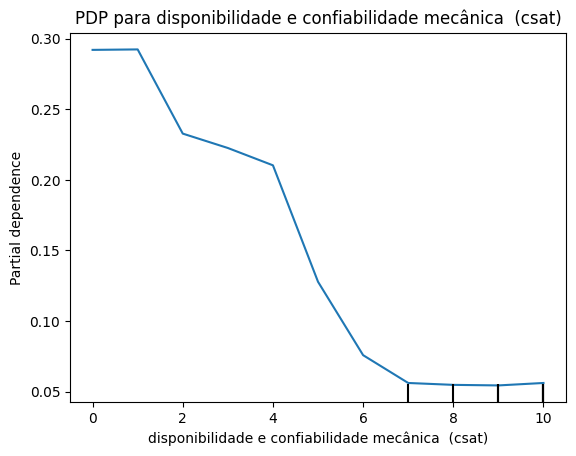

<Figure size 800x600 with 0 Axes>

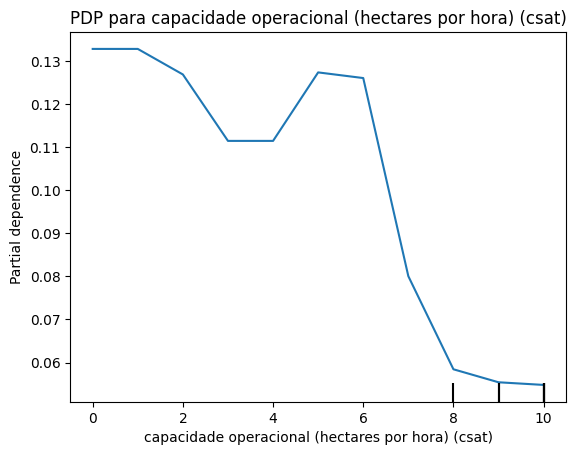

<Figure size 800x600 with 0 Axes>

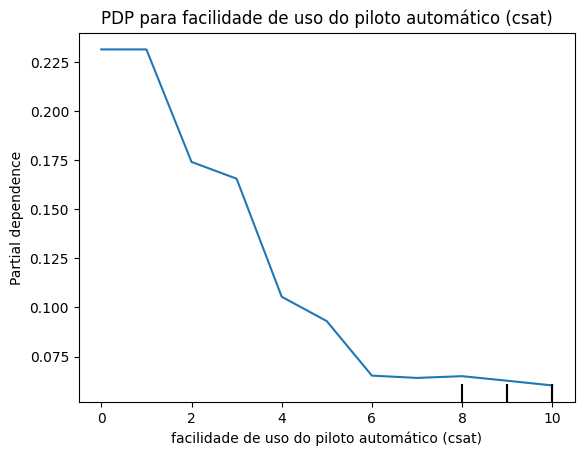

<Figure size 800x600 with 0 Axes>

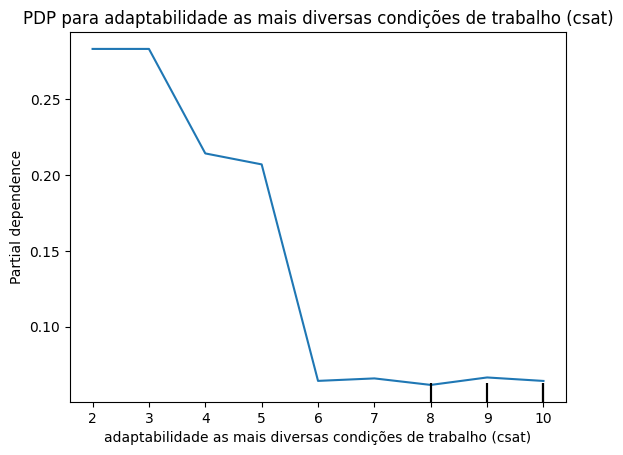






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.10
2. adequação as diversas operações e implementos (csat) - Importância: 0.09
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
4. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.08
5. facilidade para realização de manutenções (csat) - Importância: 0.08
6. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
7. custo de manutenção (csat) - Importância: 0.08
8. facilidade de operação (csat) - Importância: 0.07
9. consumo de combustível (litros por hectares) (csat) - Importância: 0.06
10. facilidade de uso do piloto automático (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. d

<Figure size 800x600 with 0 Axes>

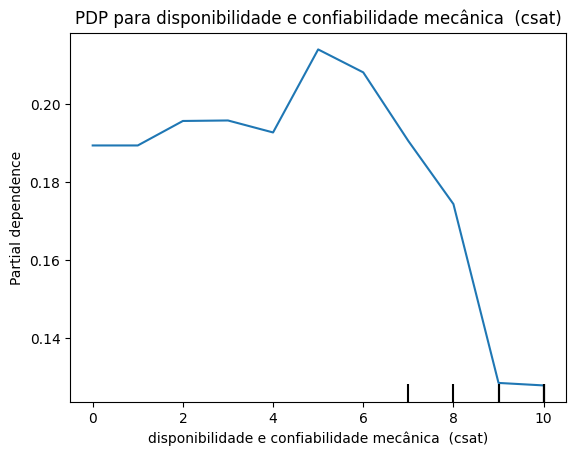

<Figure size 800x600 with 0 Axes>

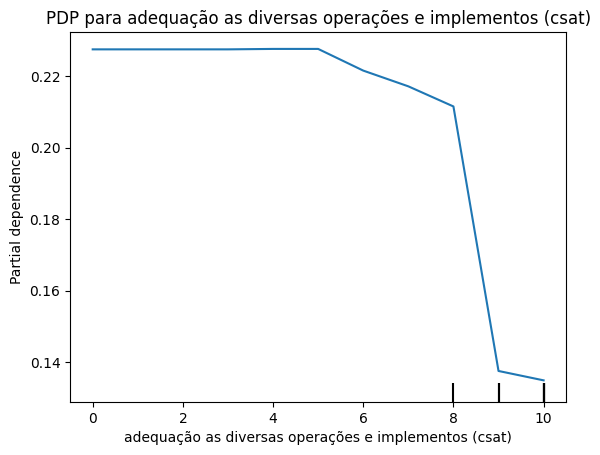

<Figure size 800x600 with 0 Axes>

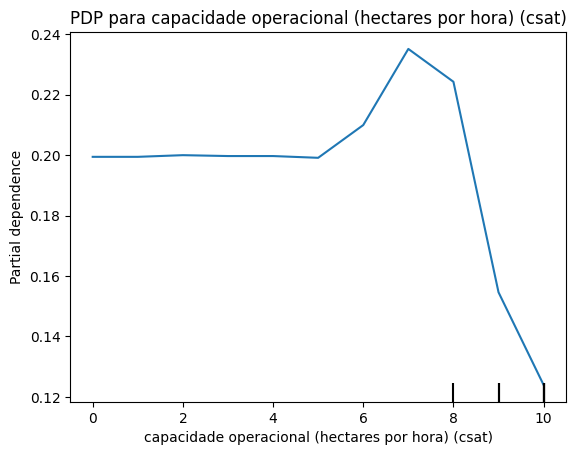

<Figure size 800x600 with 0 Axes>

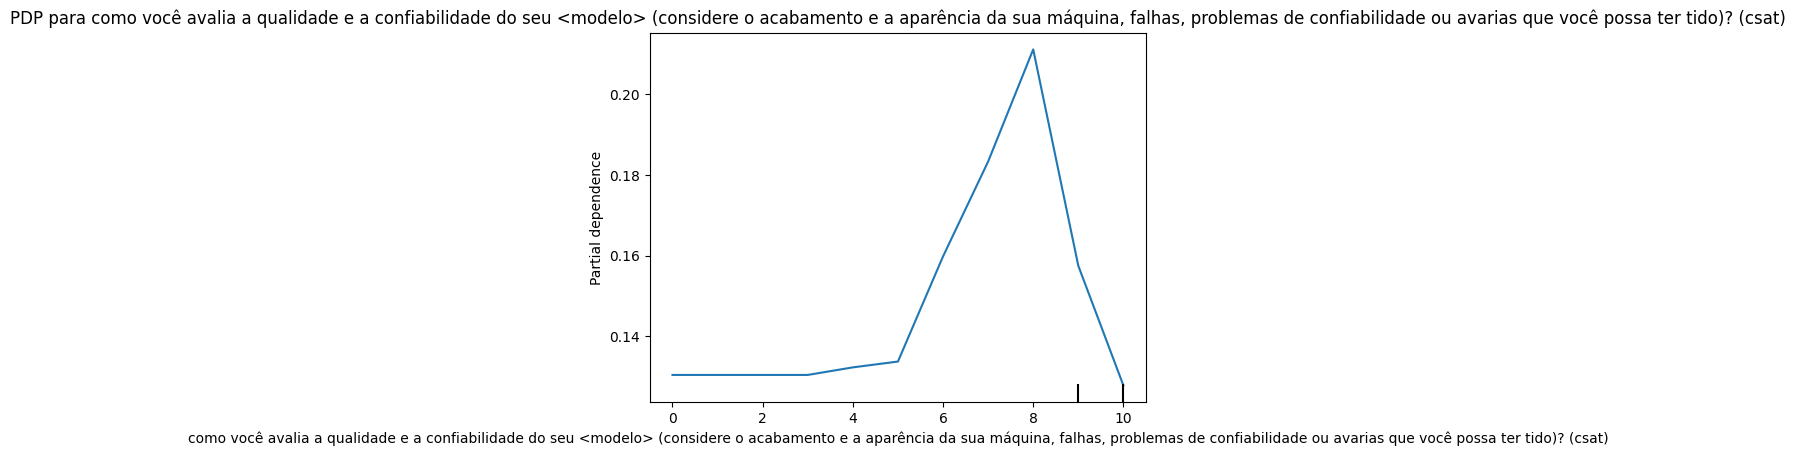

<Figure size 800x600 with 0 Axes>

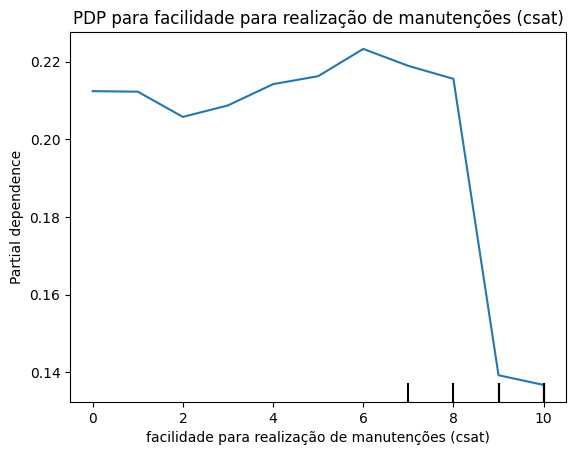

In [ ]:
criarModelo(periodos_pesquisa['6a12'])

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.97

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 0.92, Classe 1 (Detrator): 0.08
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 0.99, Classe 1 (Detrator): 0.01

Acurácia do modelo de neutros: 0.82

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.86, Classe 1 (Neutro): 0.14
Probalidade 2: Classe 0 (Não Neutro): 0.92, Classe 1 (Neutro): 0.08
Probalidade 3: Classe 0 (Não Neutro): 0.77, Classe 1 (Neutro): 0.23
Probalidade 4: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00
Probalidade 5: Classe 0 (Não Neutro): 1.00, Classe 1 (Neutro): 0.00


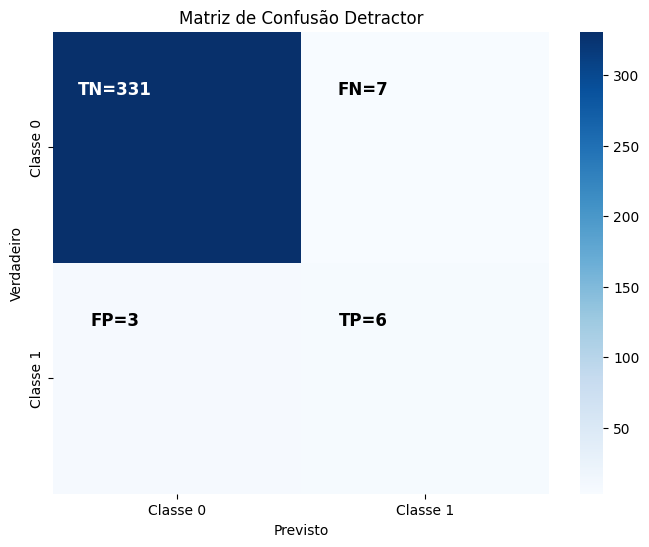

Accuracy Detractor: 0.9712
Precision Detractor: 0.6667
Recall Detractor: 0.4615
F1-Score Detractor: 0.5455


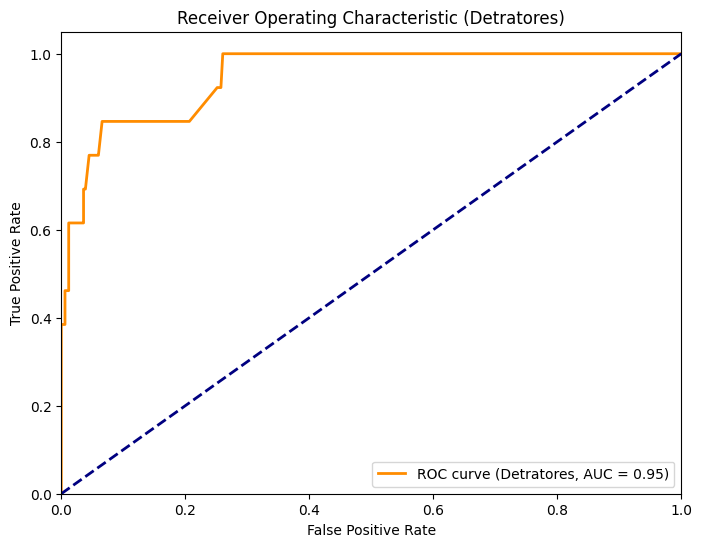

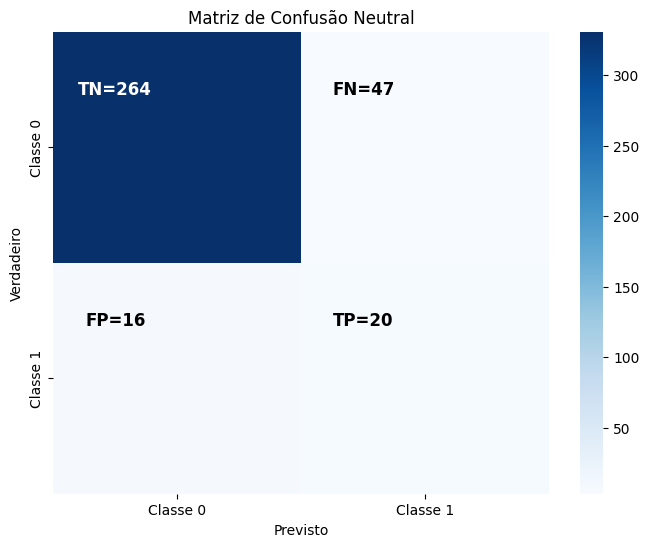

Accuracy Neutral: 0.8184
Precision Neutral: 0.5556
Recall Neutral: 0.2985
F1-Score Neutral: 0.3883


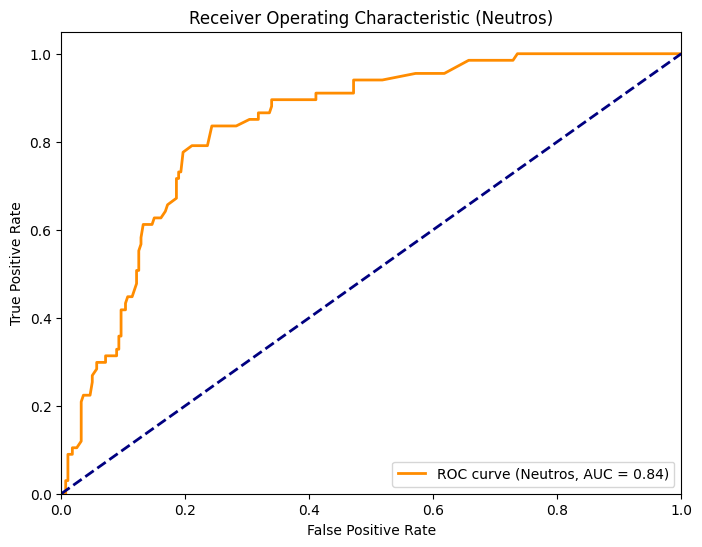






Top 10 variáveis mais importantes para o modelo de detratores:
1. adequação as diversas operações e implementos (csat) - Importância: 0.15
2. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.11
3. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.09
4. ¿está satisfecho con la calidad del producto? (csat) - Importância: 0.09
5. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
6. custo de manutenção (csat) - Importância: 0.06
7. conforto e ergonomia (csat) - Importância: 0.06
8. facilidade de operação (csat) - Importância: 0.05
9. facilidade para realização de manutenções (csat) - Importância: 0.05
10. consumo de combustível (litros por hectares) (csat) - Importância: 0.05

Gráficos PDP para o modelo de detratores:

Top 5 variáveis mais importantes para PDP:
1. adequação as diversas operações e implementos (csat) - Importância: 0.1519
2. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.1096
3. adapt

<Figure size 800x600 with 0 Axes>

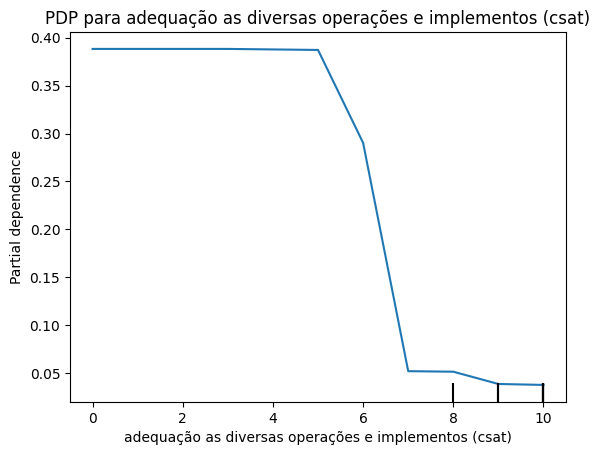

<Figure size 800x600 with 0 Axes>

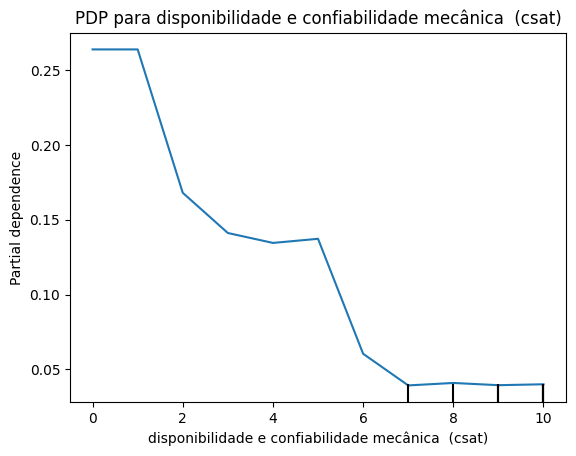

<Figure size 800x600 with 0 Axes>

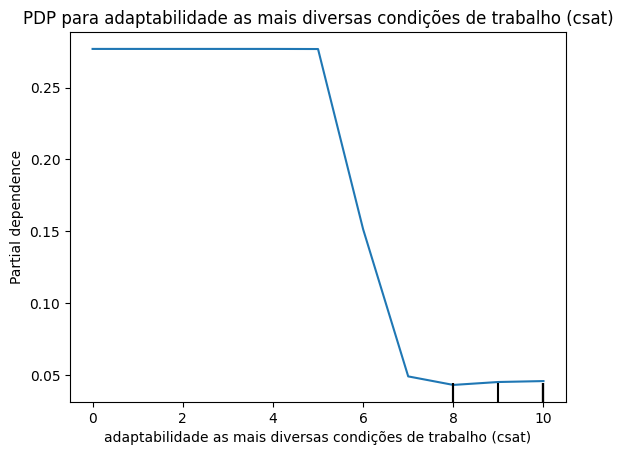

<Figure size 800x600 with 0 Axes>

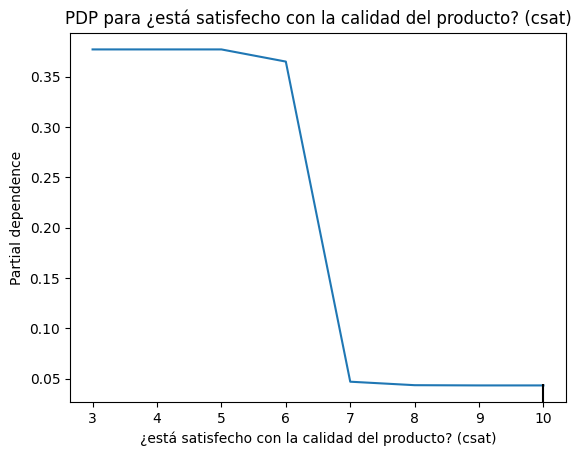

<Figure size 800x600 with 0 Axes>

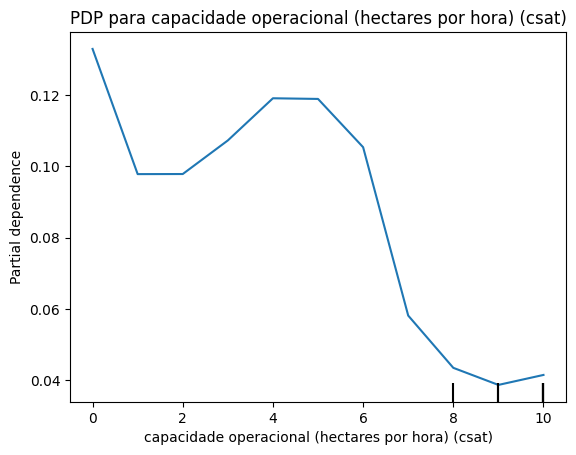






Top 10 variáveis mais importantes para o modelo de neutros:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.10
2. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.09
3. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
4. facilidade para realização de manutenções (csat) - Importância: 0.08
5. custo de manutenção (csat) - Importância: 0.07
6. consumo de combustível (litros por hectares) (csat) - Importância: 0.07
7. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.07
8. adequação as diversas operações e implementos (csat) - Importância: 0.07
9. facilidade de uso do piloto automático (csat) - Importância: 0.05
10. conforto e ergonomia (csat) - Importância: 0.05

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.0968
2. adaptabilidade as mais di

<Figure size 800x600 with 0 Axes>

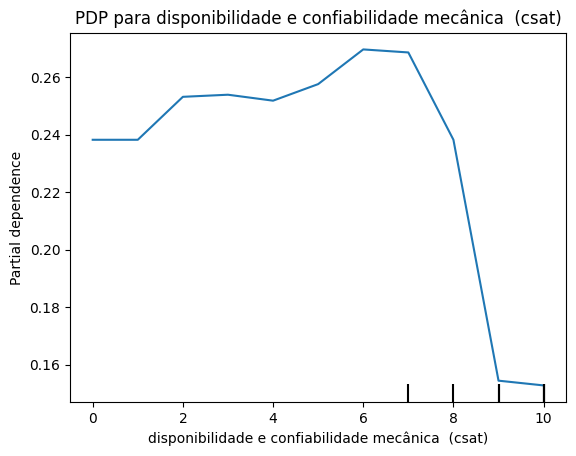

<Figure size 800x600 with 0 Axes>

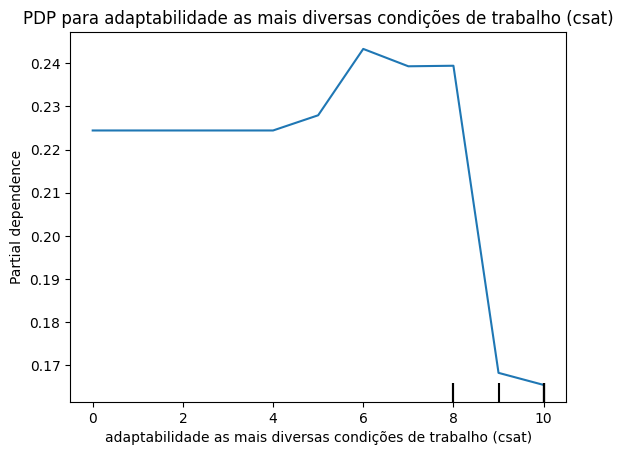

<Figure size 800x600 with 0 Axes>

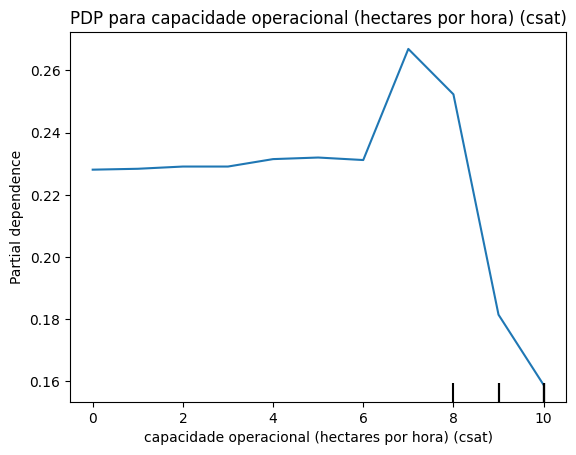

<Figure size 800x600 with 0 Axes>

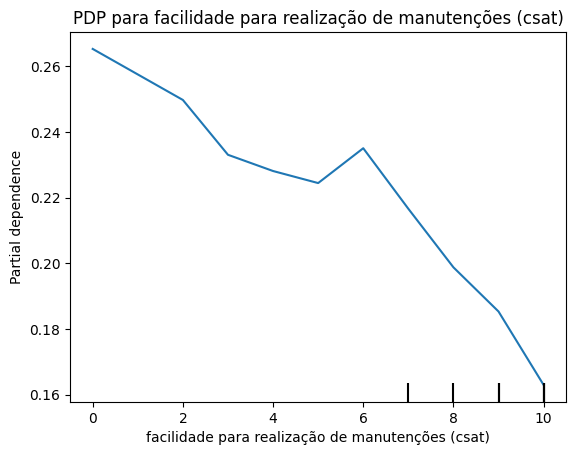

<Figure size 800x600 with 0 Axes>

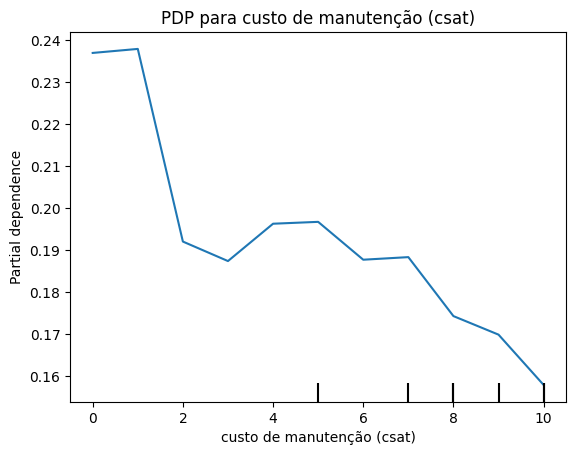

In [ ]:
criarModelo(periodos_pesquisa['12a18'])

<ipython-input-5-16174dc9529c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_detractor'] = np.where(df_modelo['nota'] <= 6, 1, 0)  # 1 para detratores, 0 para outros
<ipython-input-5-16174dc9529c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['target_neutral'] = np.where((df_modelo['nota'] > 6) & (df_modelo['nota'] <= 8), 1, 0)  # 1 para neutros, 0 para outros



Acurácia do modelo de detratores: 0.96

Probabilidades previstas pelo modelo de detratores (primeiros 5 exemplos):
P 1: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 2: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 3: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 4: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00
P 5: Classe 0 (Não Detrator): 1.00, Classe 1 (Detrator): 0.00

Acurácia do modelo de neutros: 0.84

Probabilidades previstas pelo modelo de neutros (primeiros 5 exemplos):
Probalidade 1: Classe 0 (Não Neutro): 0.97, Classe 1 (Neutro): 0.03
Probalidade 2: Classe 0 (Não Neutro): 0.87, Classe 1 (Neutro): 0.13
Probalidade 3: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01
Probalidade 4: Classe 0 (Não Neutro): 0.97, Classe 1 (Neutro): 0.03
Probalidade 5: Classe 0 (Não Neutro): 0.99, Classe 1 (Neutro): 0.01


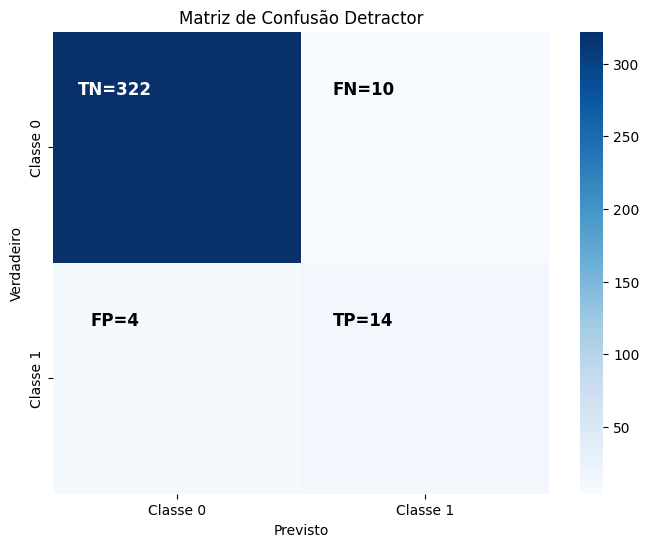

Accuracy Detractor: 0.9600
Precision Detractor: 0.7778
Recall Detractor: 0.5833
F1-Score Detractor: 0.6667


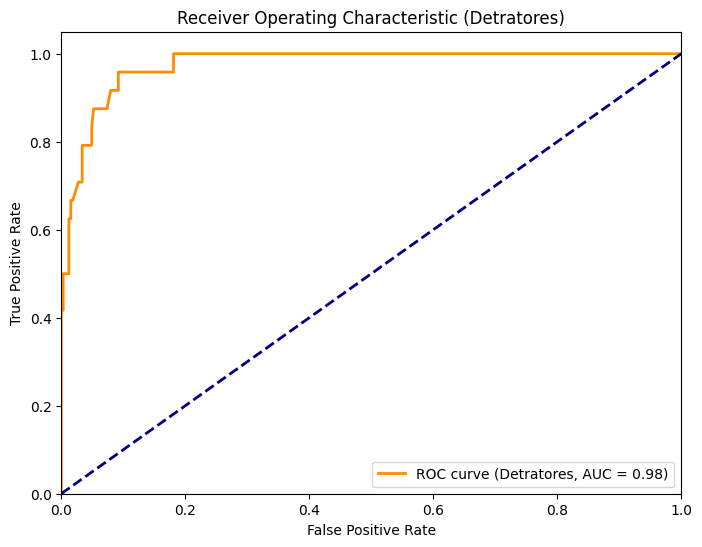

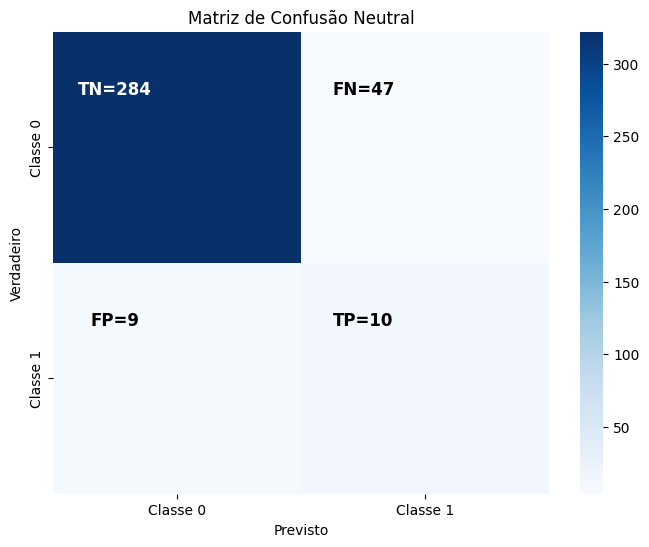

Accuracy Neutral: 0.8400
Precision Neutral: 0.5263
Recall Neutral: 0.1754
F1-Score Neutral: 0.2632


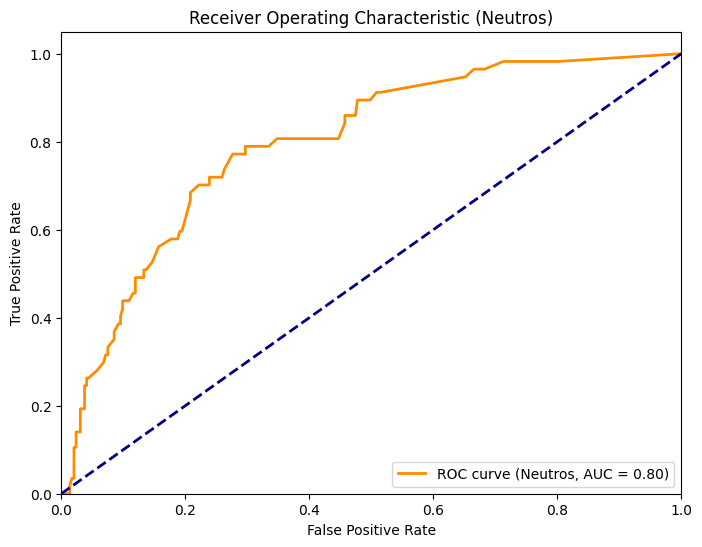






Top 10 variáveis mais importantes para o modelo de detratores:
1. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.18
2. adequação as diversas operações e implementos (csat) - Importância: 0.10
3. agora, considere características específicas do seu <modelo>, como você avalia seu desempenho (csat) - Importância: 0.10
4. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.08
5. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.08
6. como você avalia o conforto e a ergonomia do seu <modelo>  (considere, por exemplo, o conforto do assento, a visibilidade da cabine, a compreensão e o layout dos controles)? (csat) - Importância: 0.07
7. facilidade para realização de manutenções (csat) - Importância: 0.07
8. capacidade operacional (hectares por hora) (csat) - Importância: 0.06
9. co

<Figure size 800x600 with 0 Axes>

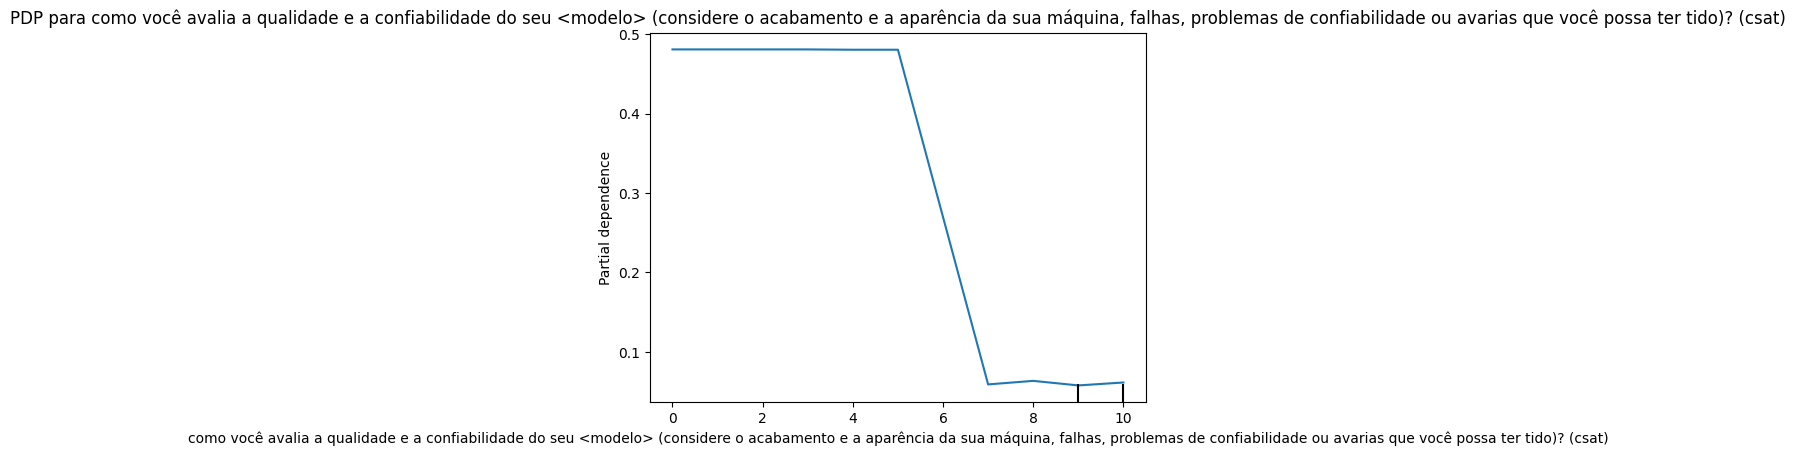

<Figure size 800x600 with 0 Axes>

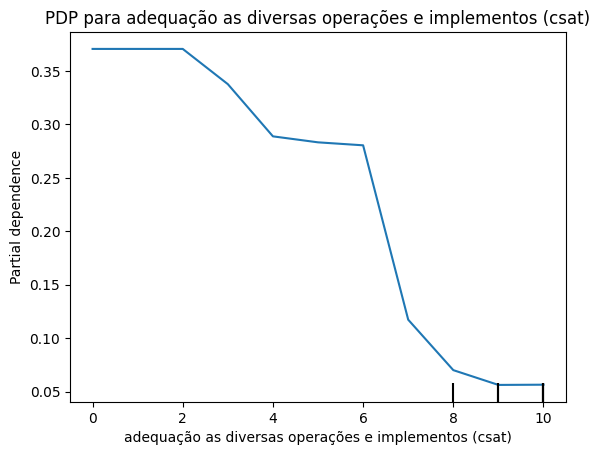

<Figure size 800x600 with 0 Axes>

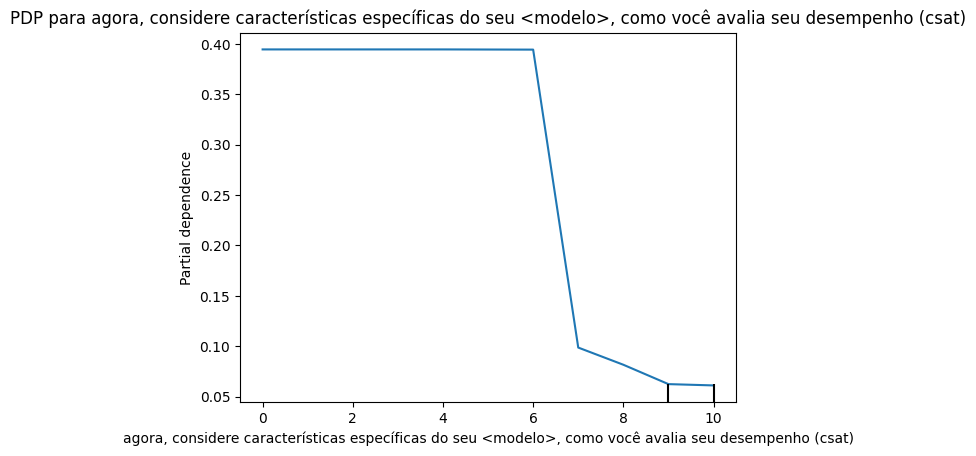

<Figure size 800x600 with 0 Axes>

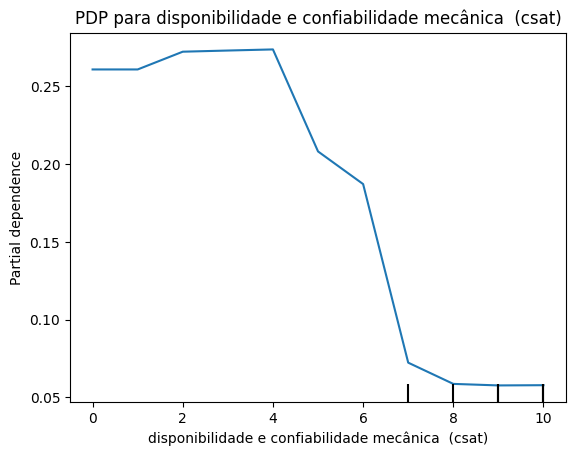

<Figure size 800x600 with 0 Axes>

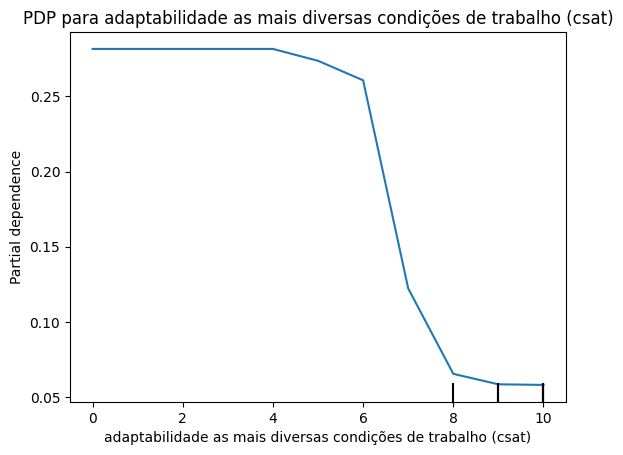






Top 10 variáveis mais importantes para o modelo de neutros:
1. facilidade para realização de manutenções (csat) - Importância: 0.09
2. disponibilidade e confiabilidade mecânica  (csat) - Importância: 0.09
3. como você avalia a qualidade e a confiabilidade do seu <modelo> (considere o acabamento e a aparência da sua máquina, falhas, problemas de confiabilidade ou avarias que você possa ter tido)? (csat) - Importância: 0.08
4. custo de manutenção (csat) - Importância: 0.08
5. capacidade operacional (hectares por hora) (csat) - Importância: 0.08
6. consumo de combustível (litros por hectares) (csat) - Importância: 0.08
7. facilidade de uso do piloto automático (csat) - Importância: 0.07
8. adequação as diversas operações e implementos (csat) - Importância: 0.07
9. adaptabilidade as mais diversas condições de trabalho (csat) - Importância: 0.07
10. facilidade de operação (csat) - Importância: 0.06

Gráficos PDP para o modelo de neutros:

Top 5 variáveis mais importantes para PDP:
1. f

<Figure size 800x600 with 0 Axes>

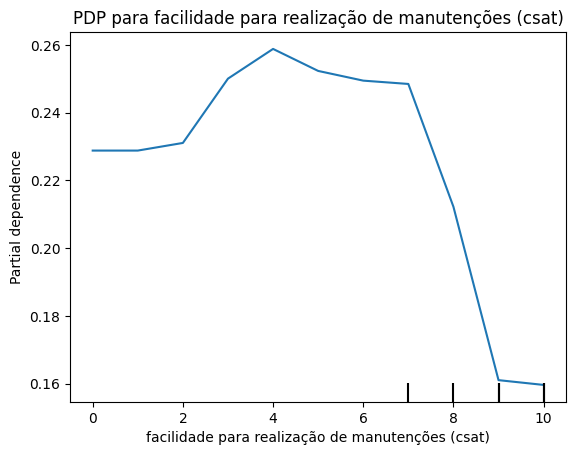

<Figure size 800x600 with 0 Axes>

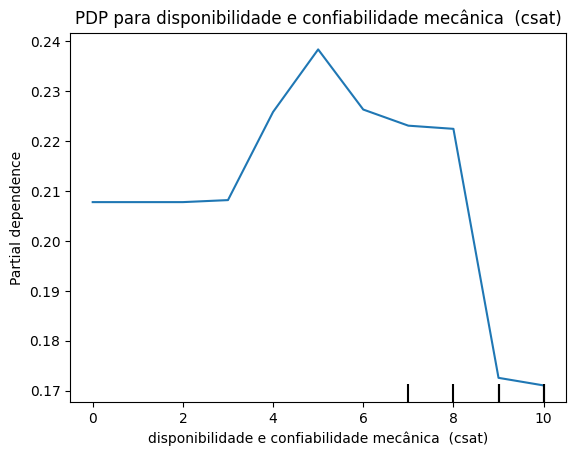

<Figure size 800x600 with 0 Axes>

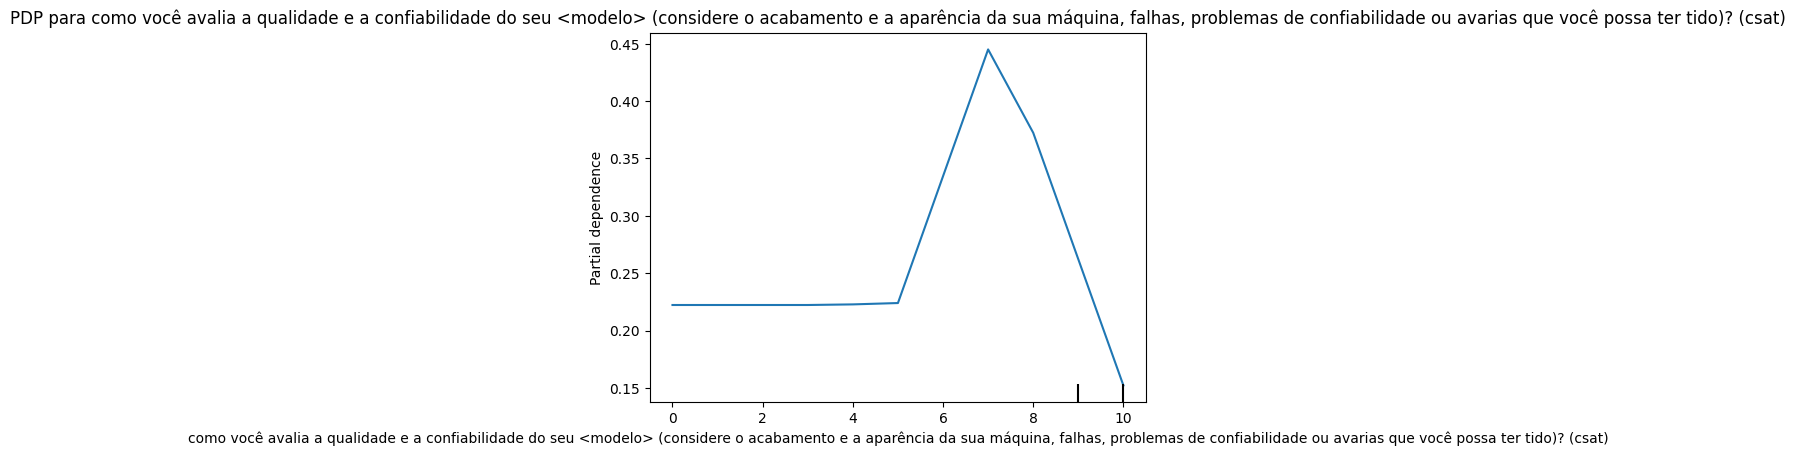

<Figure size 800x600 with 0 Axes>

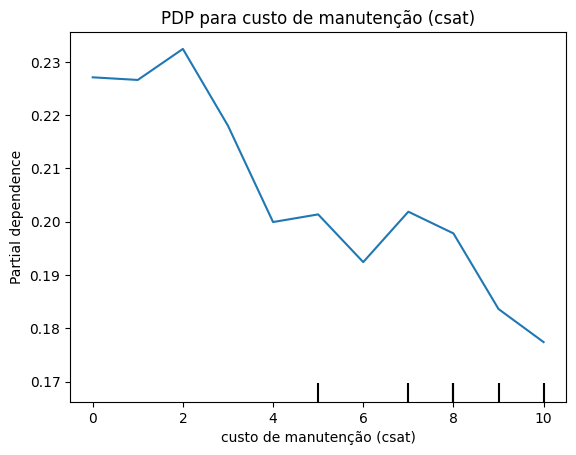

<Figure size 800x600 with 0 Axes>

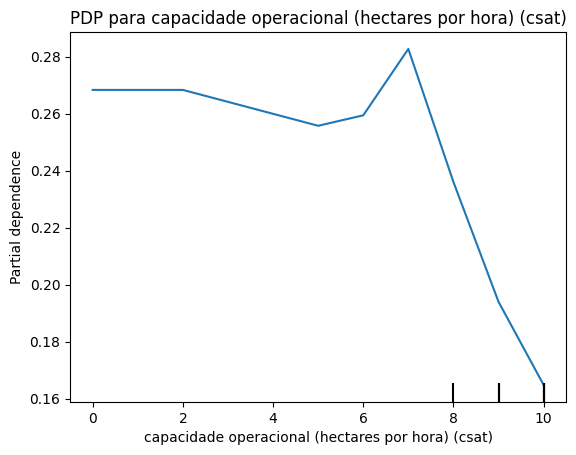

In [ ]:
criarModelo(periodos_pesquisa['18a30'])